# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [78]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [79]:
df = preprocessing(df,
                   used=['cum_loser'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : cum_loser, wml


In [80]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [81]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [82]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [83]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [84]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [85]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [86]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [87]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [88]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

## Rolling Fixed Windows

### Random Forest

In [89]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.36      0.36       316
         1.0       0.66      0.65      0.65       590

    accuracy                           0.55       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.55      0.55      0.55       906


accuracy : 0.5485651214128036

precision : 0.6552315608919382

recall : 0.6474576271186441

F1-Score : 0.6513213981244672



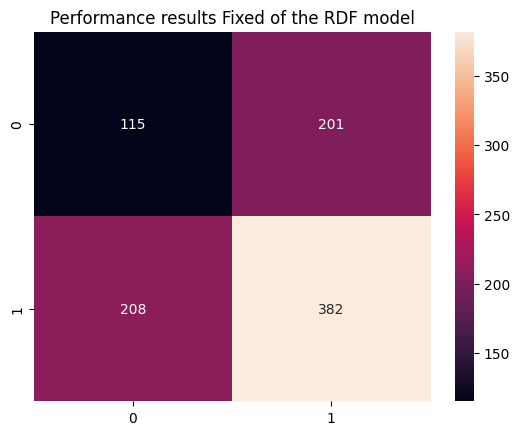


Feature Importance of the model



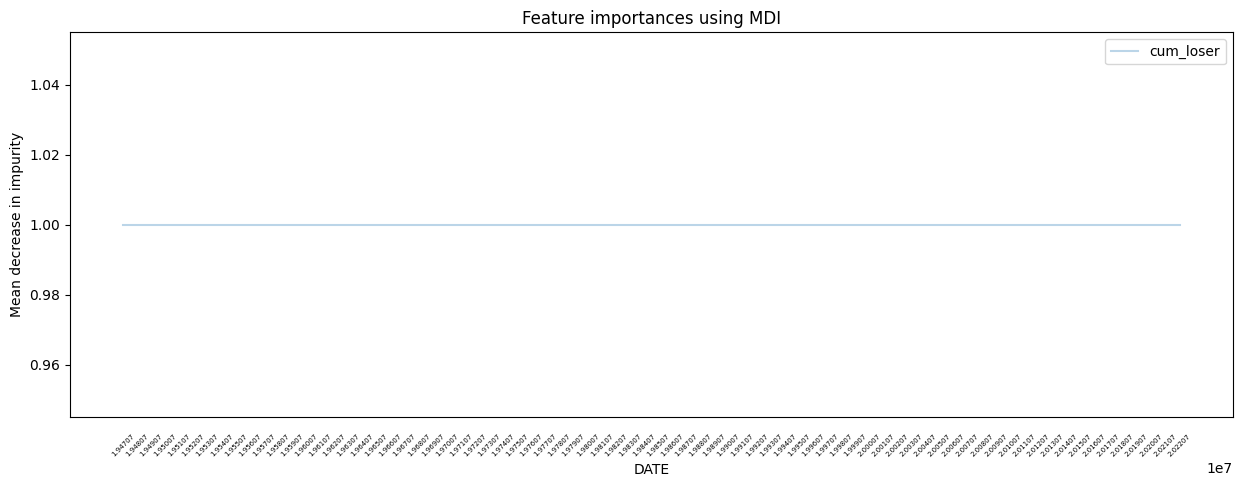

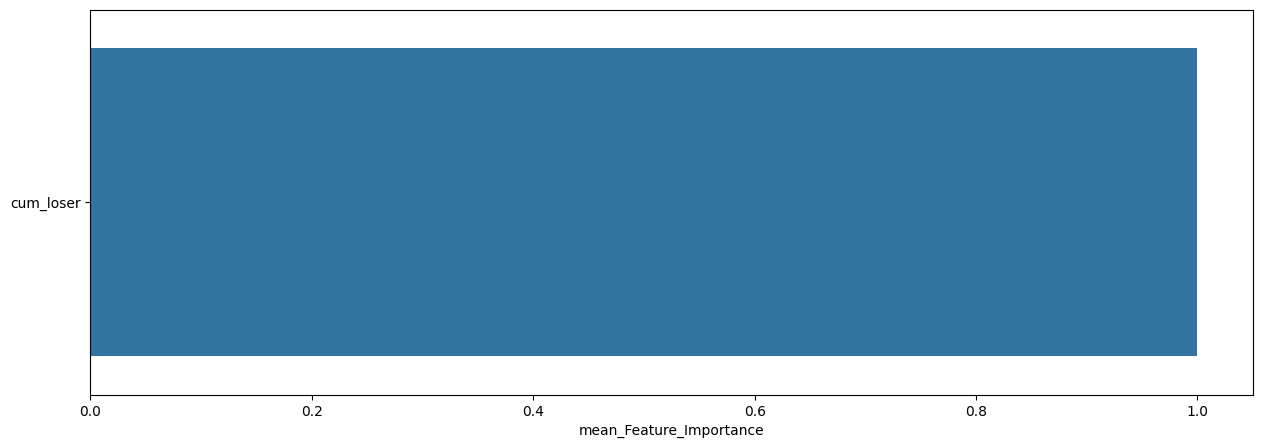

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [90]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.44      0.39        75
         1.0       0.68      0.58      0.63       151

    accuracy                           0.54       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.54      0.55       226


accuracy : 0.5353982300884956

precision : 0.676923076923077

recall : 0.5827814569536424

F1-Score : 0.6263345195729537



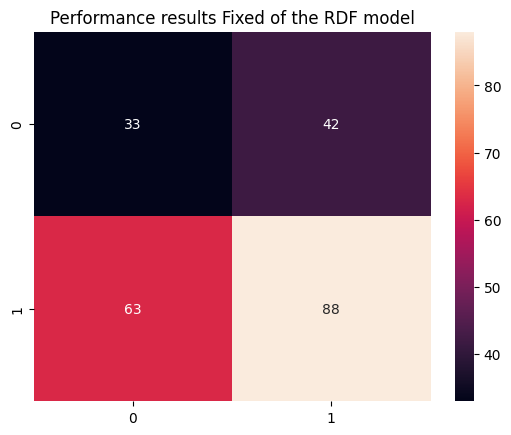


Feature Importance of the model



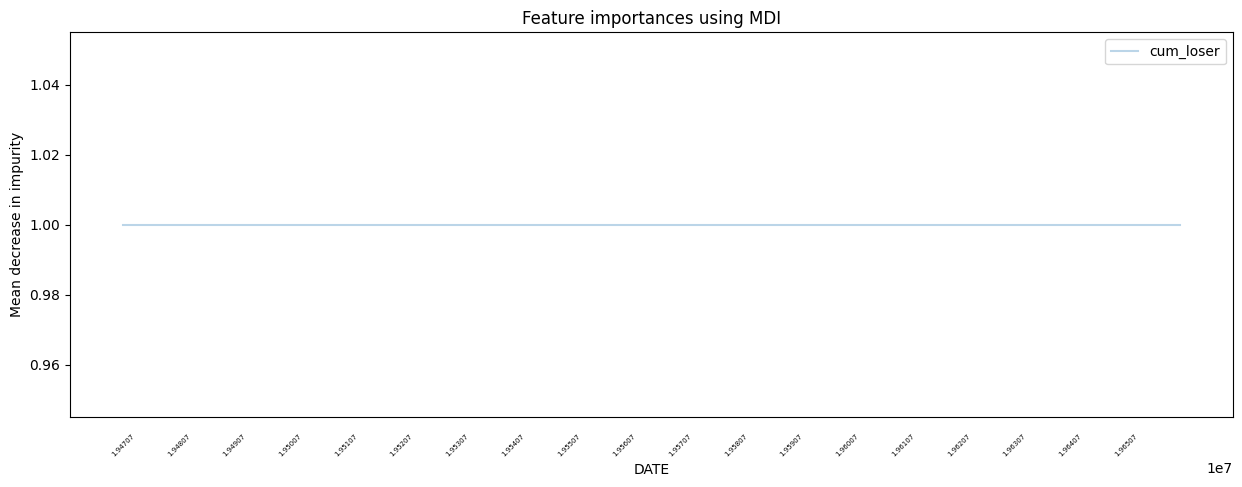

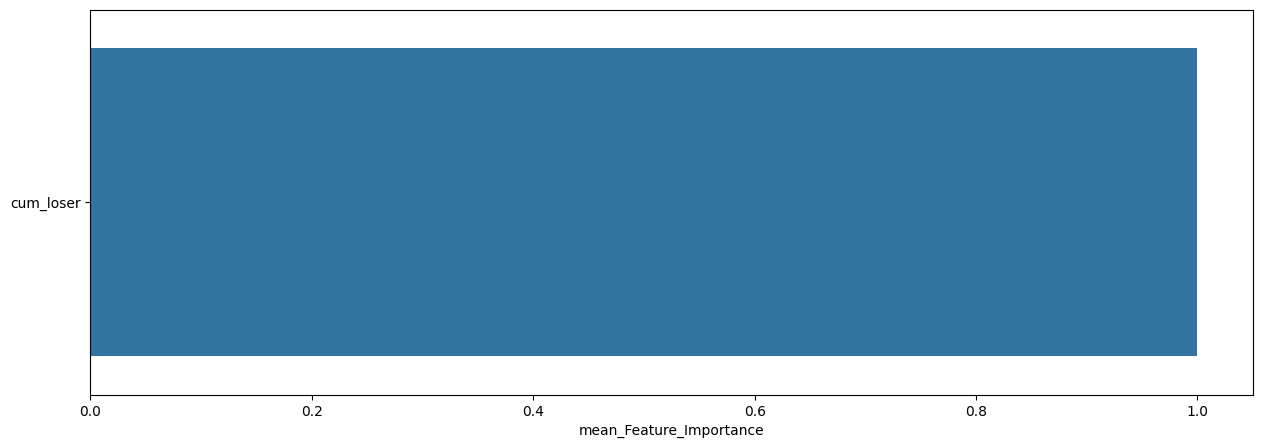

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.36      0.36        75
         1.0       0.68      0.67      0.67       151

    accuracy                           0.57       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.57      0.57       226


accuracy : 0.5663716814159292

precision : 0.6778523489932886

recall : 0.6688741721854304

F1-Score : 0.6733333333333333



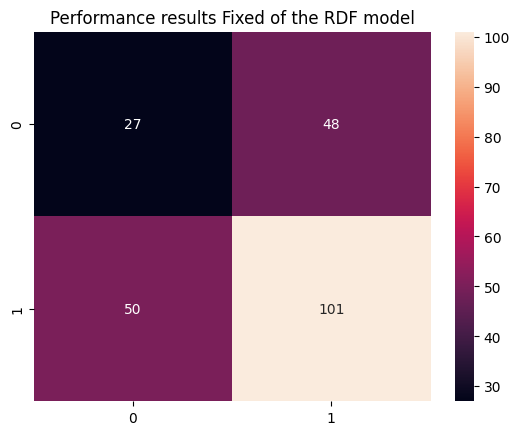


Feature Importance of the model



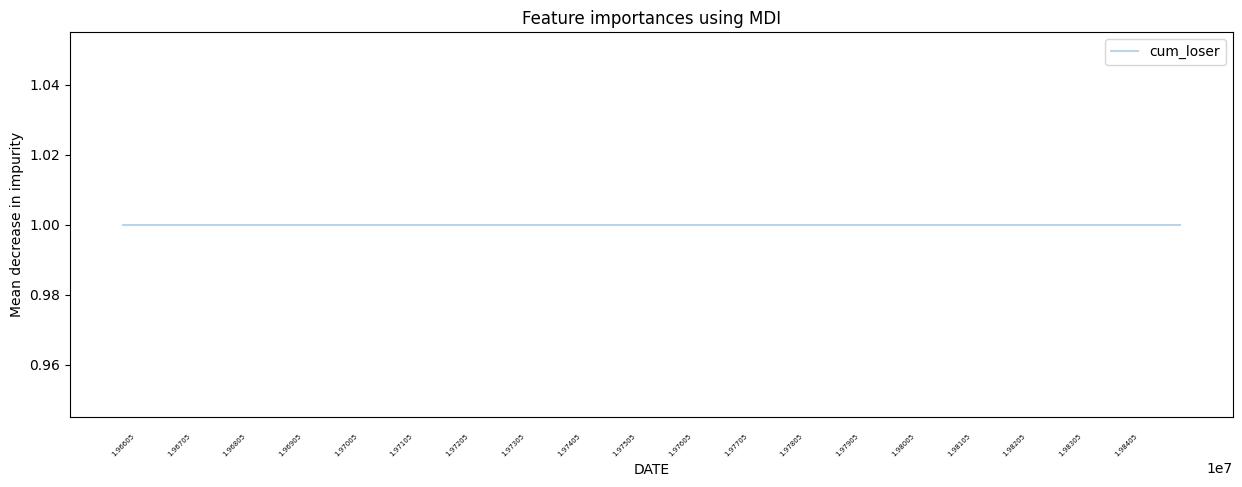

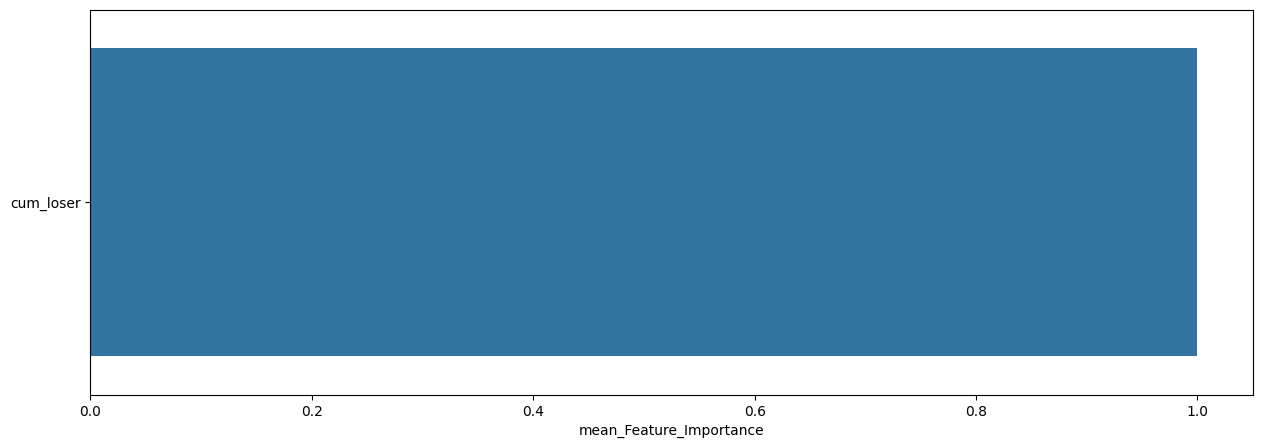

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.36      0.35        70
         1.0       0.70      0.69      0.69       156

    accuracy                           0.58       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.59      0.58      0.59       226


accuracy : 0.584070796460177

precision : 0.7039473684210527

recall : 0.6858974358974359

F1-Score : 0.6948051948051949



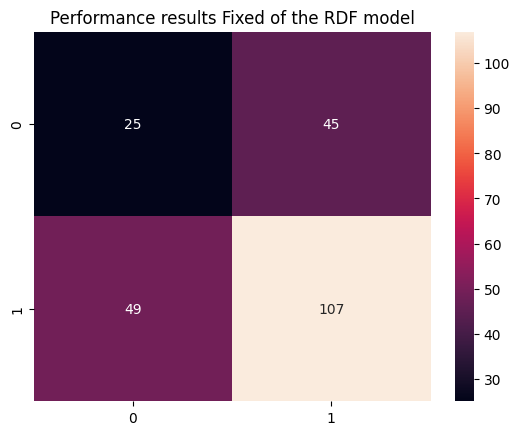


Feature Importance of the model



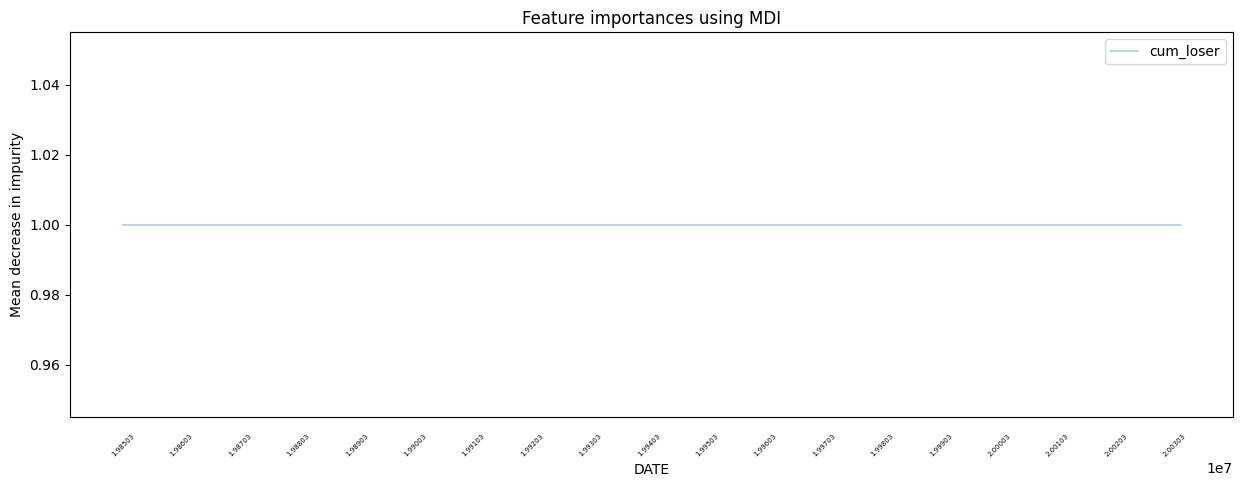

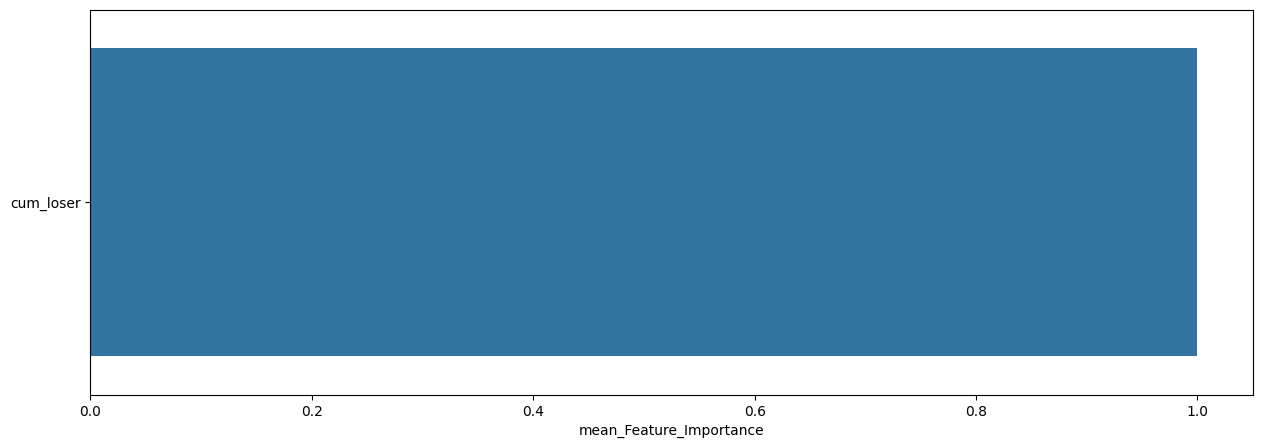

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.31      0.35        96
         1.0       0.57      0.65      0.61       132

    accuracy                           0.51       228
   macro avg       0.48      0.48      0.48       228
weighted avg       0.49      0.51      0.50       228


accuracy : 0.5087719298245614

precision : 0.5657894736842105

recall : 0.6515151515151515

F1-Score : 0.6056338028169014



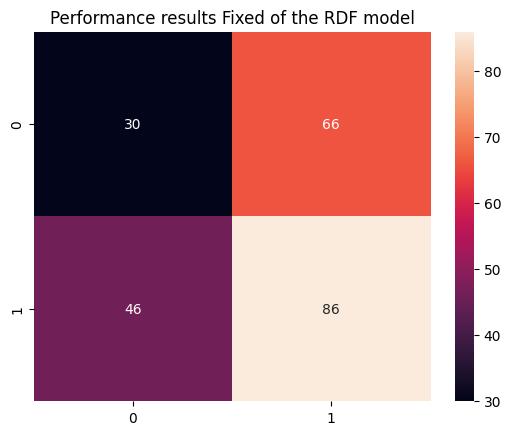


Feature Importance of the model



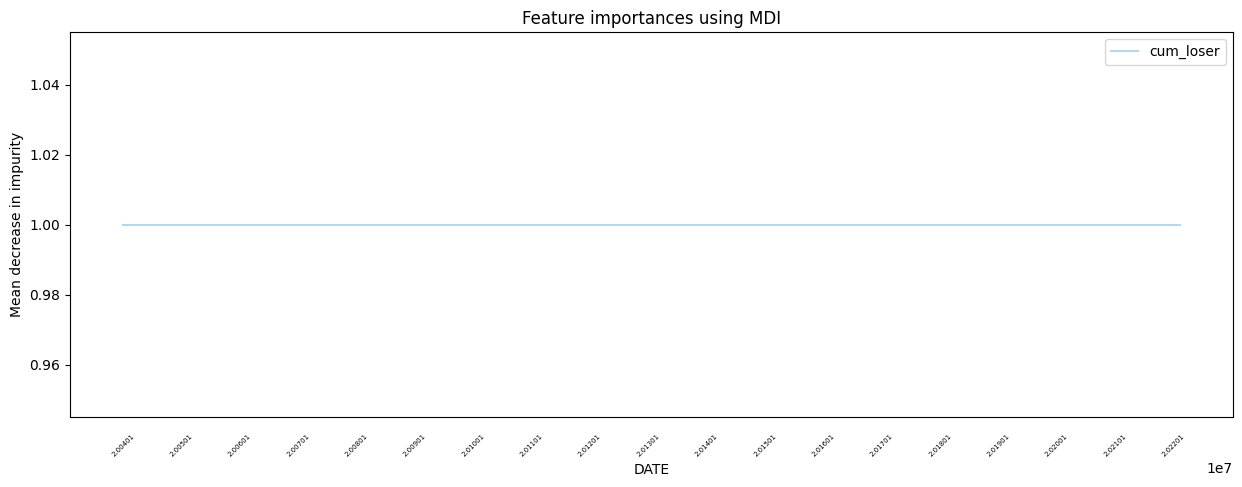

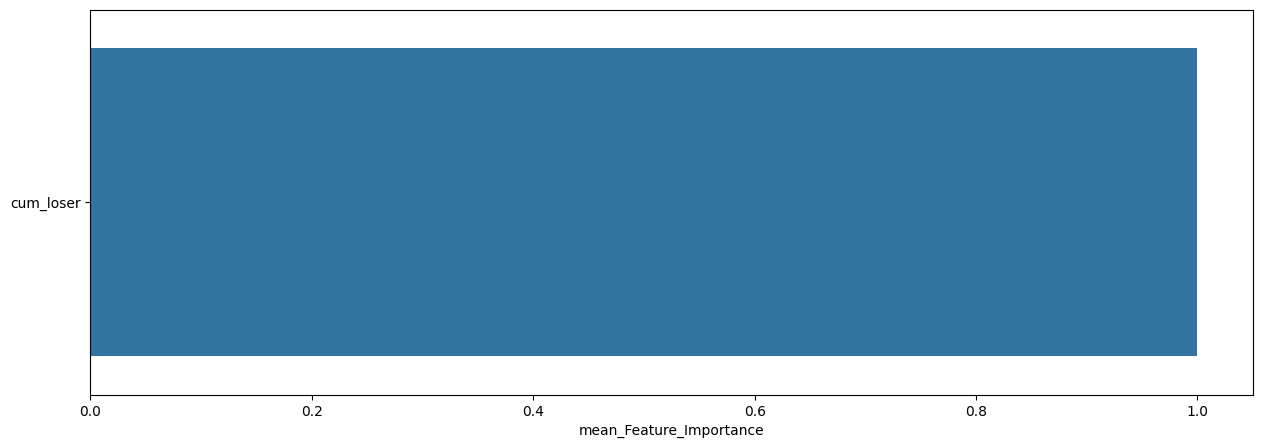

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [91]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



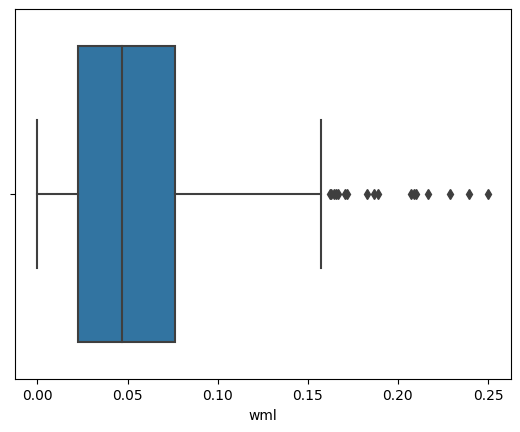

count      mean       std       min      25%       50%       75%  \
wml  382.0  0.056227  0.045772  0.000007  0.02262  0.046719  0.076584   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



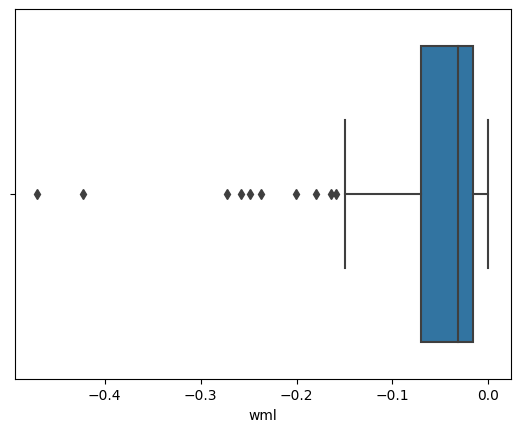

count      mean       std       min       25%       50%       75%  \
wml  115.0 -0.059391  0.077471 -0.469903 -0.070213 -0.031806 -0.015913   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



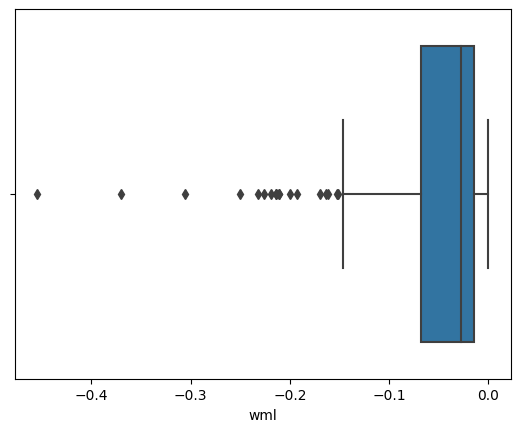

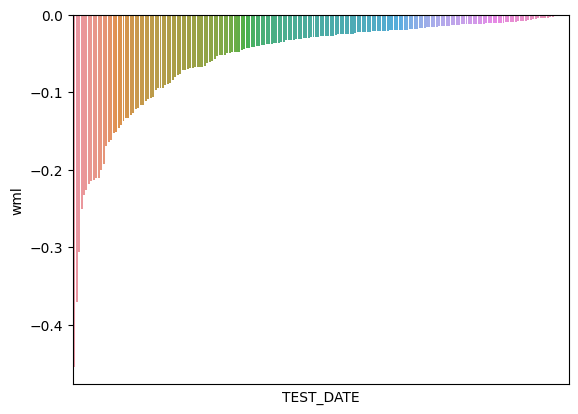

count      mean       std       min       25%       50%       75%  \
wml  201.0 -0.054549  0.067548 -0.454349 -0.067824 -0.027746 -0.014203   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



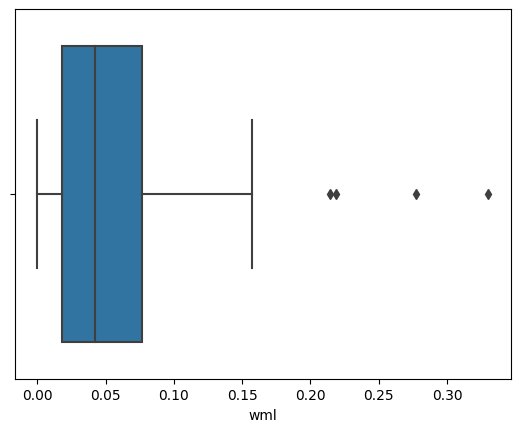

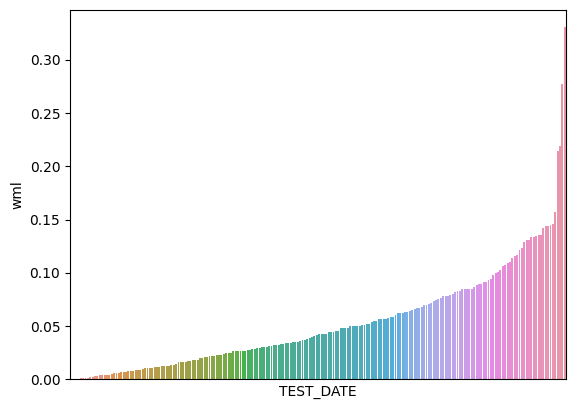

count      mean       std       min       25%       50%       75%  \
wml  208.0  0.053455  0.048723  0.000128  0.018159  0.042247  0.076977   

          max  
wml  0.330163

In [92]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.74939

최근 누적 수익률

  2022년-12월 -> 5900.60
  2022년-11월 -> 5316.24
  2022년-10월 -> 5316.24
  2022년-09월 -> 4707.35
  2022년-08월 -> 4279.59

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-11월 -> 7125.70
  2등 : 2009년-03월 -> 6957.02
  3등 : 2009년-02월 -> 6957.02
  4등 : 2009년-01월 -> 6957.02
  5등 : 2008년-12월 -> 6957.02
  6등 : 2008년-10월 -> 6497.96
  7등 : 2008년-06월 -> 6232.80
  8등 : 2008년-07월 -> 6232.80
  9등 : 2008년-09월 -> 6134.44
  10등 : 2008년-08월 -> 6134.44



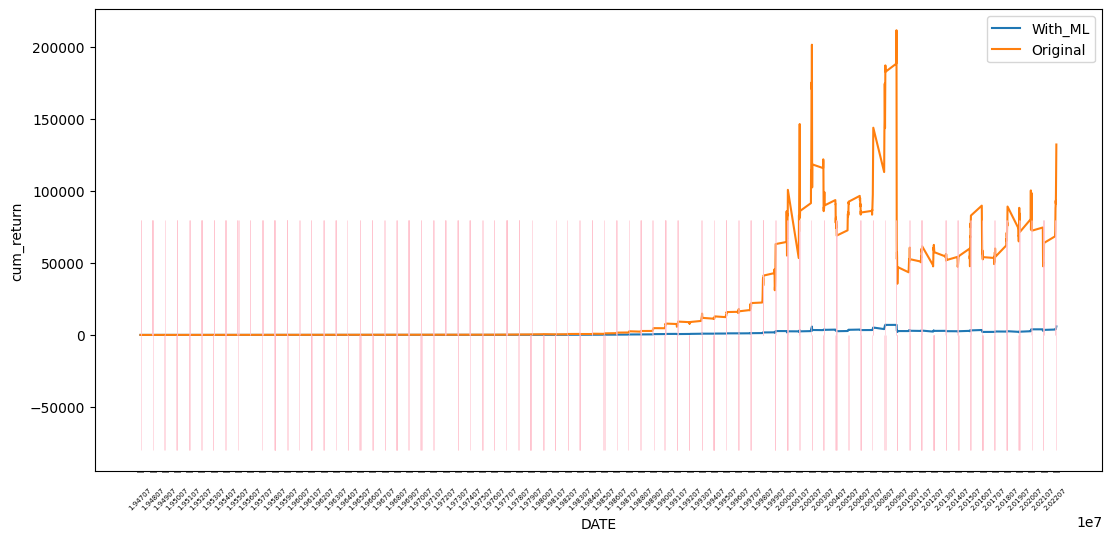

In [93]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.76491

최근 누적 수익률

  2022년-12월 -> 6946.51
  2022년-11월 -> 6277.23
  2022년-10월 -> 6261.18
  2022년-09월 -> 5550.43
  2022년-08월 -> 5083.03

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 7411.55
  2등 : 2008년-11월 -> 7192.66
  3등 : 2009년-01월 -> 7072.12
  4등 : 2008년-12월 -> 7039.42
  5등 : 2022년-12월 -> 6946.51
  6등 : 2008년-10월 -> 6617.31
  7등 : 2002년-09월 -> 6439.04
  8등 : 2008년-06월 -> 6351.47
  9등 : 2022년-11월 -> 6277.23
  10등 : 2022년-10월 -> 6261.18



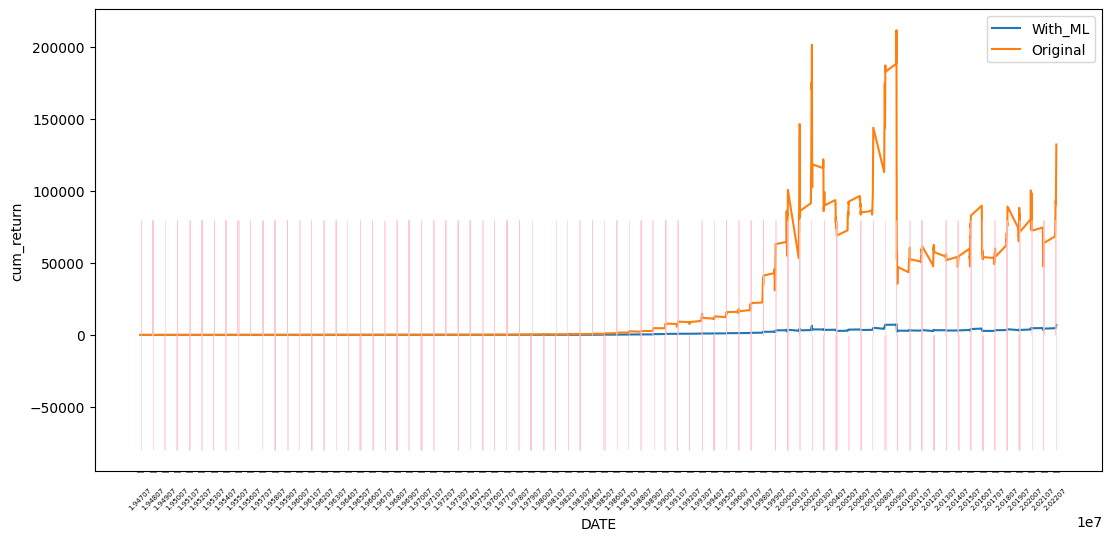

In [94]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [95]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.26      0.31       316
         1.0       0.66      0.77      0.71       590

    accuracy                           0.59       906
   macro avg       0.52      0.51      0.51       906
weighted avg       0.56      0.59      0.57       906


accuracy : 0.5905077262693157

precision : 0.6598540145985401

recall : 0.7661016949152543

F1-Score : 0.7090196078431371



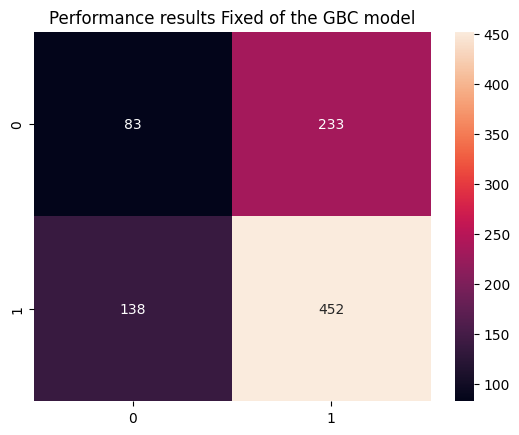


Feature Importance of the model



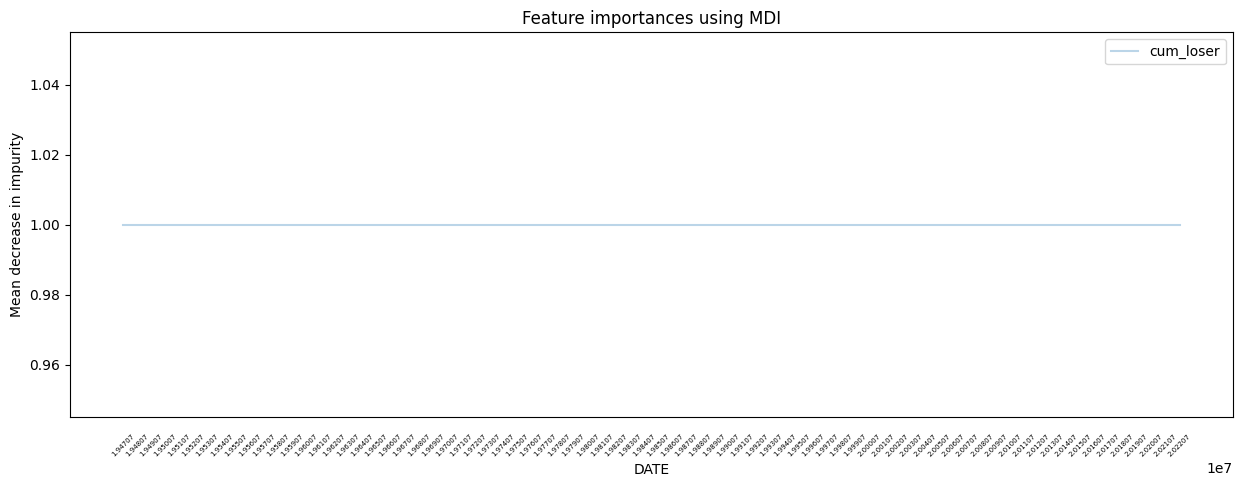

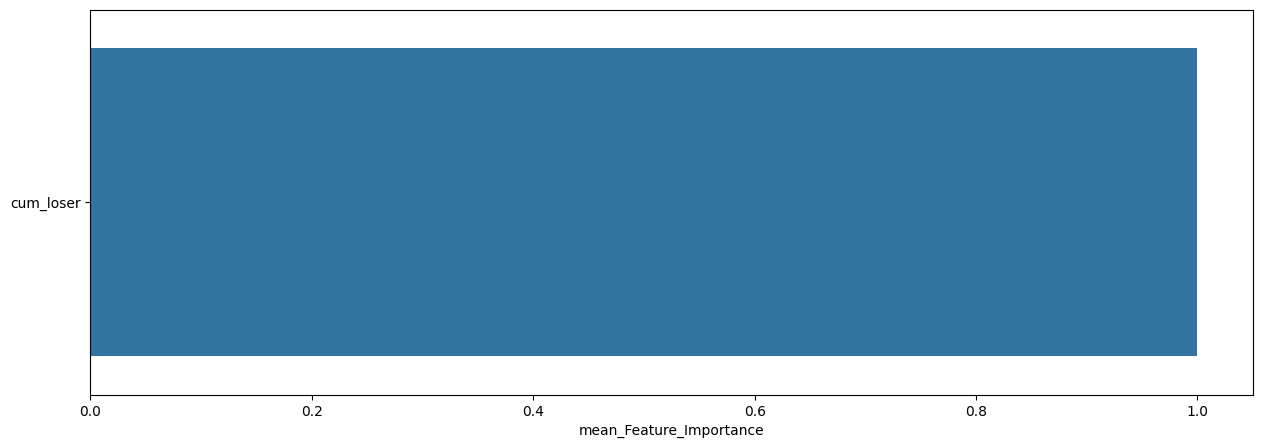

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [96]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.27      0.30        75
         1.0       0.67      0.74      0.70       151

    accuracy                           0.58       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.56      0.58      0.57       226


accuracy : 0.5796460176991151

precision : 0.6686746987951807

recall : 0.7350993377483444

F1-Score : 0.7003154574132493



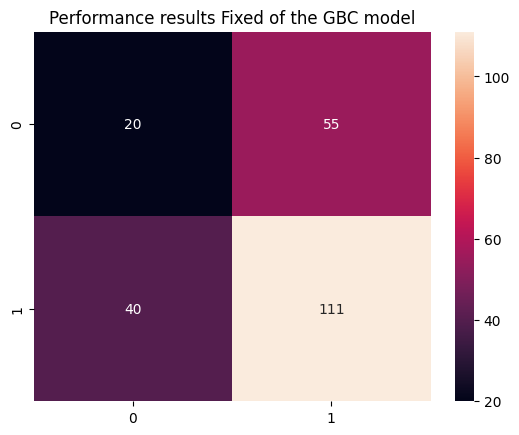


Feature Importance of the model



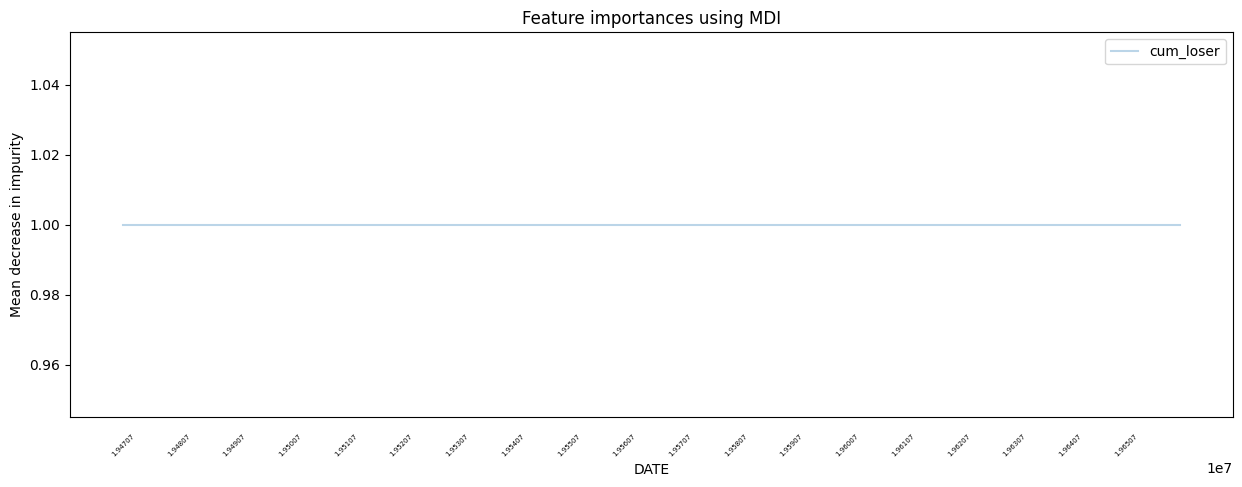

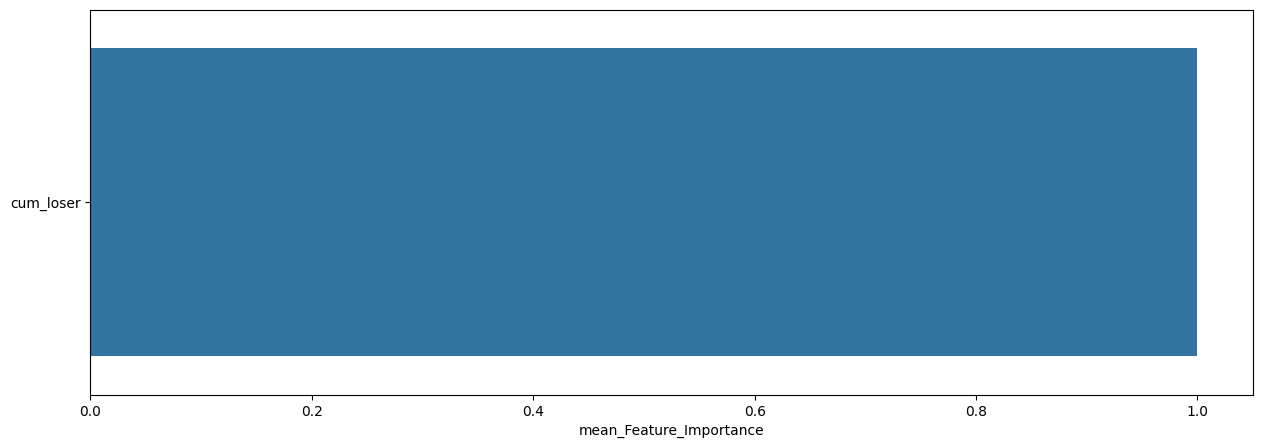

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.27      0.30        75
         1.0       0.67      0.75      0.71       151

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.59      0.58       226


accuracy : 0.5929203539823009

precision : 0.6745562130177515

recall : 0.7549668874172185

F1-Score : 0.7124999999999999



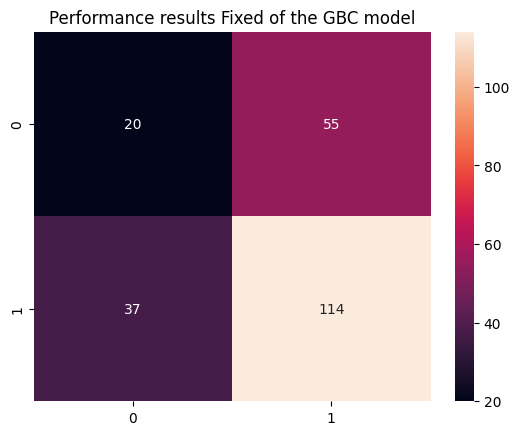


Feature Importance of the model



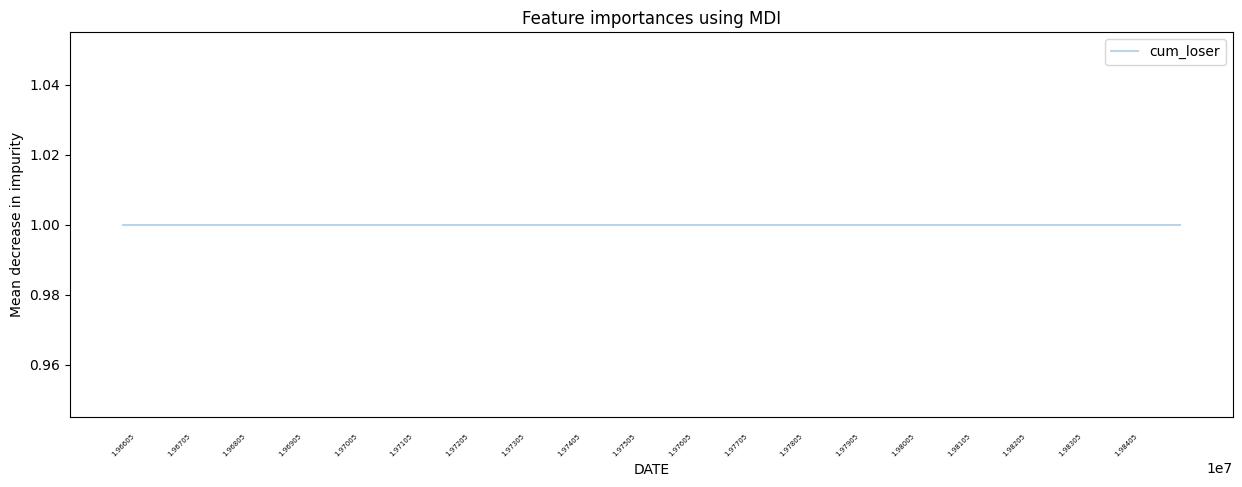

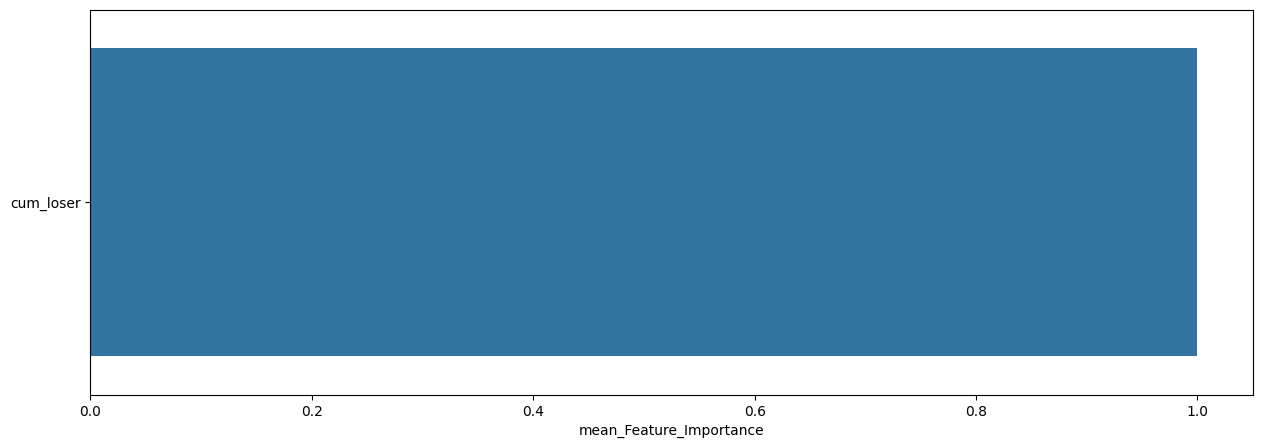

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.29      0.34        70
         1.0       0.72      0.81      0.76       156

    accuracy                           0.65       226
   macro avg       0.56      0.55      0.55       226
weighted avg       0.62      0.65      0.63       226


accuracy : 0.6504424778761062

precision : 0.7175141242937854

recall : 0.8141025641025641

F1-Score : 0.7627627627627629



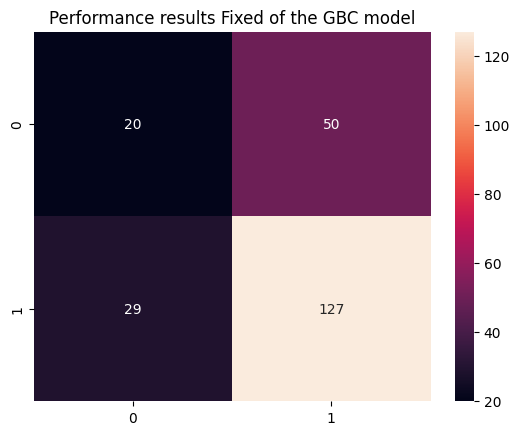


Feature Importance of the model



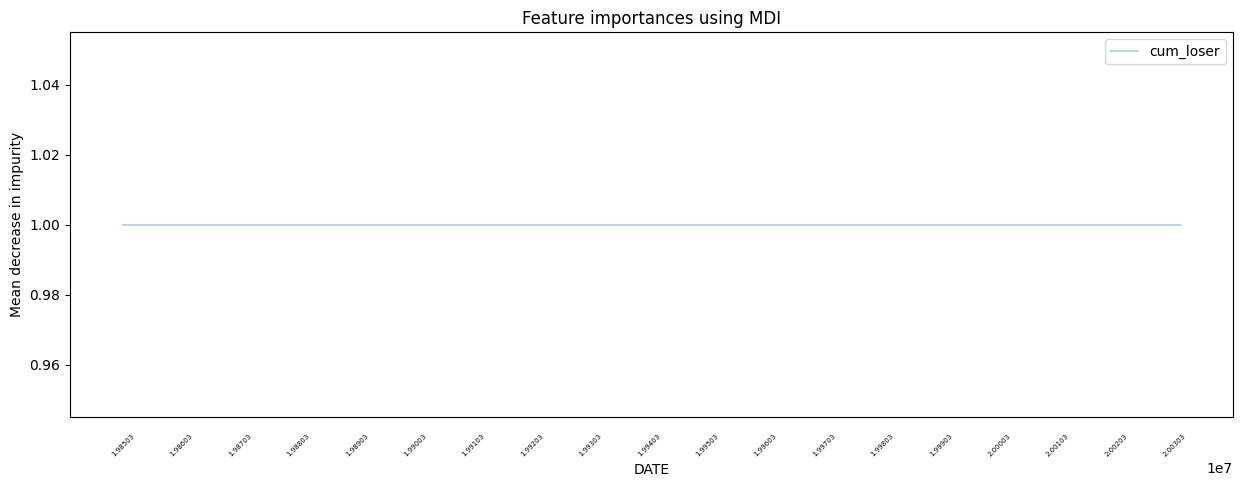

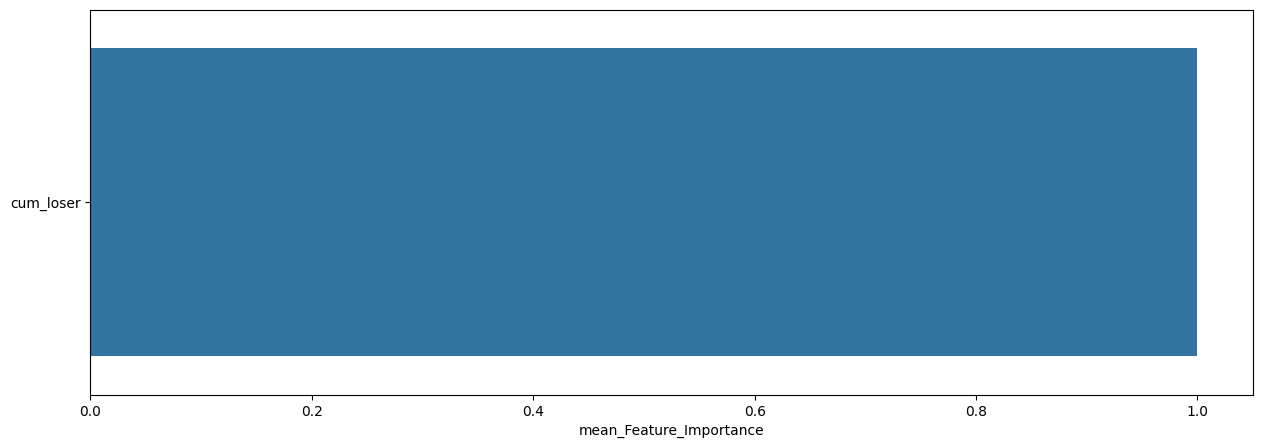

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.24      0.30        96
         1.0       0.58      0.76      0.66       132

    accuracy                           0.54       228
   macro avg       0.50      0.50      0.48       228
weighted avg       0.51      0.54      0.51       228


accuracy : 0.5394736842105263

precision : 0.5780346820809249

recall : 0.7575757575757576

F1-Score : 0.6557377049180327



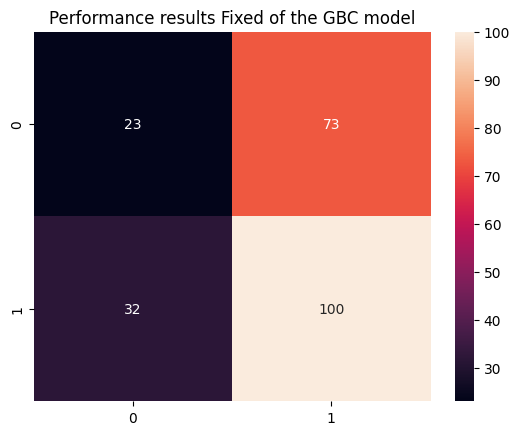


Feature Importance of the model



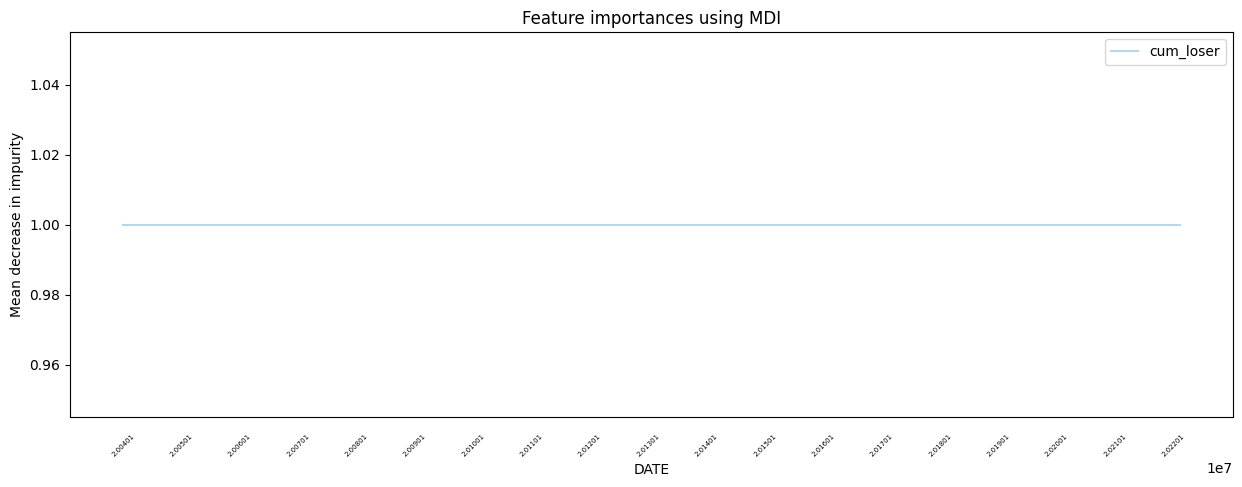

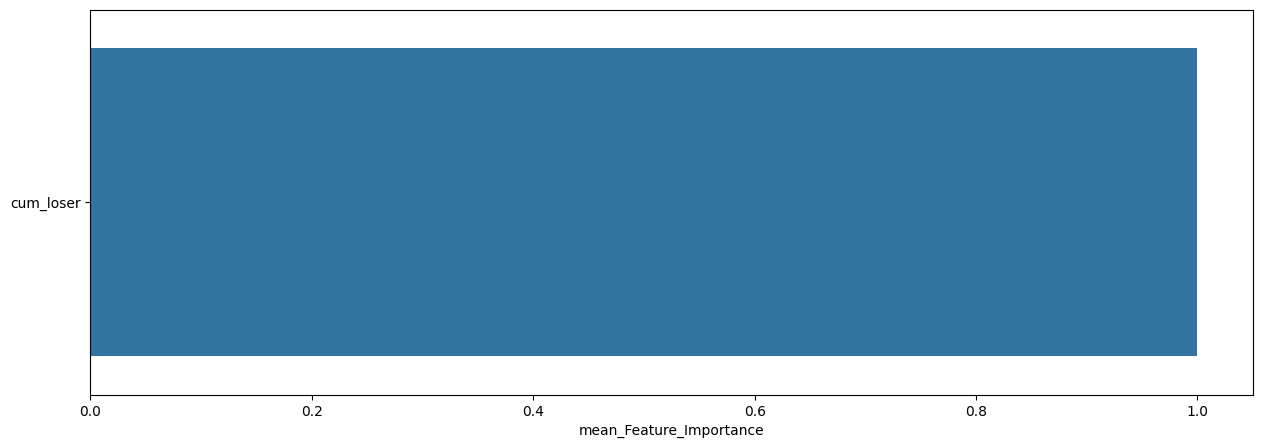

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [97]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



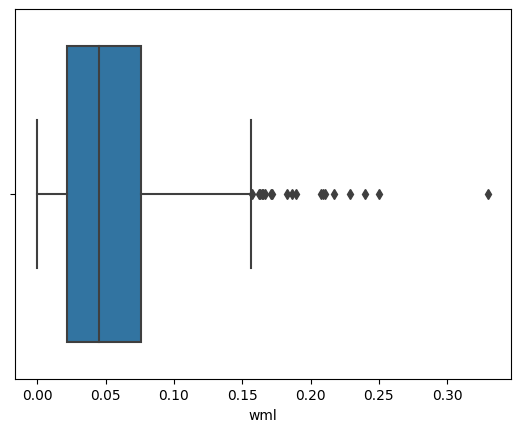

count      mean       std       min       25%       50%       75%  \
wml  452.0  0.055547  0.046724  0.000007  0.021945  0.045319  0.075936   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



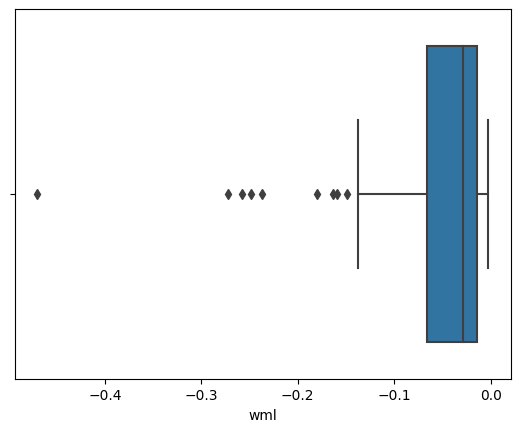

count      mean       std       min       25%       50%       75%  \
wml   83.0 -0.058675  0.076232 -0.469903 -0.065952 -0.028971 -0.014483   

         max  
wml -0.00241


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



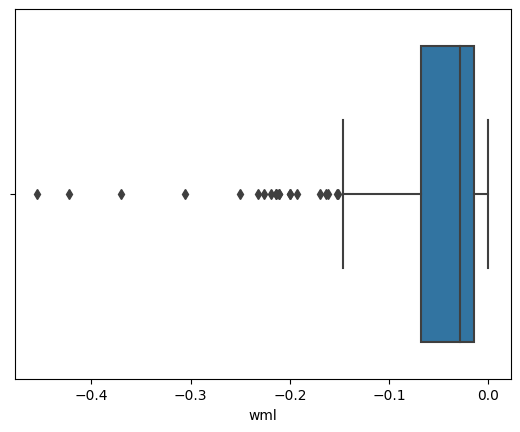

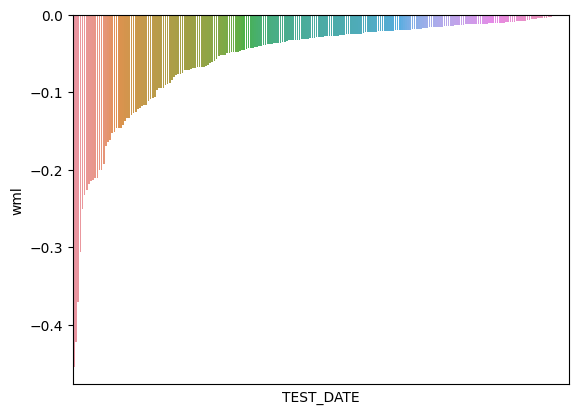

count      mean       std       min       25%       50%       75%  \
wml  233.0 -0.055469  0.069521 -0.454349 -0.067845 -0.028471 -0.014641   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



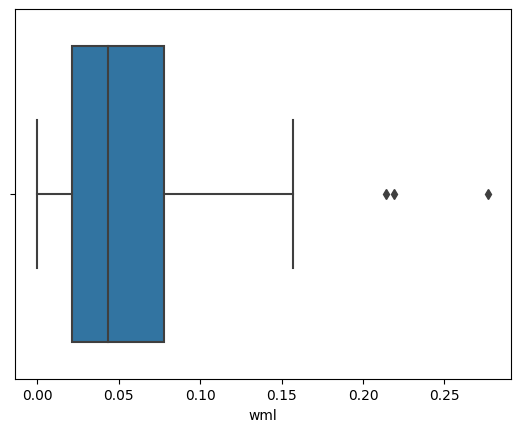

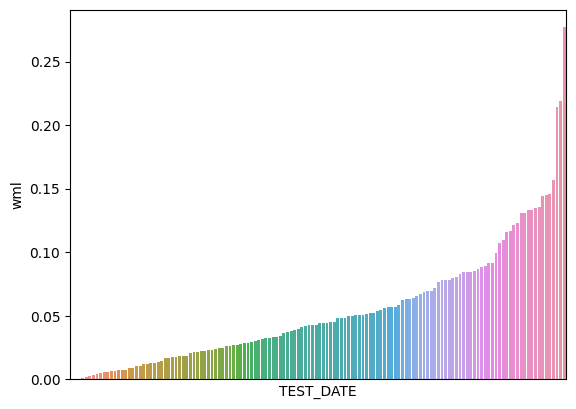

count      mean       std       min       25%       50%       75%  \
wml  138.0  0.054275  0.047254  0.000128  0.021288  0.043589  0.077661   

          max  
wml  0.276912

In [98]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.65368

최근 누적 수익률

  2022년-12월 -> 21464.16
  2022년-11월 -> 19338.74
  2022년-10월 -> 19338.74
  2022년-09월 -> 17124.09
  2022년-08월 -> 15568.25

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-11월 -> 32474.93
  2등 : 2009년-02월 -> 31706.26
  3등 : 2009년-01월 -> 31706.26
  4등 : 2008년-12월 -> 31706.26
  5등 : 2002년-09월 -> 31342.28
  6등 : 2008년-10월 -> 29614.33
  7등 : 2008년-06월 -> 28406.05
  8등 : 2008년-07월 -> 28406.05
  9등 : 2008년-09월 -> 27957.79
  10등 : 2008년-08월 -> 27957.79



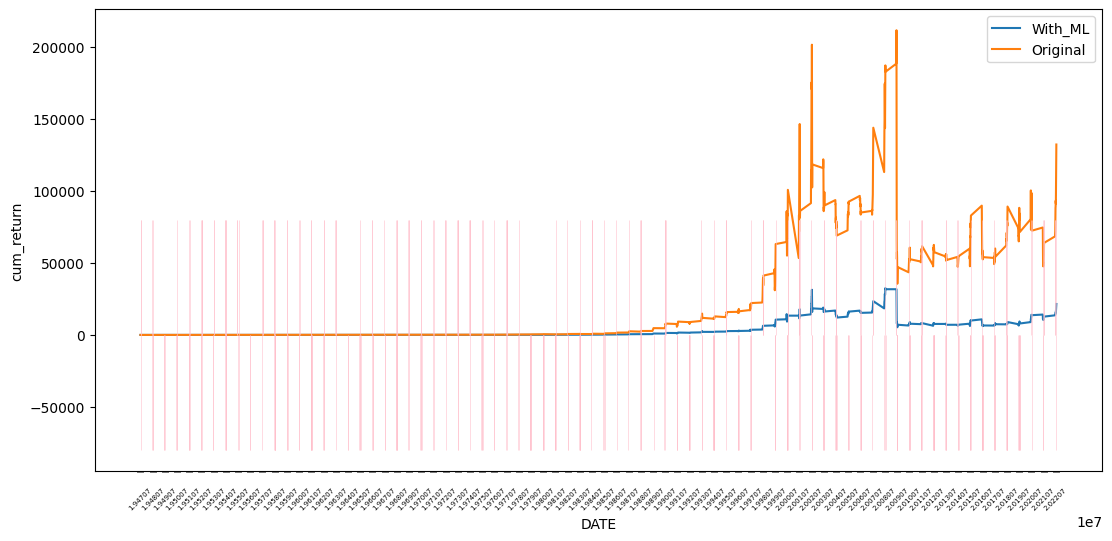

In [99]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73388

최근 누적 수익률

  2022년-12월 -> 5329.63
  2022년-11월 -> 4858.16
  2022년-10월 -> 4820.95
  2022년-09월 -> 4328.02
  2022년-08월 -> 3982.15

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 6944.50
  2등 : 2008년-11월 -> 6896.10
  3등 : 2009년-01월 -> 6791.05
  4등 : 2008년-12월 -> 6756.45
  5등 : 2002년-09월 -> 6485.16
  6등 : 2008년-10월 -> 6401.75
  7등 : 2008년-06월 -> 6329.55
  8등 : 2008년-09월 -> 6090.11
  9등 : 2008년-07월 -> 5994.07
  10등 : 2008년-08월 -> 5910.53



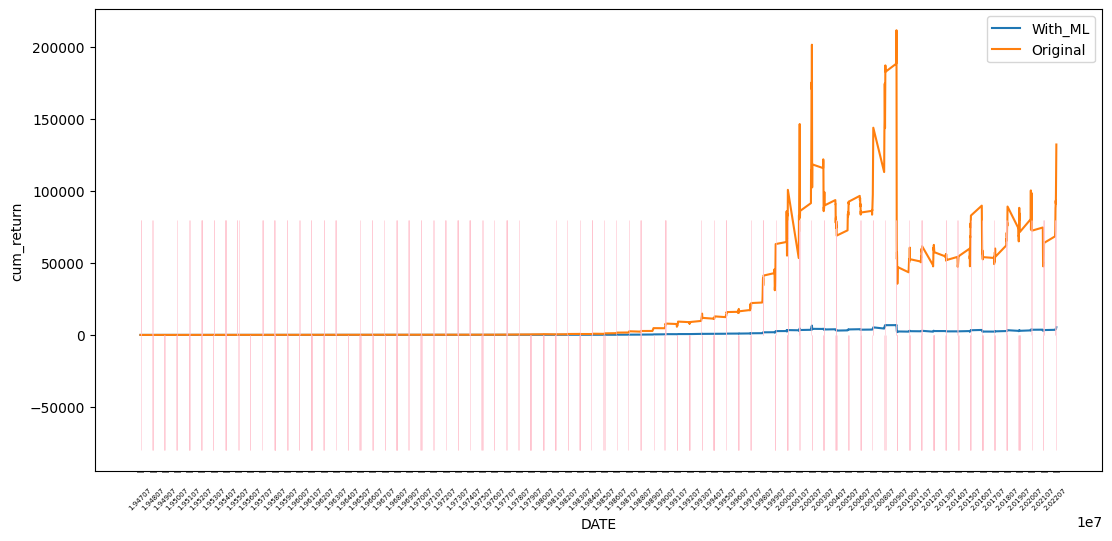

In [100]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [101]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.30      0.32       316
         1.0       0.65      0.70      0.68       590

    accuracy                           0.56       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.56      0.55       906


accuracy : 0.5629139072847682

precision : 0.6525157232704403

recall : 0.7033898305084746

F1-Score : 0.6769983686786297



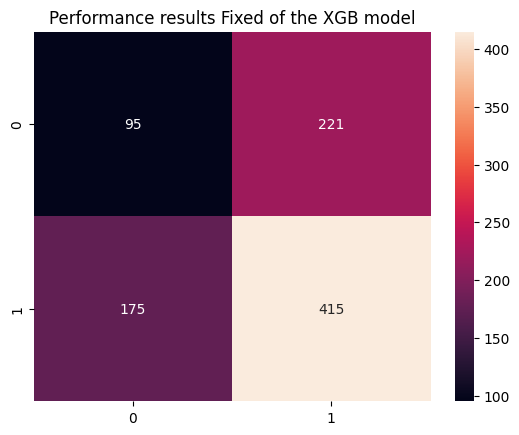


Feature Importance of the model



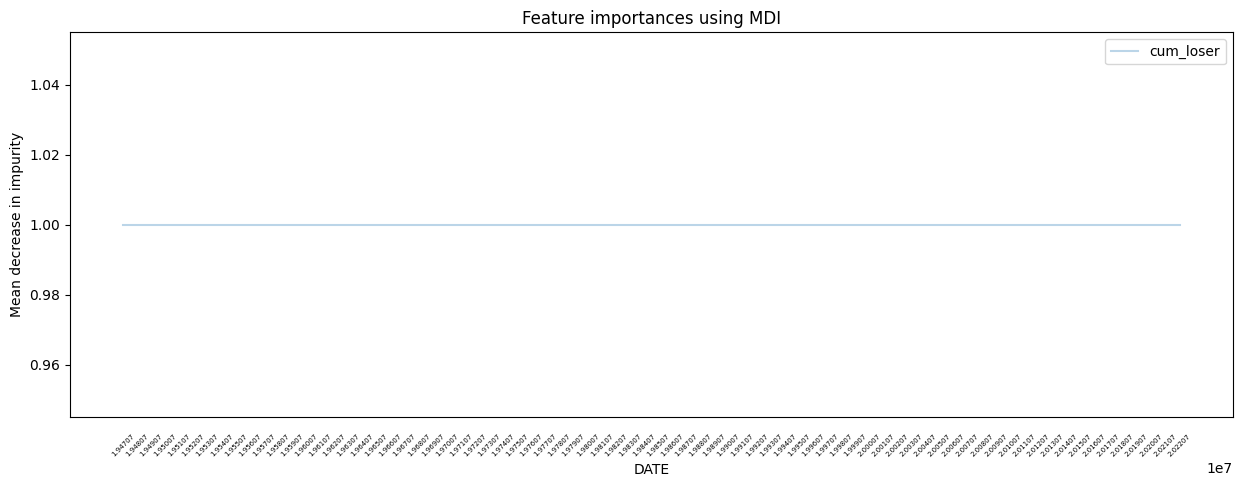

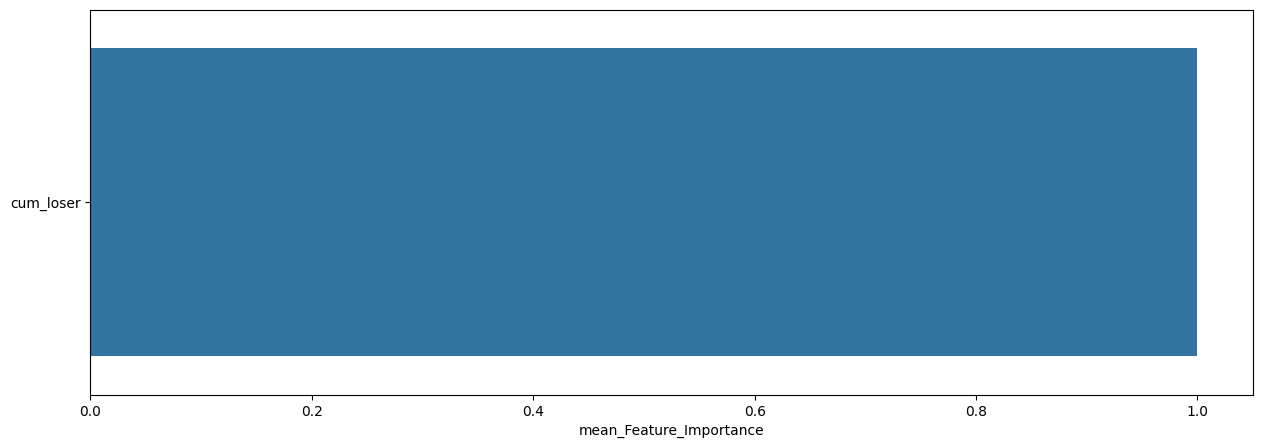

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [102]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.39      0.36        75
         1.0       0.67      0.63      0.65       151

    accuracy                           0.55       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.56      0.55      0.56       226


accuracy : 0.5486725663716814

precision : 0.6737588652482269

recall : 0.6291390728476821

F1-Score : 0.6506849315068493



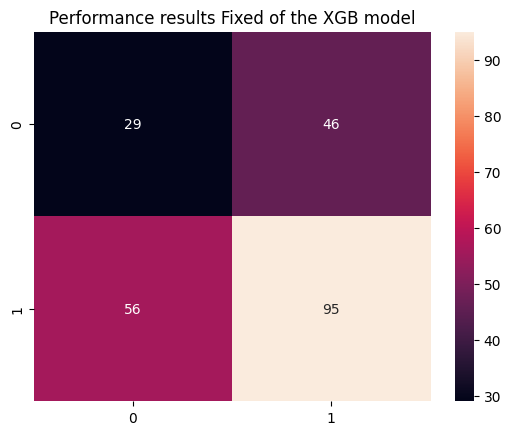


Feature Importance of the model



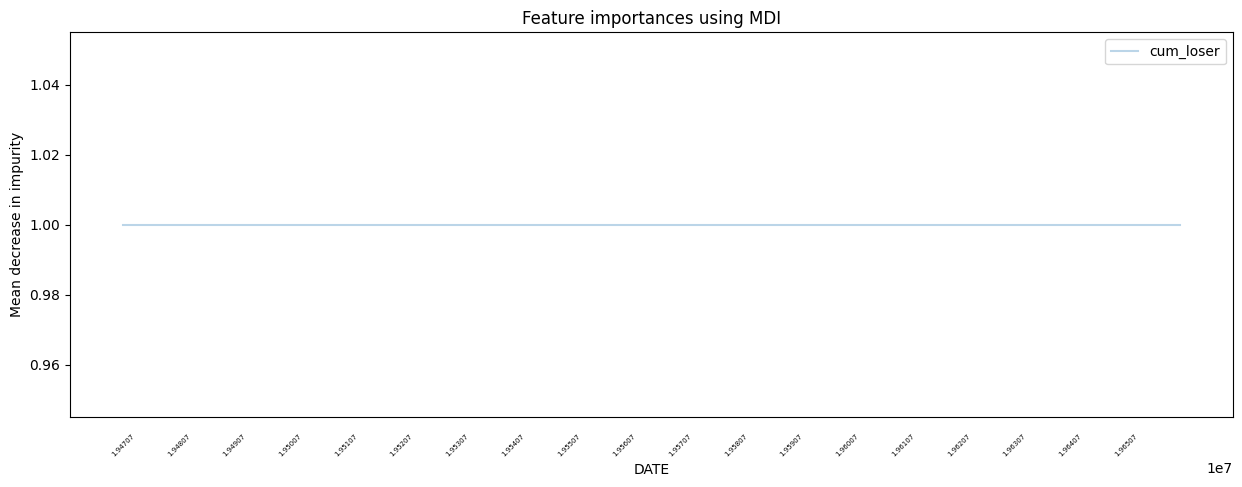

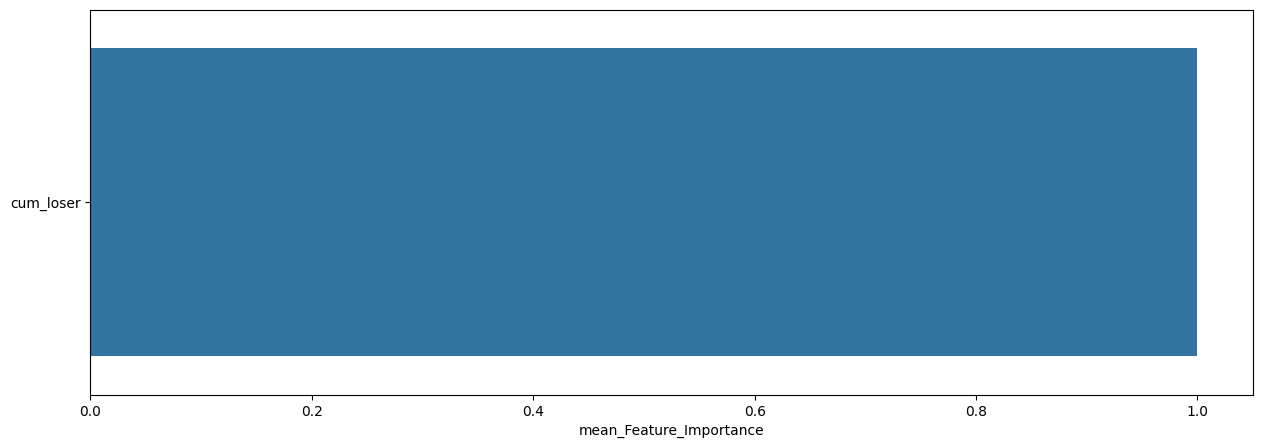

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.28      0.31        75
         1.0       0.68      0.75      0.71       151

    accuracy                           0.59       226
   macro avg       0.52      0.51      0.51       226
weighted avg       0.57      0.59      0.58       226


accuracy : 0.5929203539823009

precision : 0.6766467065868264

recall : 0.7483443708609272

F1-Score : 0.7106918238993712



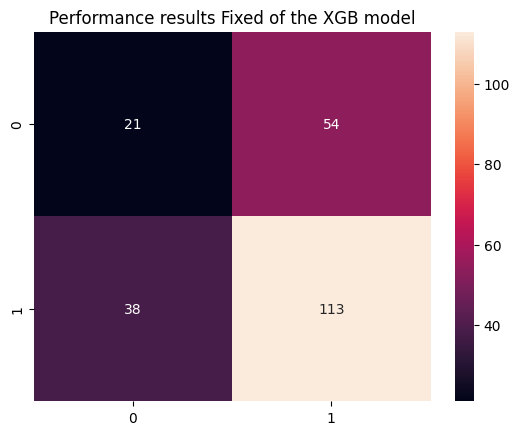


Feature Importance of the model



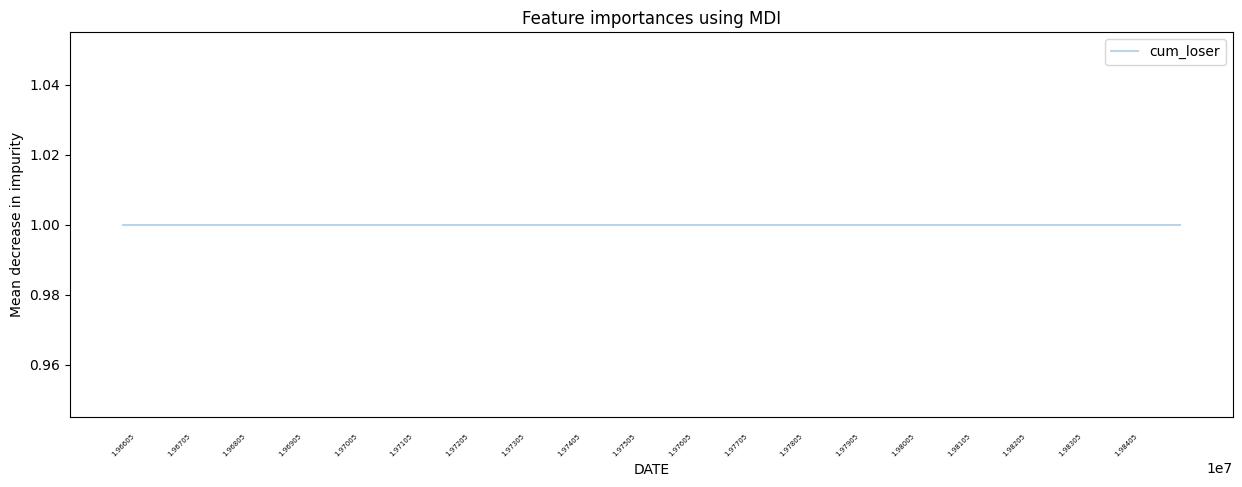

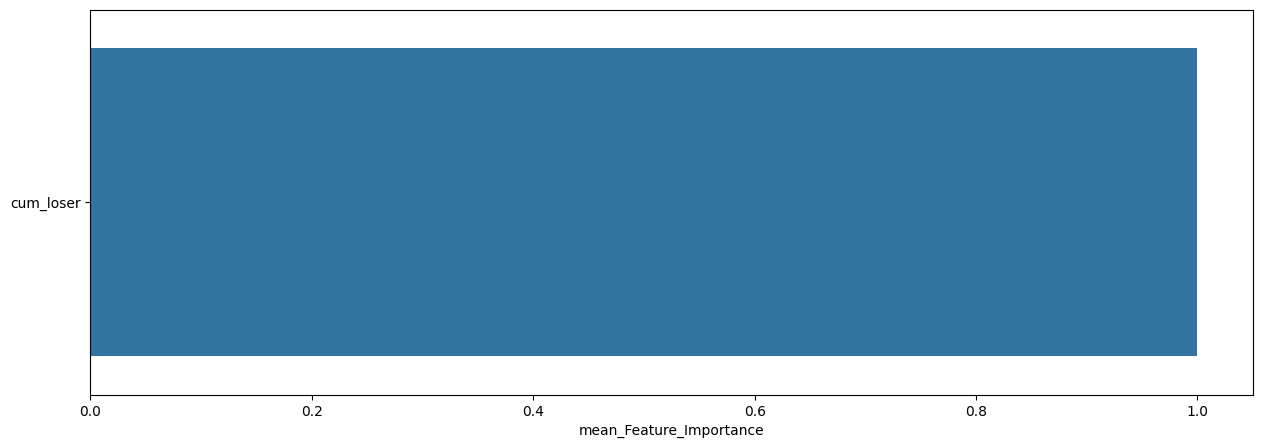

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.30      0.31        70
         1.0       0.70      0.72      0.71       156

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.58      0.59      0.59       226


accuracy : 0.5929203539823009

precision : 0.6975308641975309

recall : 0.7243589743589743

F1-Score : 0.7106918238993709



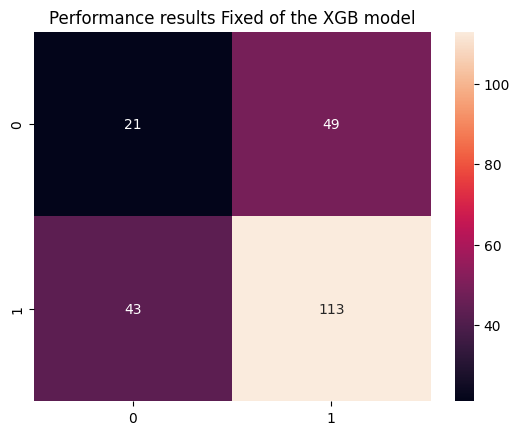


Feature Importance of the model



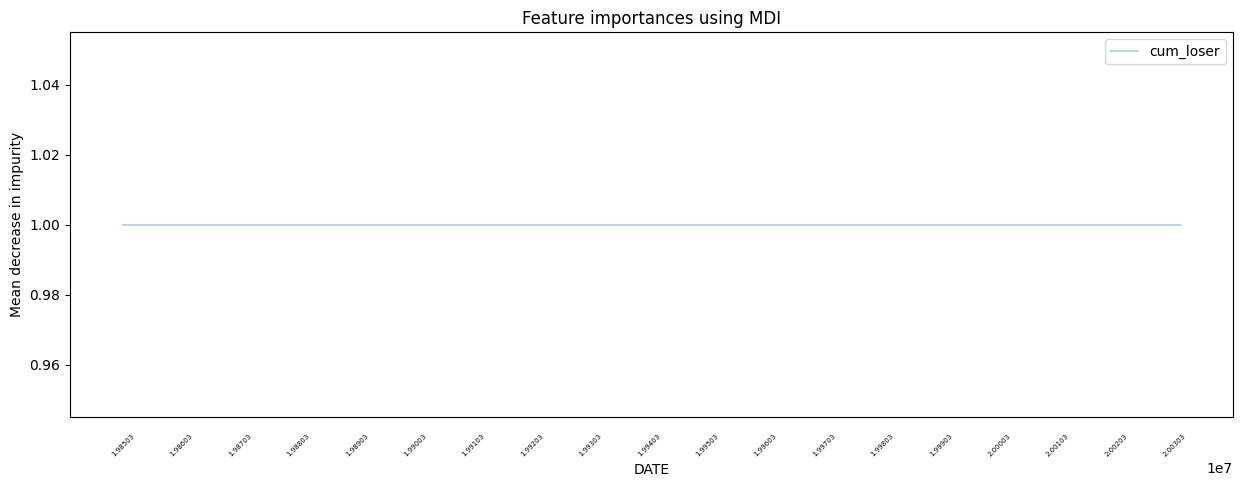

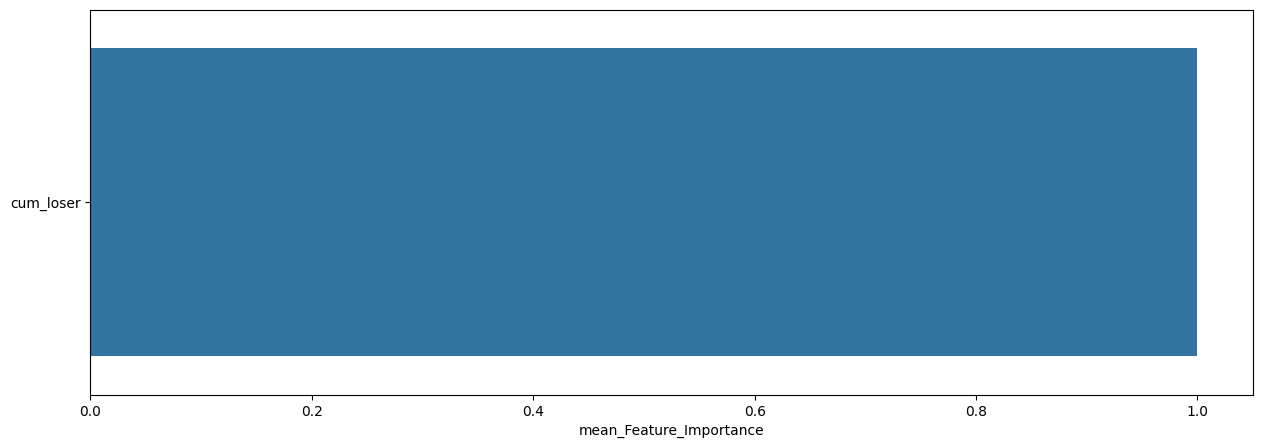

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.25      0.30        96
         1.0       0.57      0.71      0.63       132

    accuracy                           0.52       228
   macro avg       0.48      0.48      0.47       228
weighted avg       0.49      0.52      0.49       228


accuracy : 0.5175438596491229

precision : 0.5662650602409639

recall : 0.7121212121212122

F1-Score : 0.6308724832214765



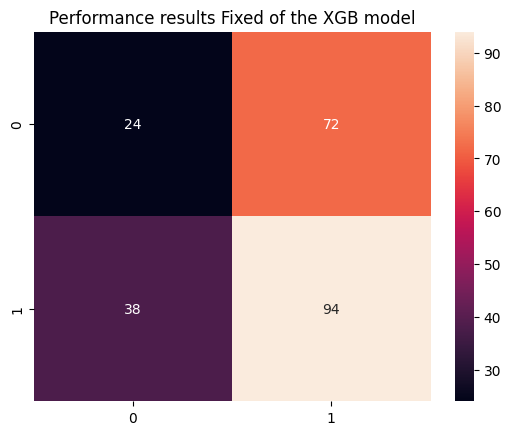


Feature Importance of the model



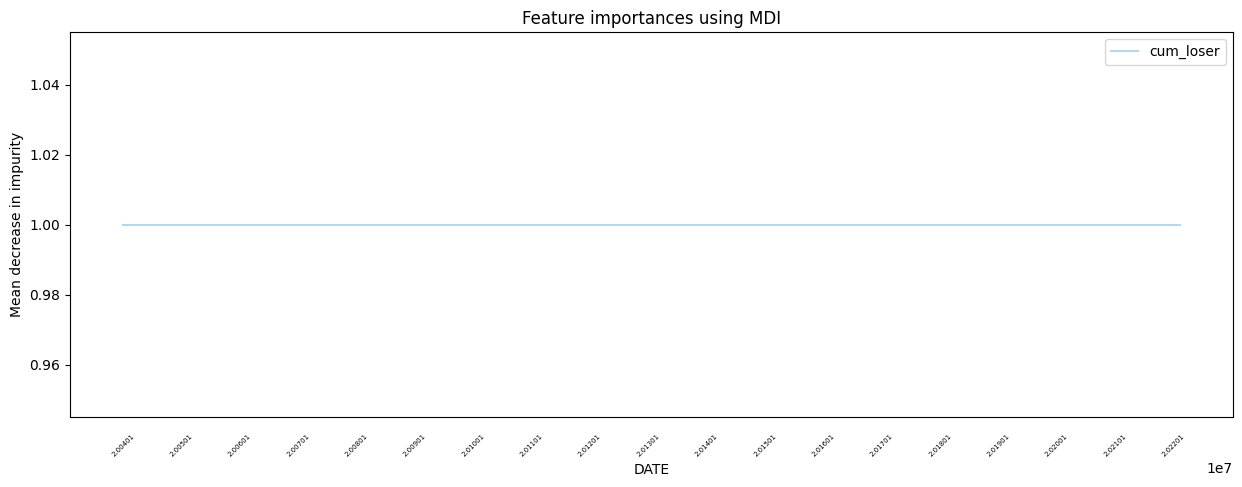

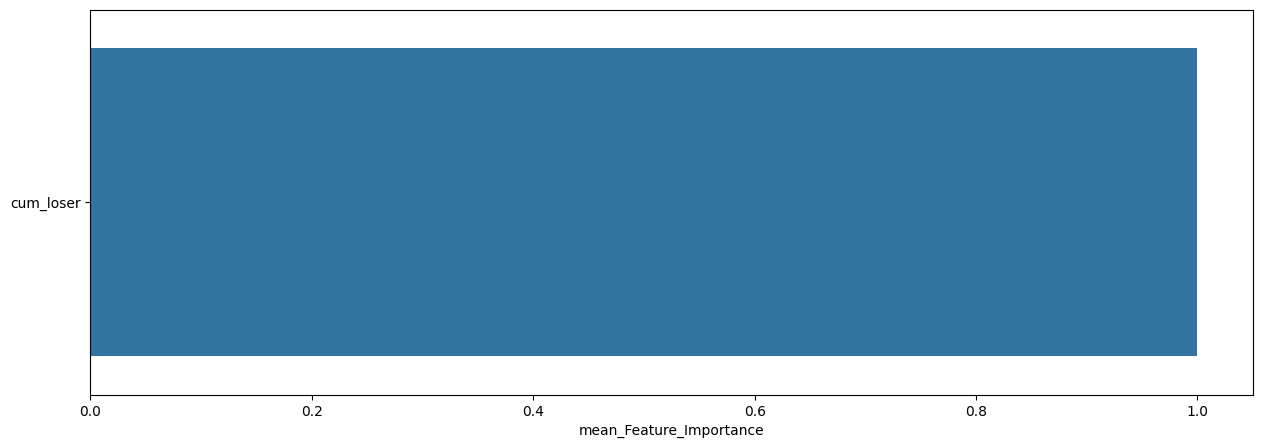

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [103]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



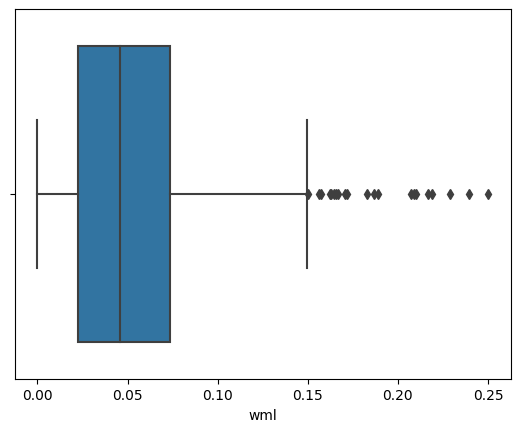

count      mean       std       min       25%       50%       75%  \
wml  415.0  0.055417  0.045806  0.000007  0.022284  0.045557  0.073358   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



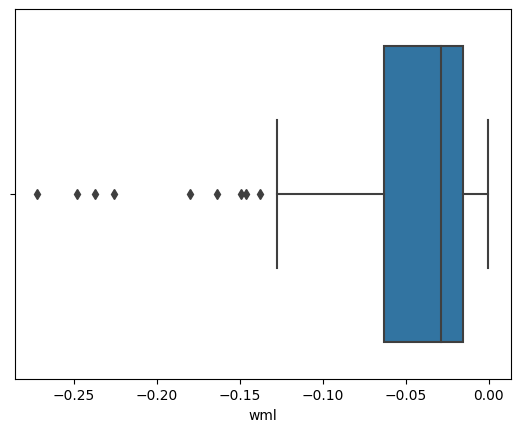

count      mean       std       min       25%       50%       75%  \
wml   95.0 -0.051016  0.056531 -0.271971 -0.063028 -0.028532 -0.015515   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



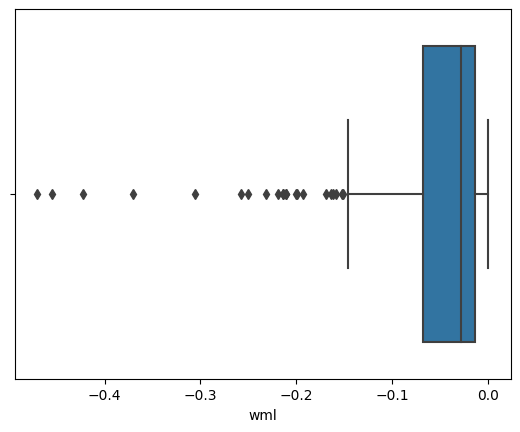

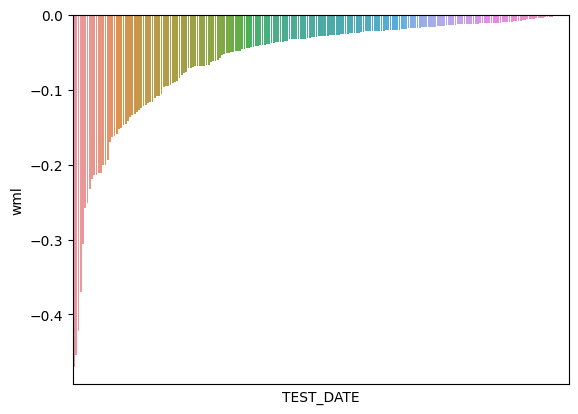

count      mean     std       min      25%       50%       75%       max
wml  221.0 -0.058587  0.0767 -0.469903 -0.06833 -0.028629 -0.014514 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



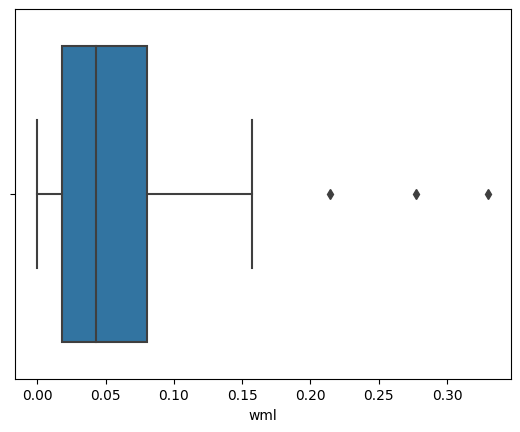

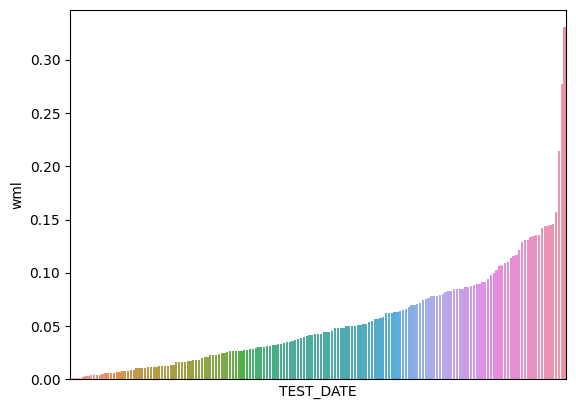

count      mean       std       min       25%       50%       75%  \
wml  175.0  0.054853  0.049246  0.000128  0.018126  0.042855  0.080092   

          max  
wml  0.330163

In [104]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.76718

최근 누적 수익률

  2022년-12월 -> 2399.03
  2022년-11월 -> 2161.38
  2022년-10월 -> 2161.38
  2022년-09월 -> 1913.76
  2022년-08월 -> 1739.81

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 5557.09
  2등 : 2009년-02월 -> 5444.57
  3등 : 1999년-12월 -> 5048.60
  4등 : 2000년-02월 -> 5048.60
  5등 : 2000년-01월 -> 5048.60
  6등 : 2008년-11월 -> 4965.47
  7등 : 2009년-01월 -> 4847.92
  8등 : 2008년-12월 -> 4847.92
  9등 : 2000년-09월 -> 4736.92
  10등 : 2000년-10월 -> 4736.92



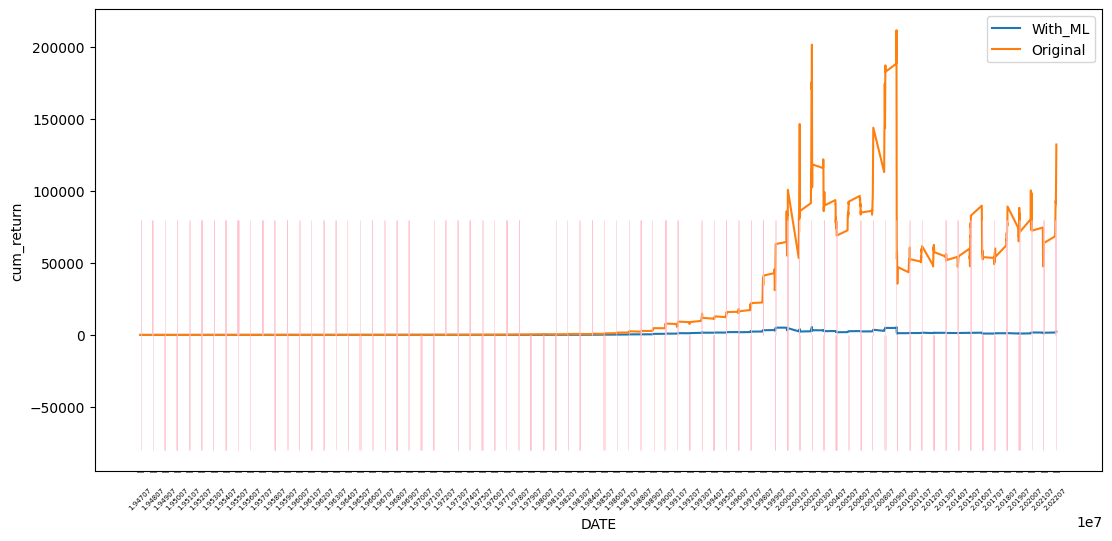

In [105]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.74014

최근 누적 수익률

  2022년-12월 -> 9042.75
  2022년-11월 -> 8205.94
  2022년-10월 -> 8103.71
  2022년-09월 -> 7240.63
  2022년-08월 -> 6639.38

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 9042.75
  2등 : 2009년-02월 -> 8400.00
  3등 : 2022년-11월 -> 8205.94
  4등 : 2022년-10월 -> 8103.71
  5등 : 2008년-11월 -> 7907.67
  6등 : 2009년-01월 -> 7845.30
  7등 : 2008년-12월 -> 7741.27
  8등 : 2008년-10월 -> 7297.47
  9등 : 2022년-09월 -> 7240.63
  10등 : 2008년-06월 -> 7158.55



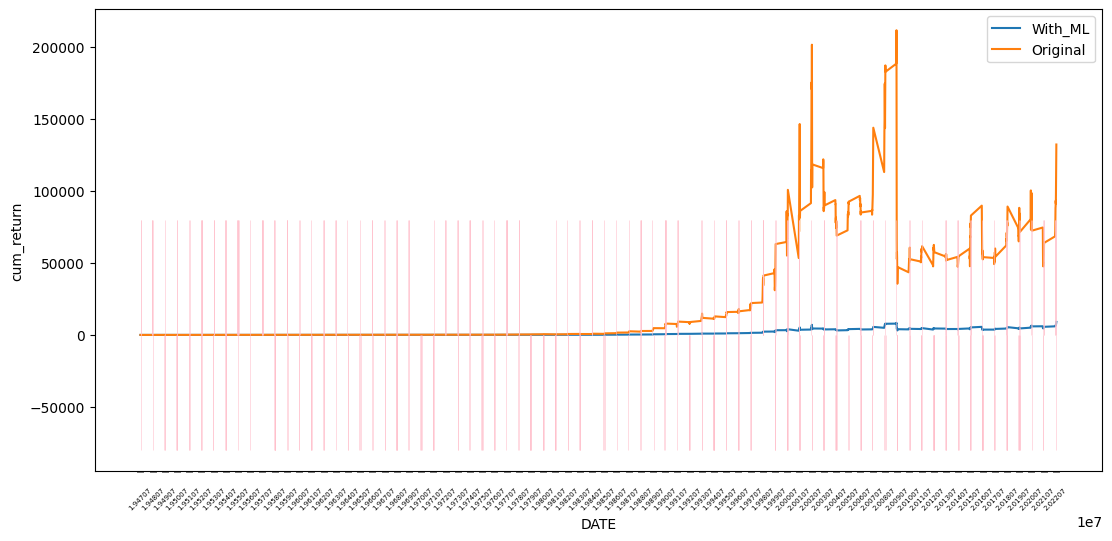

In [106]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [107]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.16      0.22       316
         1.0       0.65      0.84      0.73       590

    accuracy                           0.60       906
   macro avg       0.50      0.50      0.48       906
weighted avg       0.55      0.60      0.56       906


accuracy : 0.6037527593818984

precision : 0.6517739816031537

recall : 0.8406779661016949

F1-Score : 0.7342709104367136



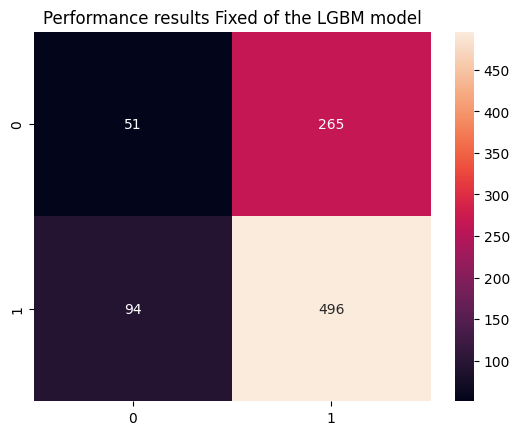


Feature Importance of the model



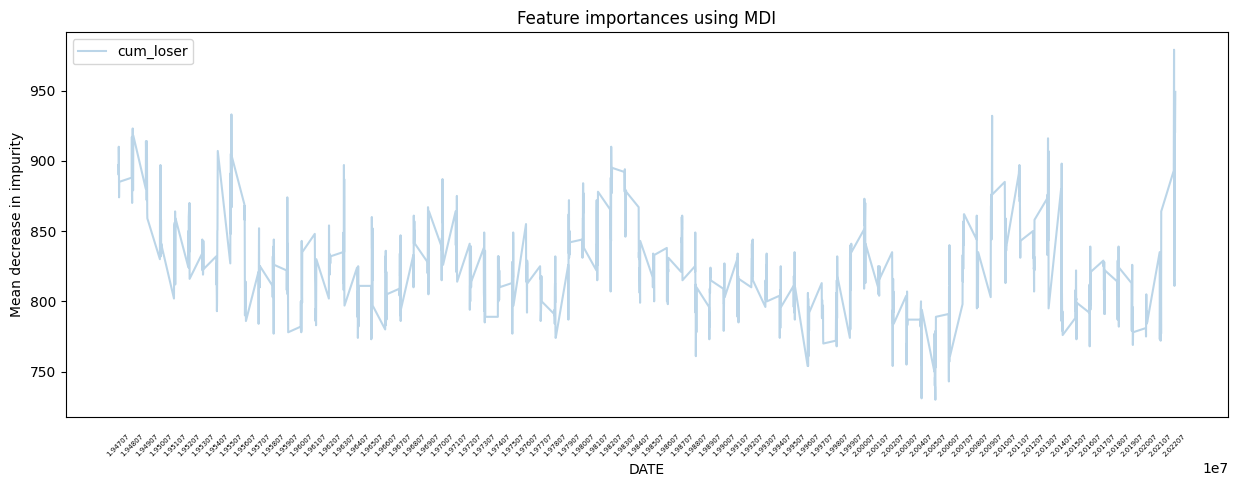

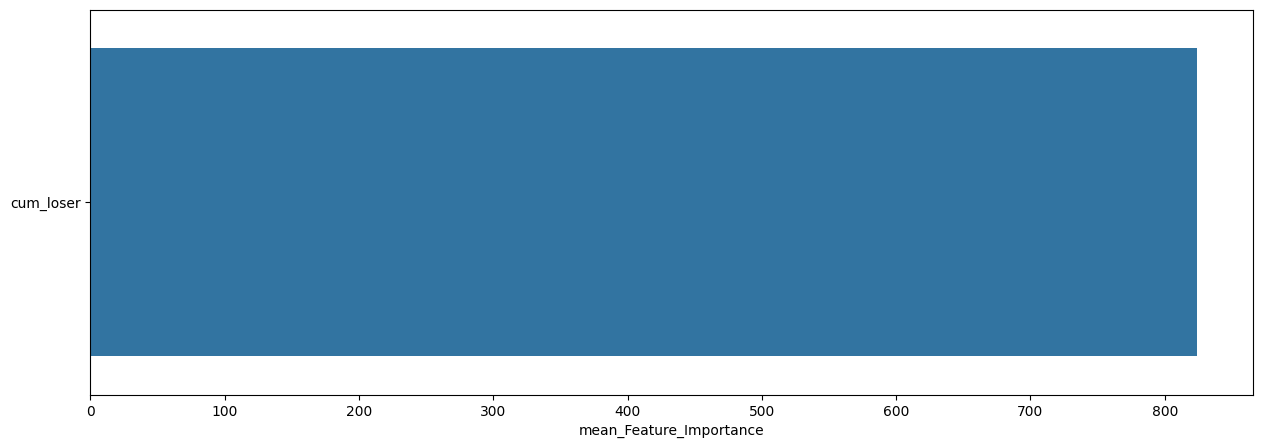

mean_Feature_Importance  max_Feature_Importance  \
cum_loser               824.370861                     979   

           min_Feature_Importance  
cum_loser                     730

In [108]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.21      0.25        75
         1.0       0.66      0.76      0.71       151

    accuracy                           0.58       226
   macro avg       0.48      0.49      0.48       226
weighted avg       0.54      0.58      0.56       226


accuracy : 0.5796460176991151

precision : 0.6609195402298851

recall : 0.7615894039735099

F1-Score : 0.7076923076923076



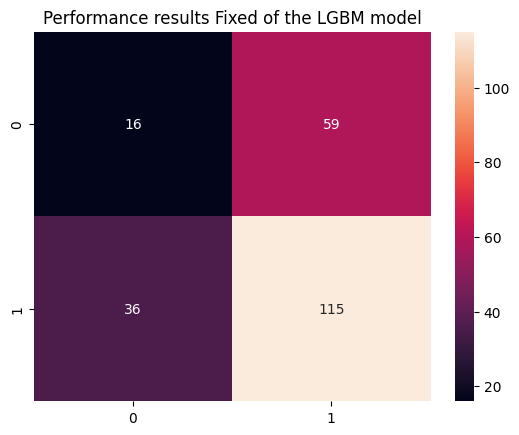


Feature Importance of the model



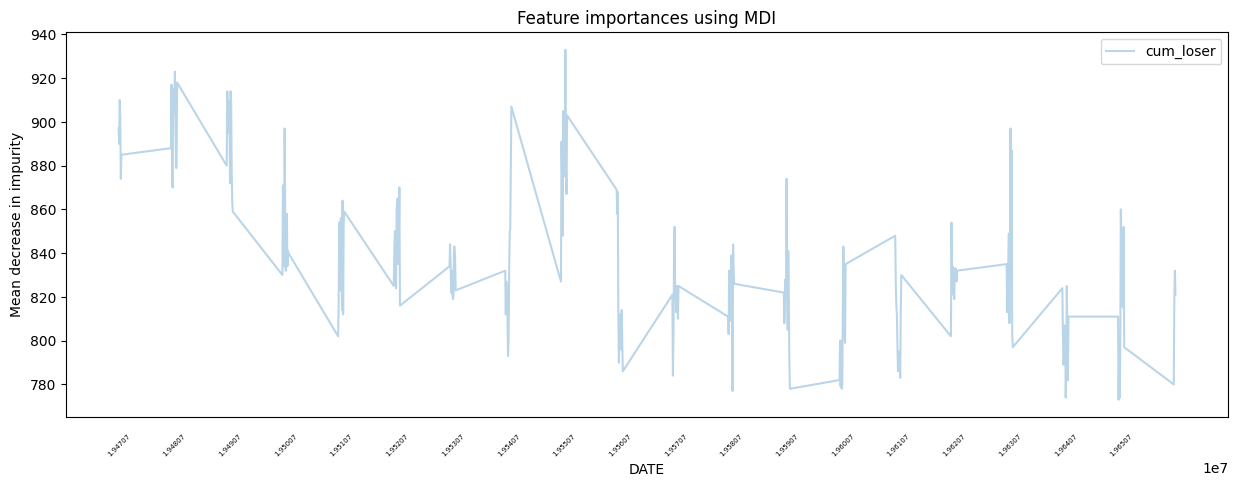

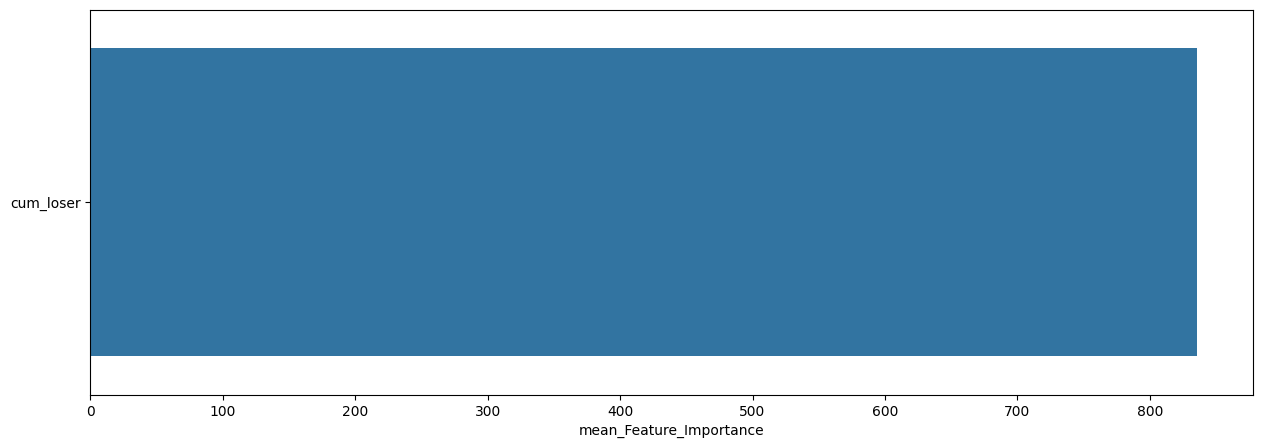

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                835.99115                     933   

           min_Feature_Importance  
cum_loser                     773


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.12      0.18        75
         1.0       0.67      0.89      0.77       151

    accuracy                           0.64       226
   macro avg       0.52      0.51      0.47       226
weighted avg       0.57      0.64      0.57       226


accuracy : 0.6371681415929203

precision : 0.6716417910447762

recall : 0.8940397350993378

F1-Score : 0.7670454545454546



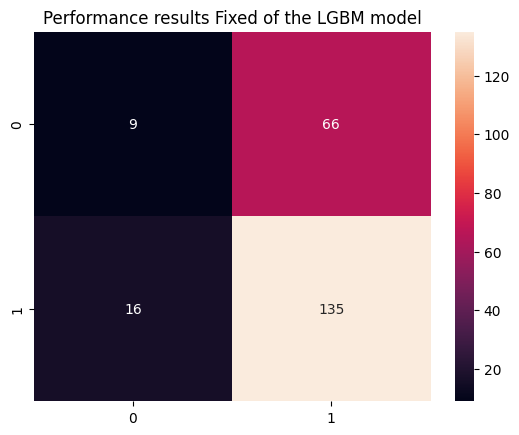


Feature Importance of the model



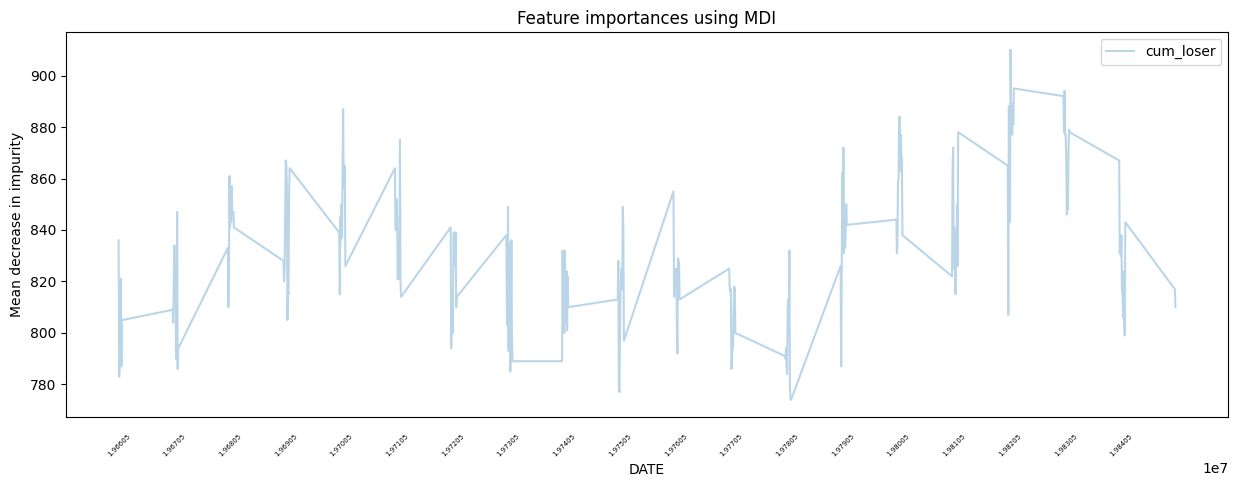

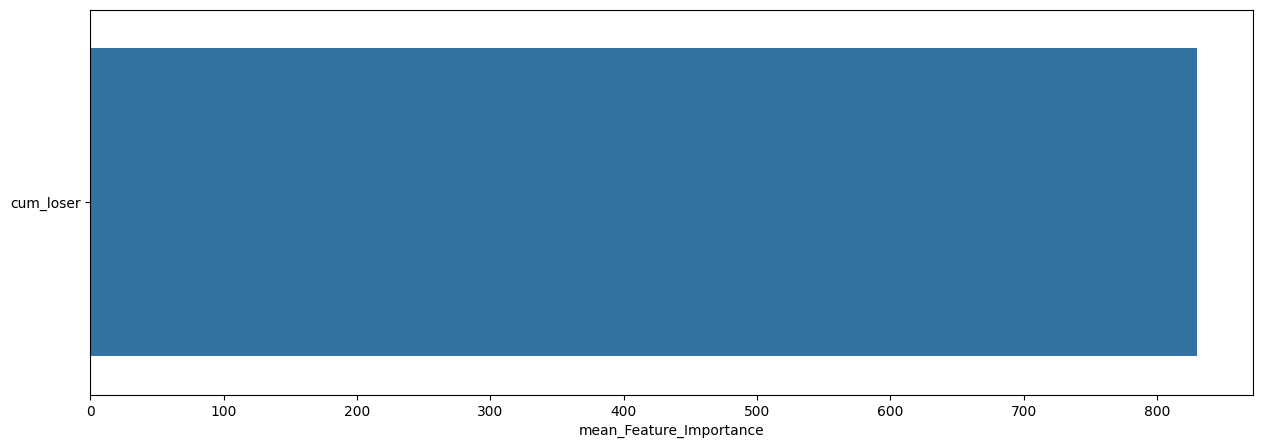

mean_Feature_Importance  max_Feature_Importance  \
cum_loser               830.349558                     910   

           min_Feature_Importance  
cum_loser                     774


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.16      0.22        70
         1.0       0.70      0.87      0.77       156

    accuracy                           0.65       226
   macro avg       0.53      0.51      0.50       226
weighted avg       0.59      0.65      0.60       226


accuracy : 0.6504424778761062

precision : 0.6974358974358974

recall : 0.8717948717948718

F1-Score : 0.774928774928775



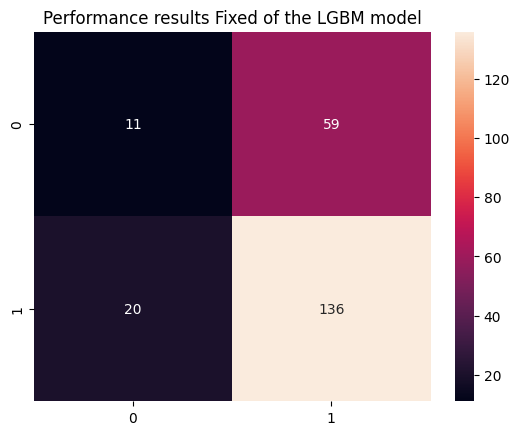


Feature Importance of the model



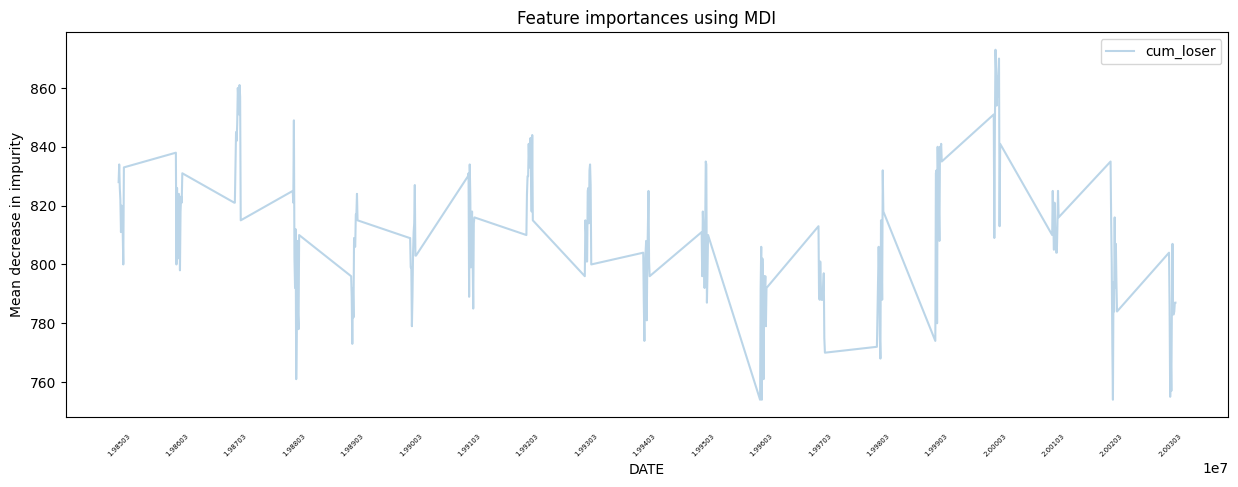

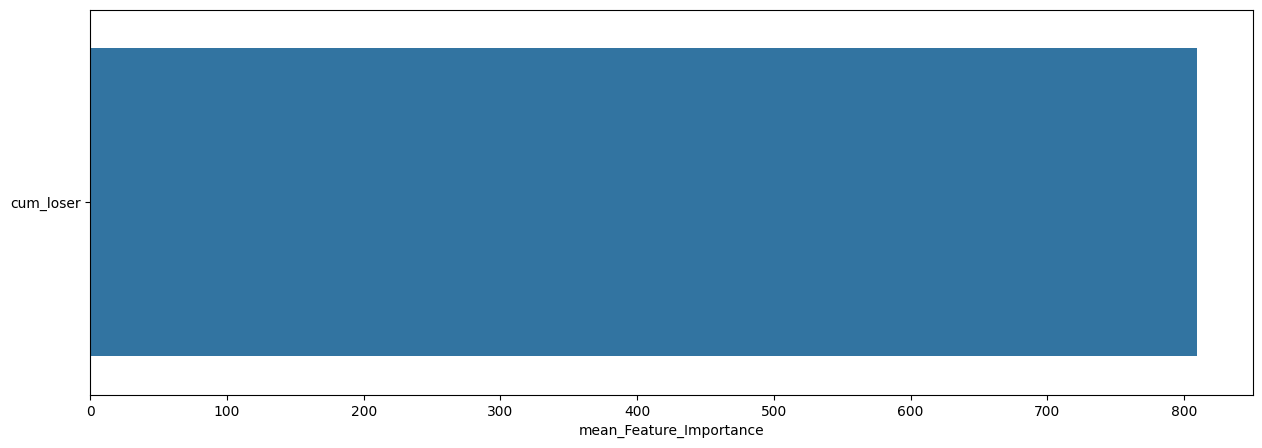

mean_Feature_Importance  max_Feature_Importance  \
cum_loser               809.915929                     873   

           min_Feature_Importance  
cum_loser                     754


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.16      0.23        96
         1.0       0.58      0.83      0.68       132

    accuracy                           0.55       228
   macro avg       0.49      0.49      0.45       228
weighted avg       0.50      0.55      0.49       228


accuracy : 0.5482456140350878

precision : 0.5759162303664922

recall : 0.8333333333333334

F1-Score : 0.6811145510835914



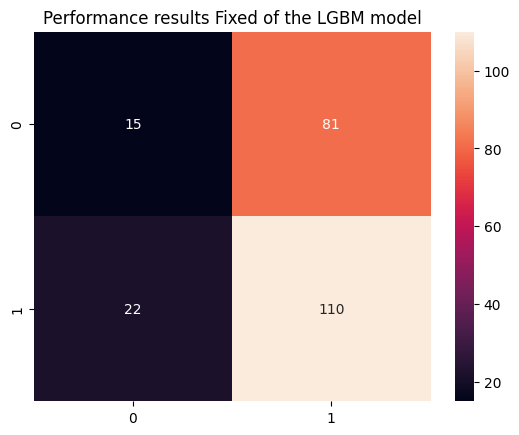


Feature Importance of the model



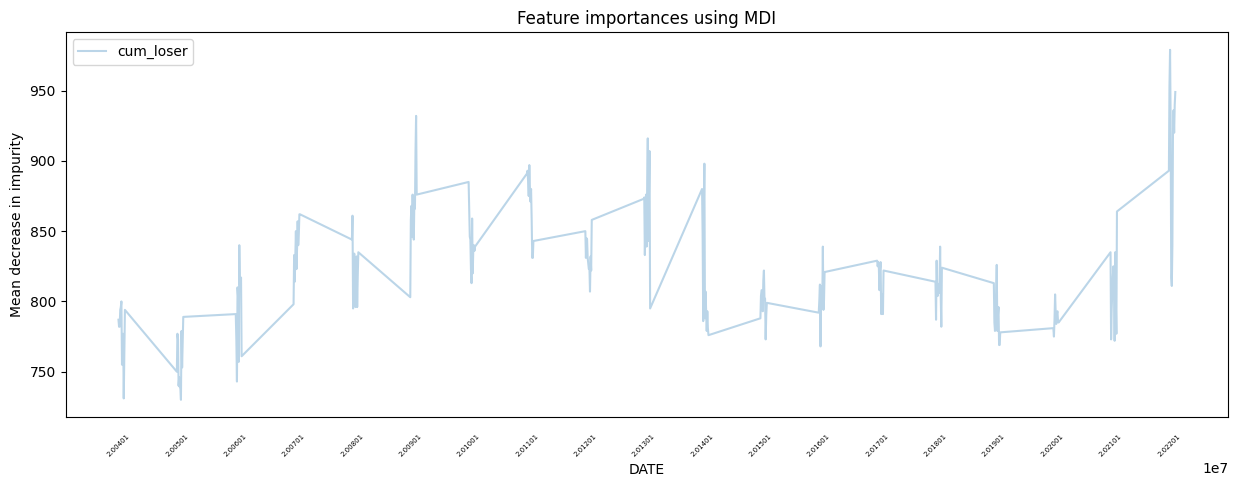

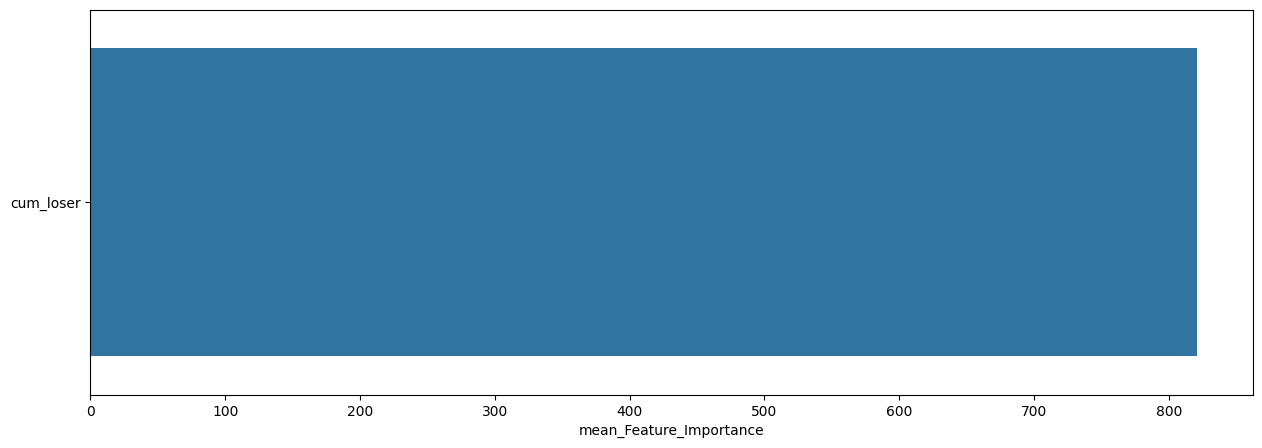

mean_Feature_Importance  max_Feature_Importance  \
cum_loser               821.254386                     979   

           min_Feature_Importance  
cum_loser                     730

In [109]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



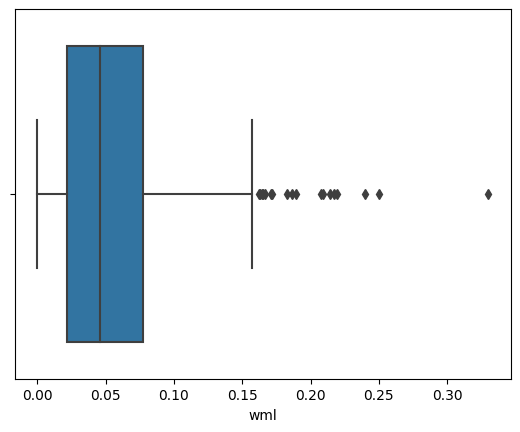

count      mean       std       min       25%       50%       75%  \
wml  496.0  0.055807  0.046442  0.000007  0.021945  0.045567  0.077301   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



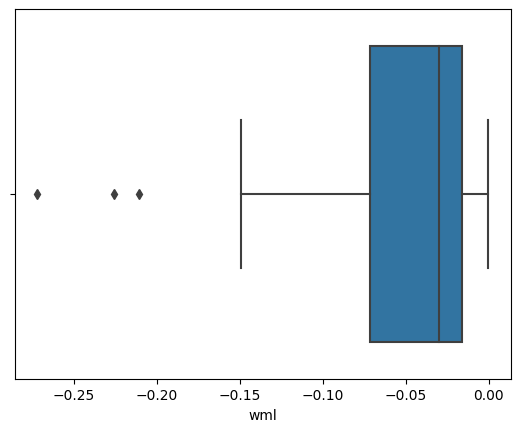

count      mean       std       min       25%       50%       75%  \
wml   51.0 -0.055185  0.059648 -0.271971 -0.071212 -0.030127 -0.016054   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



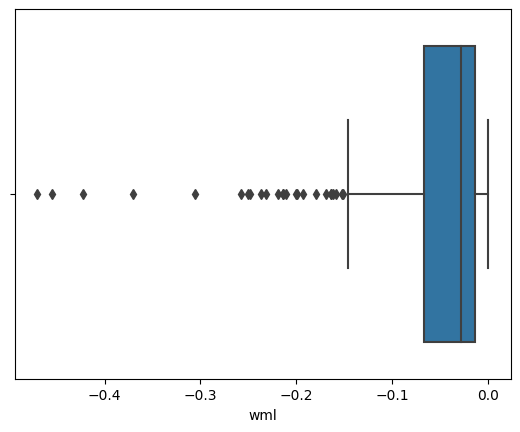

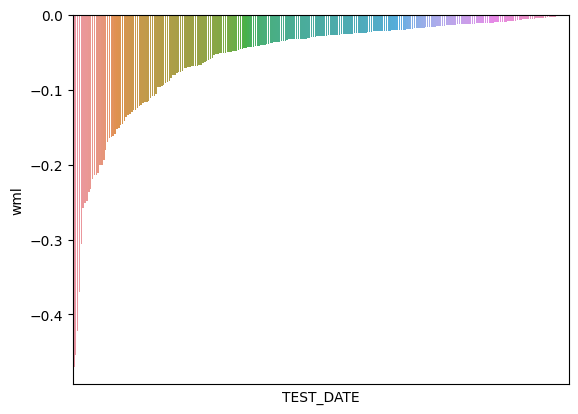

count      mean       std       min      25%       50%       75%  \
wml  265.0 -0.056528  0.073353 -0.469903 -0.06765 -0.028471 -0.014514   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



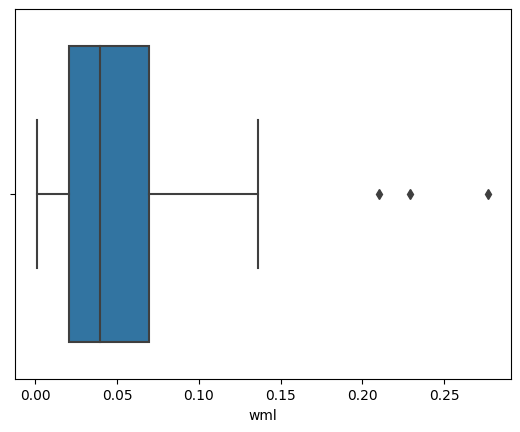

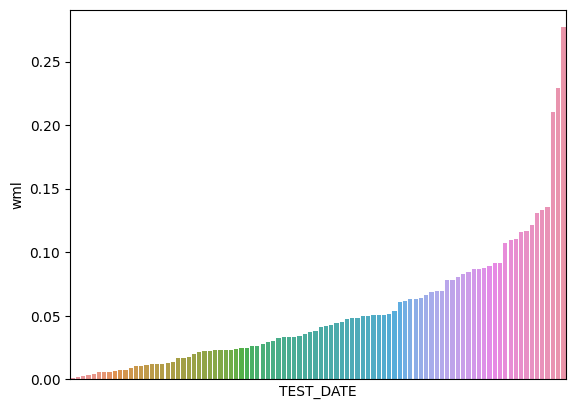

count     mean       std       min       25%       50%       75%  \
wml   94.0  0.05231  0.048862  0.001358  0.020412  0.039402  0.069521   

          max  
wml  0.276912

In [110]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.70869

최근 누적 수익률

  2022년-12월 -> 24275.65
  2022년-11월 -> 21871.84
  2022년-10월 -> 21871.84
  2022년-09월 -> 19367.12
  2022년-08월 -> 17607.50

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2001년-09월 -> 42747.14
  2등 : 2000년-12월 -> 42651.95
  3등 : 2002년-09월 -> 42407.36
  4등 : 2002년-07월 -> 36927.71
  5등 : 2000년-02월 -> 36351.59
  6등 : 2002년-08월 -> 35857.85
  7등 : 2000년-10월 -> 35569.54
  8등 : 2001년-08월 -> 35405.02
  9등 : 2000년-11월 -> 35132.71
  10등 : 2002년-06월 -> 35012.36



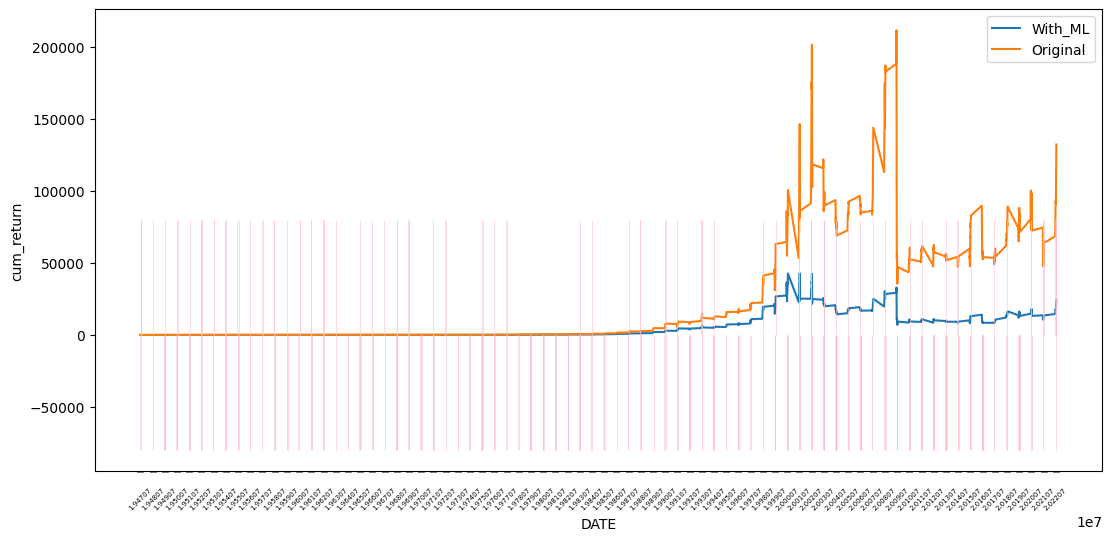

In [111]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.73853

최근 누적 수익률

  2022년-12월 -> 9089.40
  2022년-11월 -> 8242.04
  2022년-10월 -> 8088.17
  2022년-09월 -> 7278.06
  2022년-08월 -> 6812.79

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 9089.40
  2등 : 2009년-02월 -> 8286.94
  3등 : 2022년-11월 -> 8242.04
  4등 : 2022년-10월 -> 8088.17
  5등 : 2009년-01월 -> 7714.13
  6등 : 2008년-11월 -> 7698.90
  7등 : 2008년-12월 -> 7580.60
  8등 : 2022년-09월 -> 7278.06
  9등 : 2008년-06월 -> 7264.26
  10등 : 2020년-09월 -> 7217.47



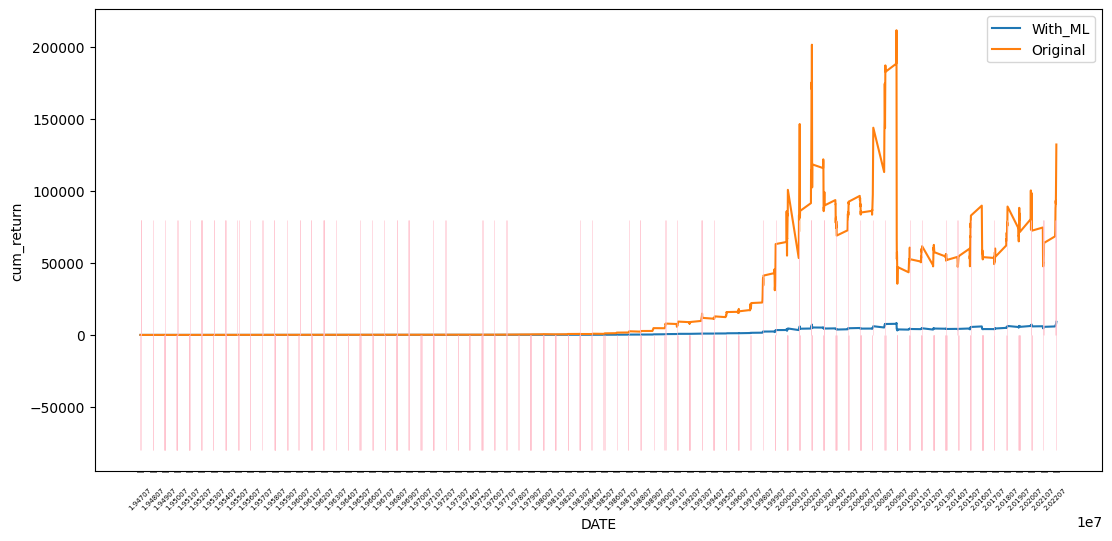

In [112]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [113]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.36      0.35       316
         1.0       0.64      0.61      0.63       590

    accuracy                           0.52       906
   macro avg       0.49      0.49      0.49       906
weighted avg       0.53      0.52      0.53       906


accuracy : 0.5242825607064018

precision : 0.6417112299465241

recall : 0.6101694915254238

F1-Score : 0.6255430060816681



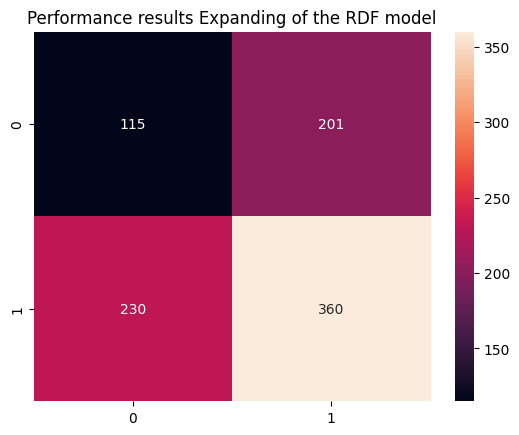


Feature Importance of the model



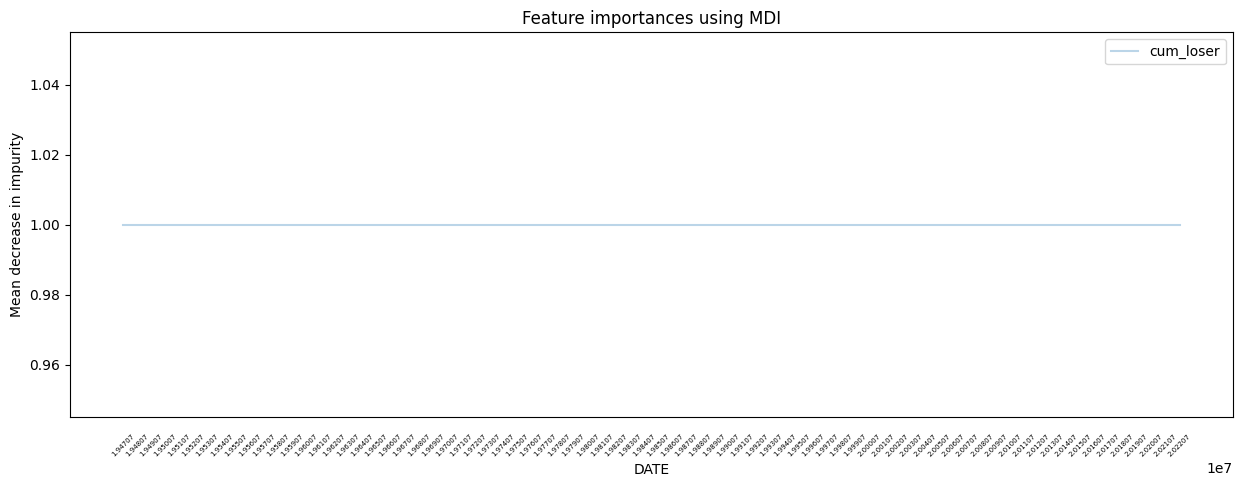

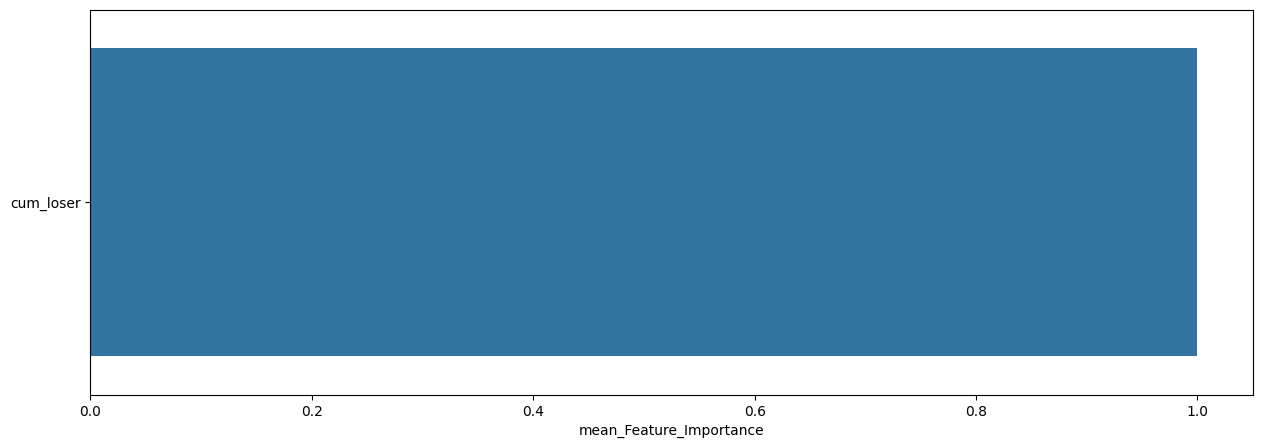

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [114]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.44      0.39        75
         1.0       0.68      0.59      0.63       151

    accuracy                           0.54       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.54      0.55       226


accuracy : 0.5398230088495575

precision : 0.6793893129770993

recall : 0.5894039735099338

F1-Score : 0.6312056737588653



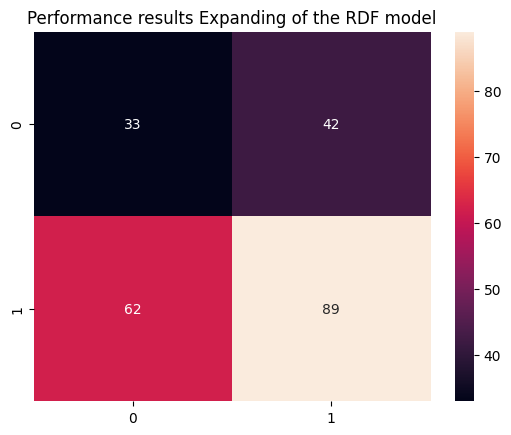


Feature Importance of the model



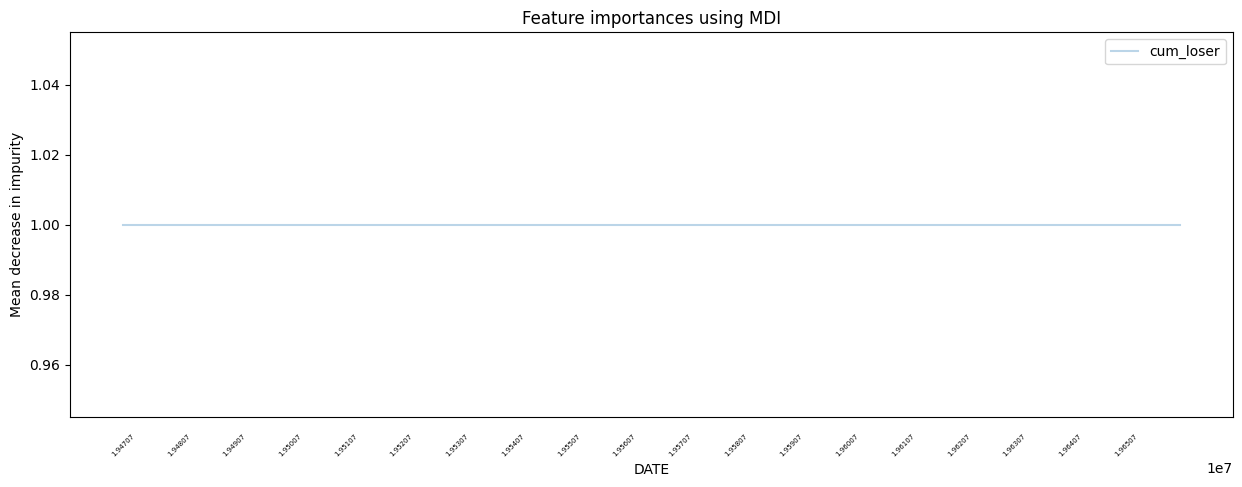

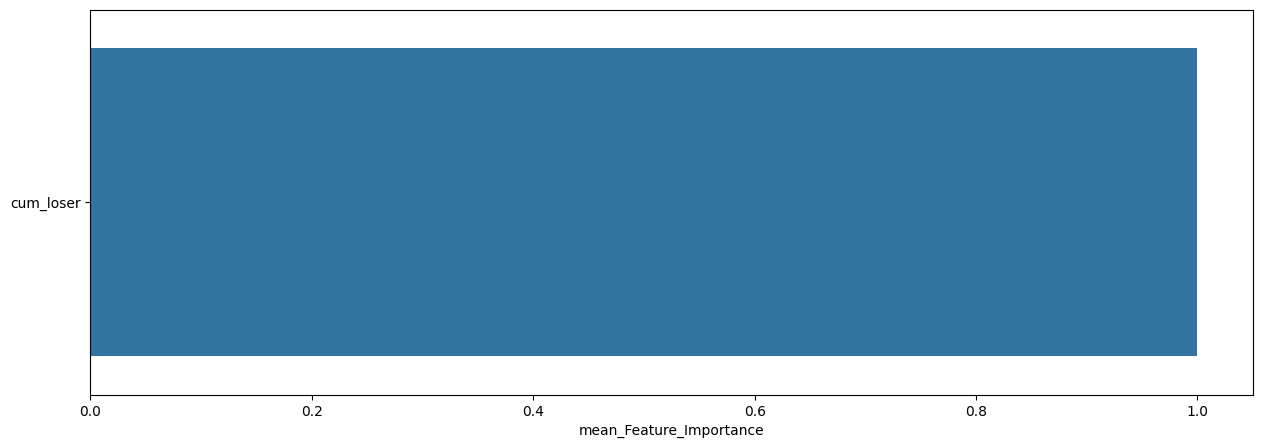

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.37      0.34        75
         1.0       0.66      0.60      0.63       151

    accuracy                           0.53       226
   macro avg       0.49      0.49      0.49       226
weighted avg       0.55      0.53      0.53       226


accuracy : 0.5265486725663717

precision : 0.6594202898550725

recall : 0.6026490066225165

F1-Score : 0.629757785467128



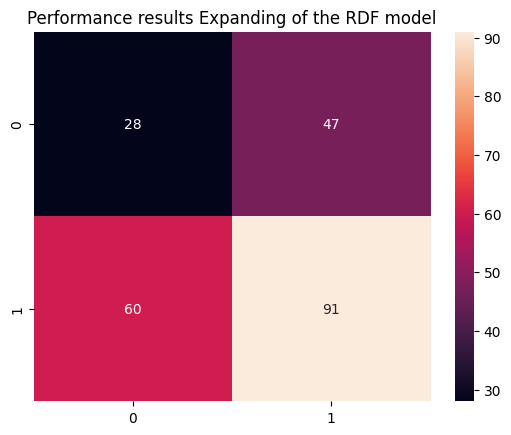


Feature Importance of the model



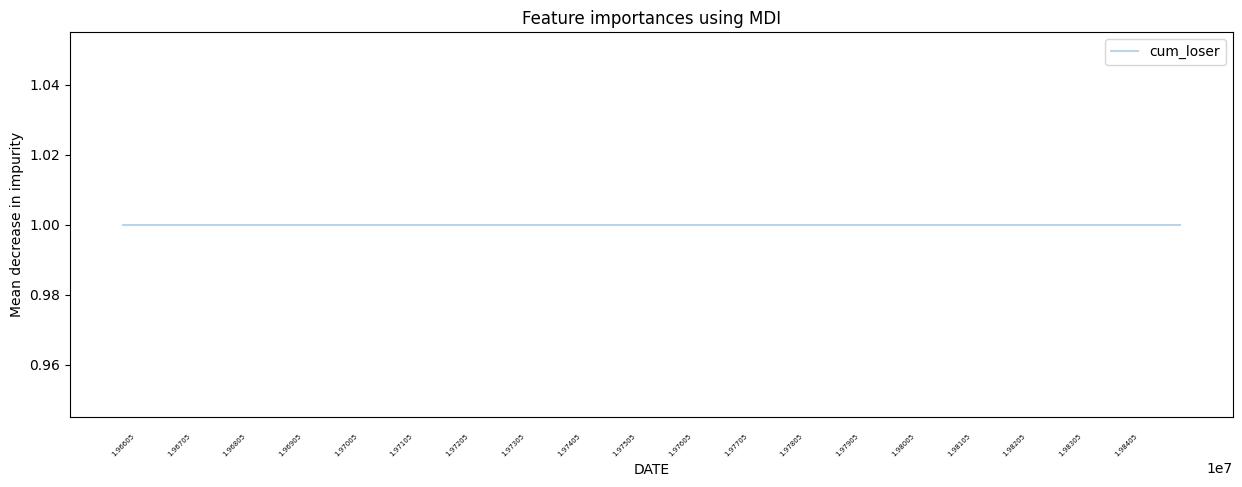

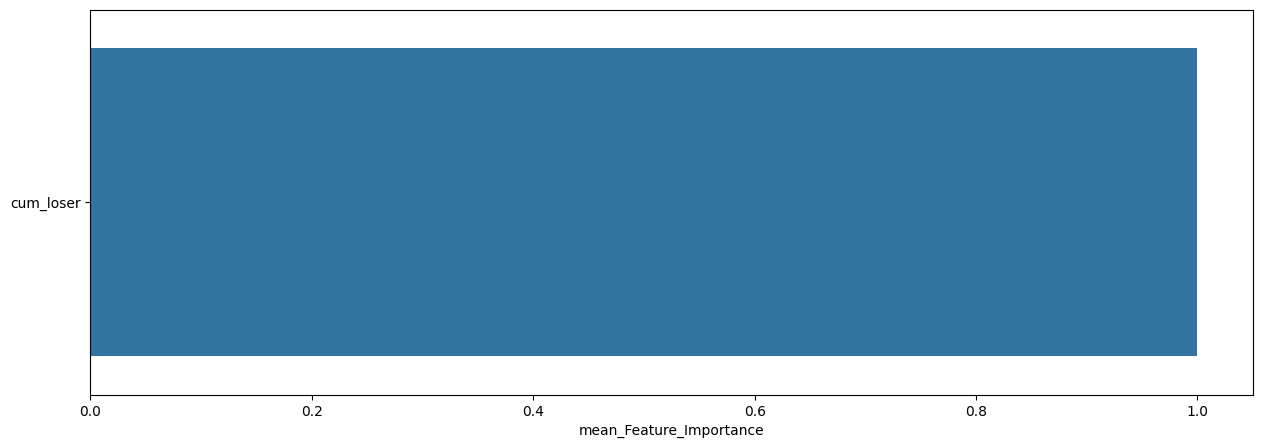

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.40      0.36        70
         1.0       0.70      0.63      0.67       156

    accuracy                           0.56       226
   macro avg       0.52      0.52      0.51       226
weighted avg       0.59      0.56      0.57       226


accuracy : 0.5619469026548672

precision : 0.7021276595744681

recall : 0.6346153846153846

F1-Score : 0.6666666666666666



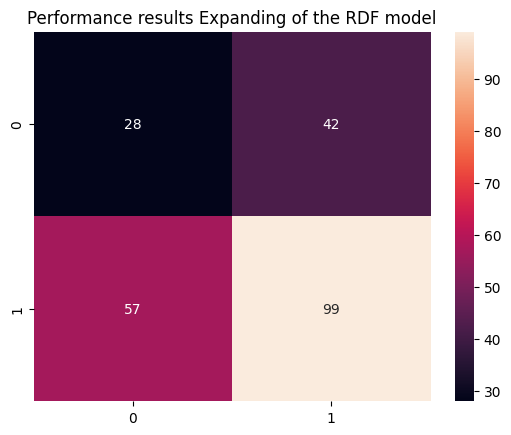


Feature Importance of the model



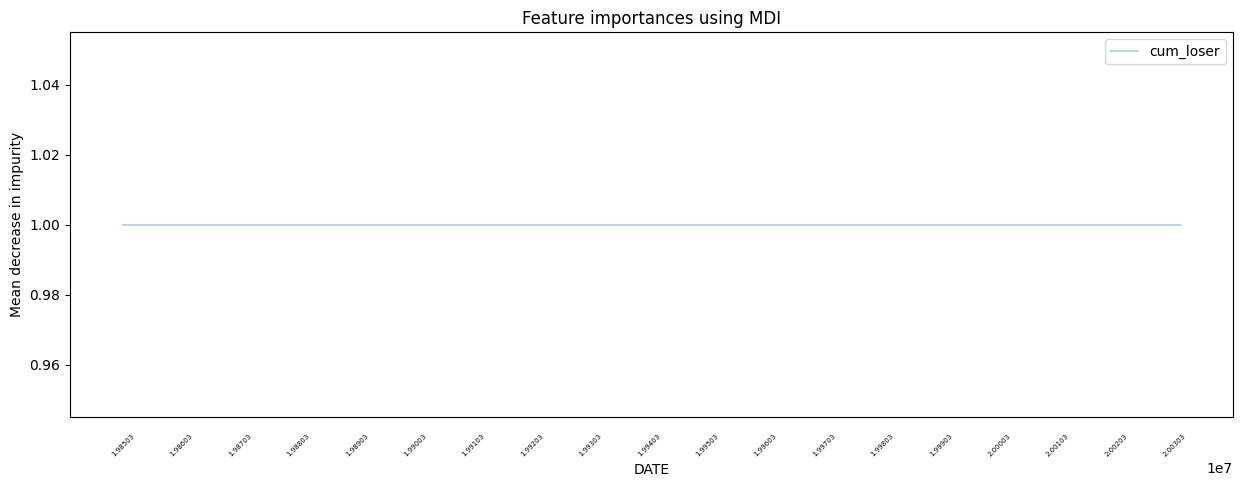

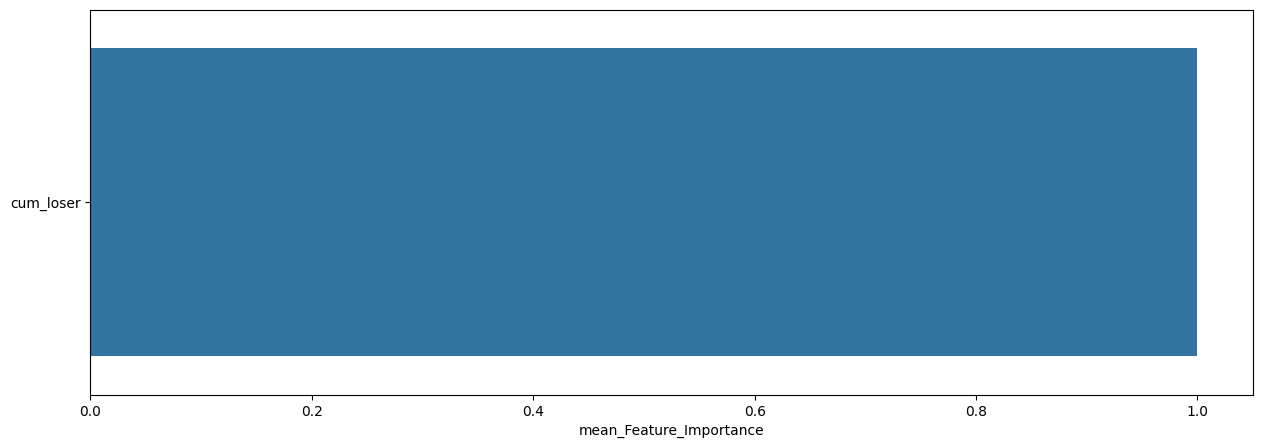

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.27      0.30        96
         1.0       0.54      0.61      0.57       132

    accuracy                           0.47       228
   macro avg       0.44      0.44      0.44       228
weighted avg       0.45      0.47      0.46       228


accuracy : 0.4692982456140351

precision : 0.5364238410596026

recall : 0.6136363636363636

F1-Score : 0.5724381625441696



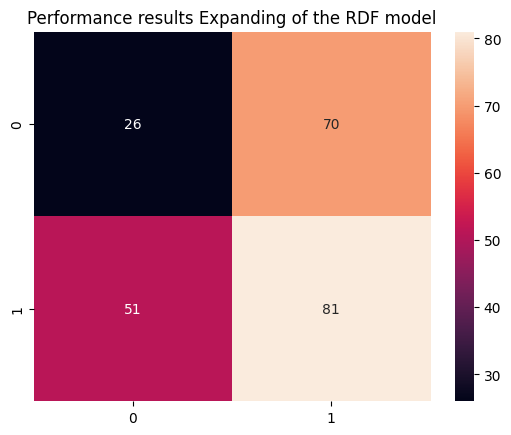


Feature Importance of the model



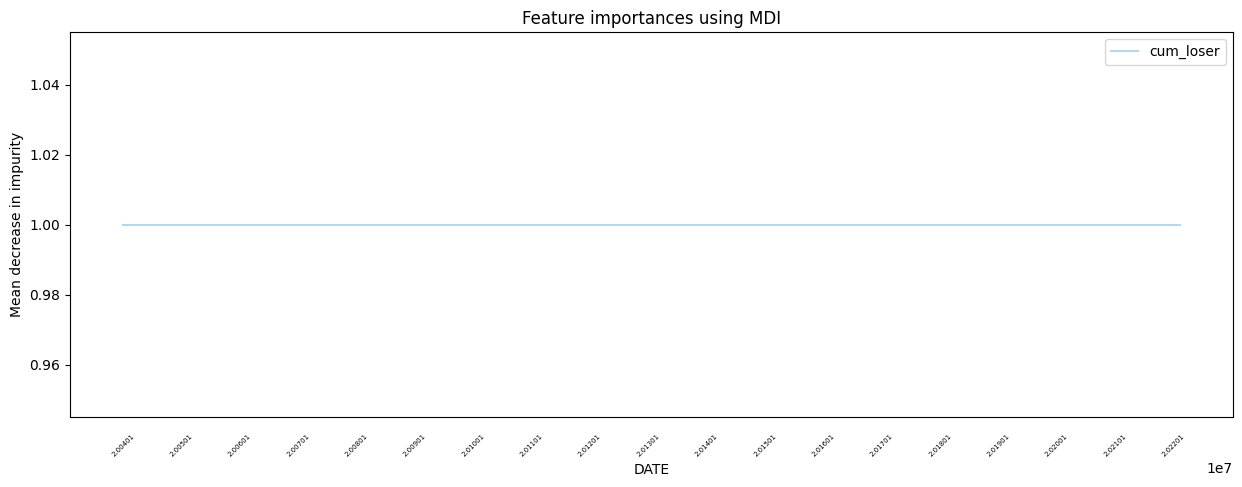

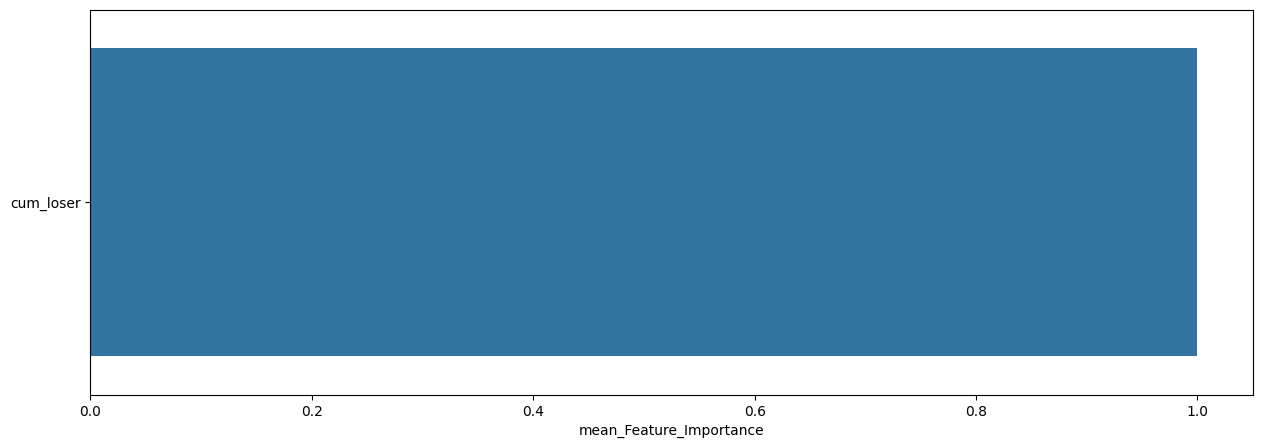

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [115]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



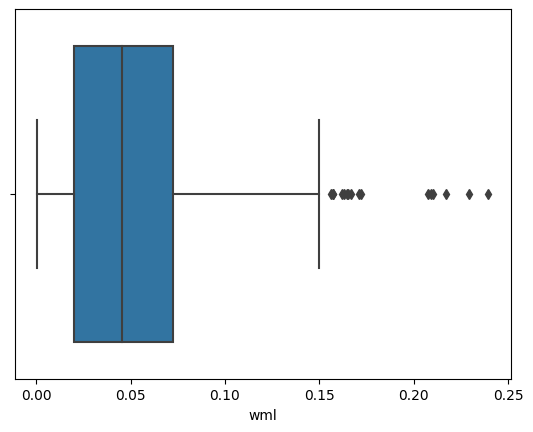

count      mean       std       min       25%       50%       75%  \
wml  360.0  0.053451  0.044427  0.000577  0.020054  0.045208  0.072495   

          max  
wml  0.239571


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



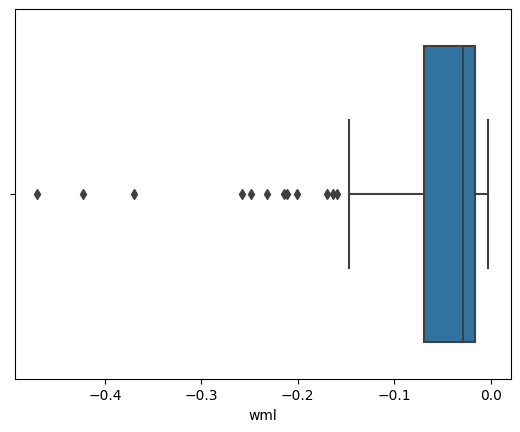

count      mean       std       min       25%       50%       75%  \
wml  115.0 -0.061108  0.082127 -0.469903 -0.068653 -0.028629 -0.016258   

          max  
wml -0.002394


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



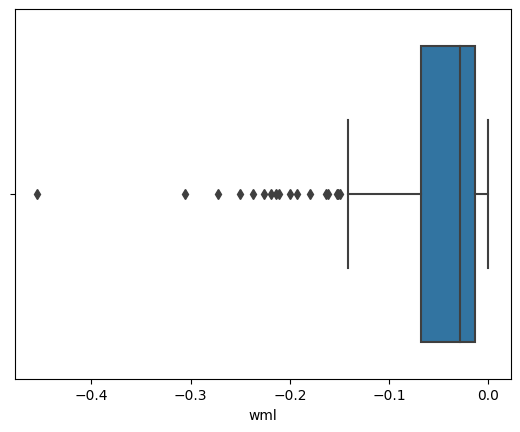

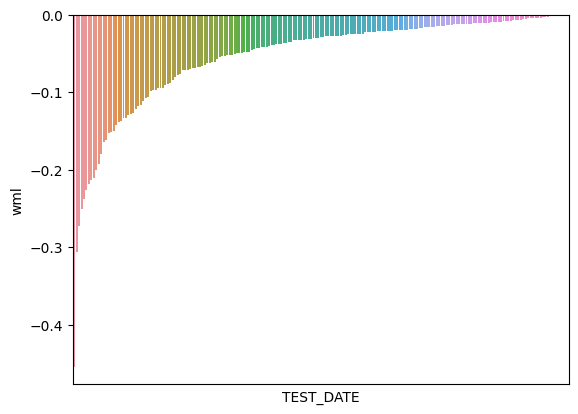

count      mean       std       min       25%       50%      75%  \
wml  201.0 -0.053566  0.064241 -0.454349 -0.067845 -0.028471 -0.01379   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



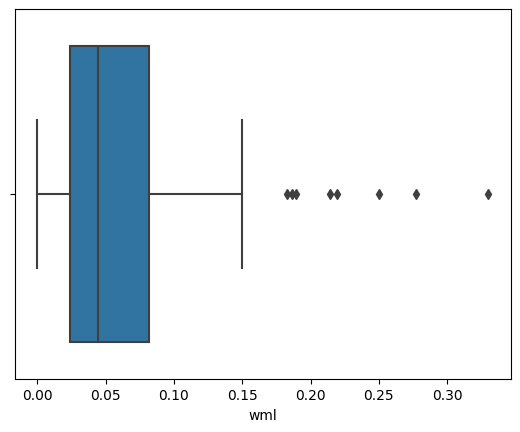

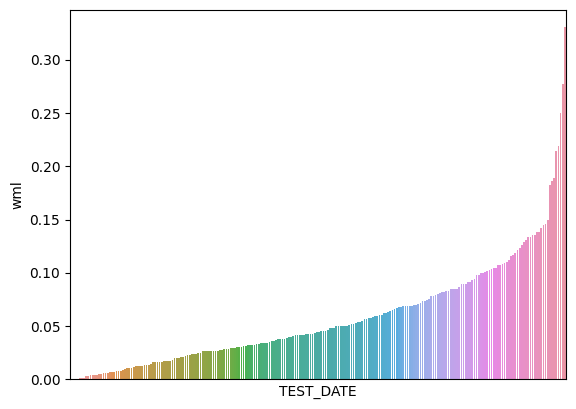

count      mean       std       min       25%       50%       75%  \
wml  230.0  0.058065  0.050287  0.000007  0.023919  0.044367  0.081836   

          max  
wml  0.330163

In [116]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.76002

최근 누적 수익률

  2022년-12월 -> 934.13
  2022년-11월 -> 841.54
  2022년-10월 -> 800.43
  2022년-09월 -> 708.66
  2022년-08월 -> 644.19

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 1682.50
  2등 : 2009년-01월 -> 1682.50
  3등 : 2008년-12월 -> 1682.50
  4등 : 2008년-11월 -> 1682.50
  5등 : 2009년-03월 -> 1682.50
  6등 : 2008년-07월 -> 1558.82
  7등 : 2008년-06월 -> 1558.82
  8등 : 2008년-10월 -> 1534.21
  9등 : 2008년-08월 -> 1534.21
  10등 : 2008년-09월 -> 1534.21



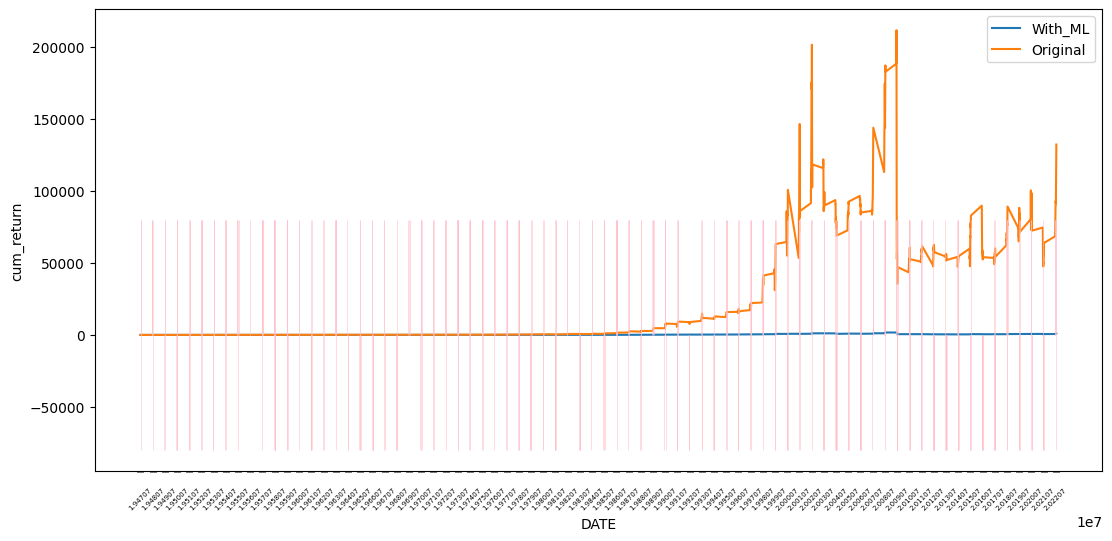

In [117]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.77625

최근 누적 수익률

  2022년-12월 -> 1867.05
  2022년-11월 -> 1697.22
  2022년-10월 -> 1639.98
  2022년-09월 -> 1453.73
  2022년-08월 -> 1365.01

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 1941.25
  2등 : 2008년-11월 -> 1929.11
  3등 : 2009년-01월 -> 1917.65
  4등 : 2008년-12월 -> 1915.87
  5등 : 2022년-12월 -> 1867.05
  6등 : 2008년-06월 -> 1807.44
  7등 : 2008년-10월 -> 1759.10
  8등 : 2008년-09월 -> 1748.74
  9등 : 2008년-07월 -> 1703.78
  10등 : 2022년-11월 -> 1697.22



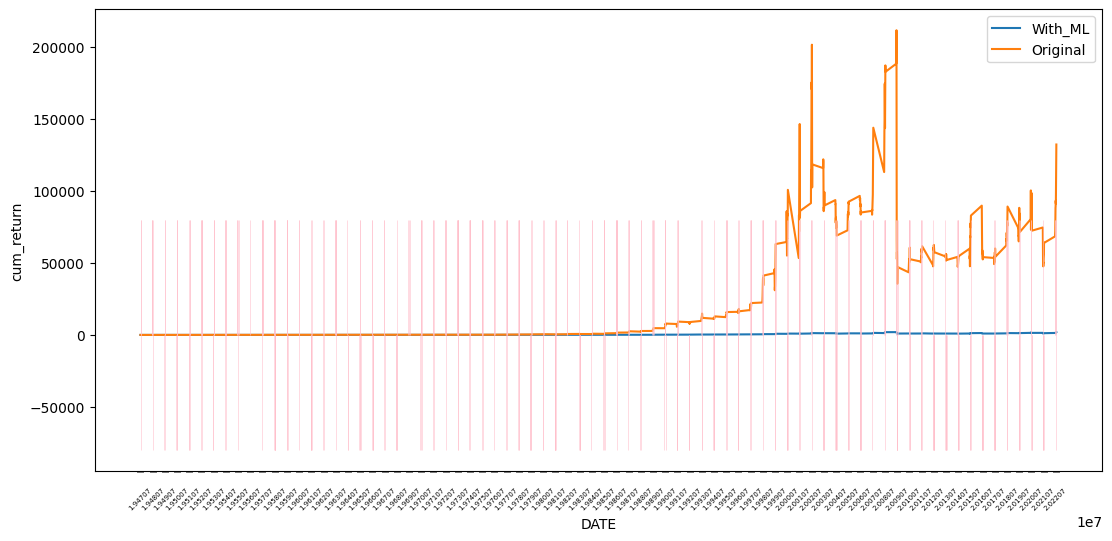

In [118]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [119]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.14      0.20       316
         1.0       0.65      0.86      0.74       590

    accuracy                           0.61       906
   macro avg       0.50      0.50      0.47       906
weighted avg       0.54      0.61      0.55       906


accuracy : 0.6059602649006622

precision : 0.6499356499356499

recall : 0.8559322033898306

F1-Score : 0.7388441843452817



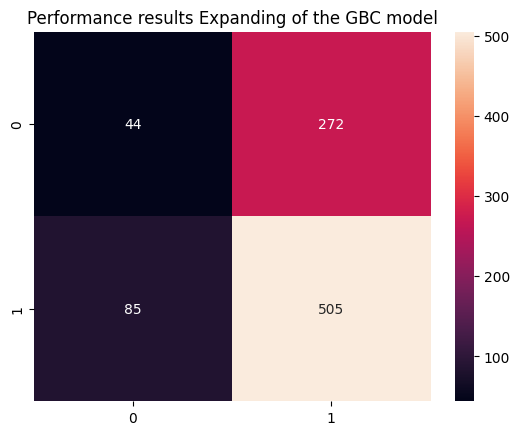


Feature Importance of the model



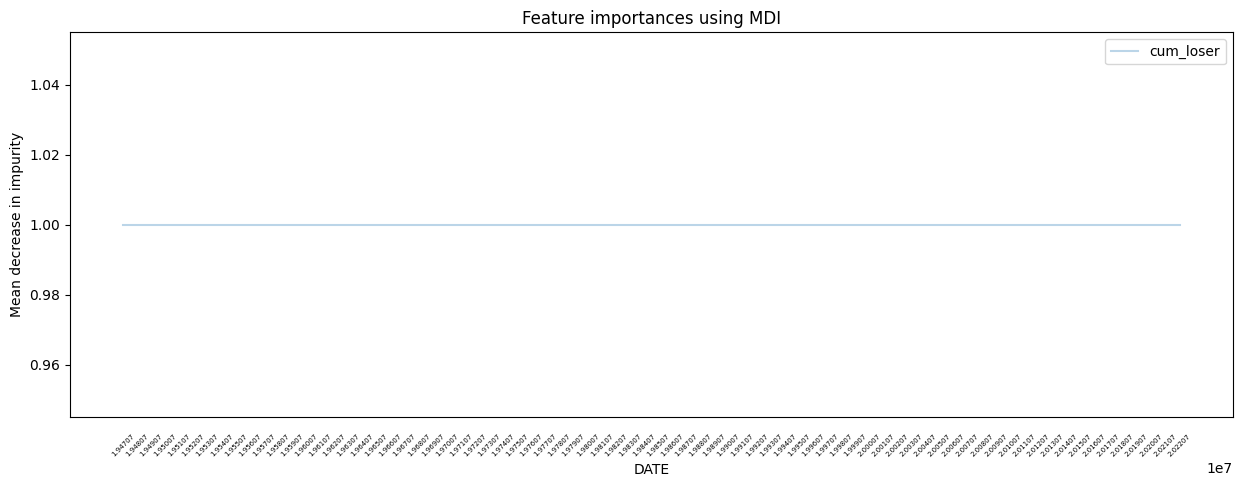

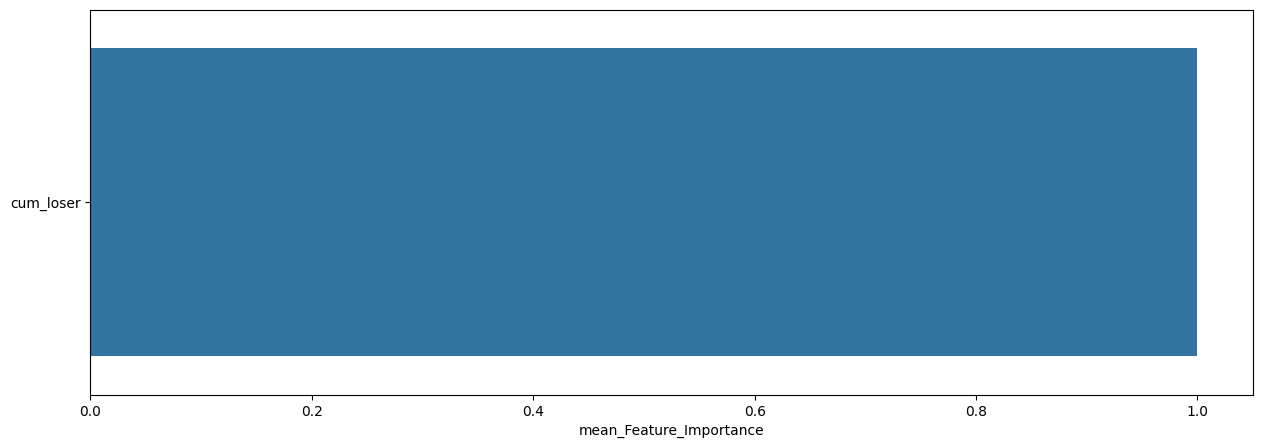

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [120]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.24      0.30        75
         1.0       0.68      0.81      0.74       151

    accuracy                           0.62       226
   macro avg       0.54      0.53      0.52       226
weighted avg       0.59      0.62      0.60       226


accuracy : 0.6238938053097345

precision : 0.6833333333333333

recall : 0.8145695364238411

F1-Score : 0.743202416918429



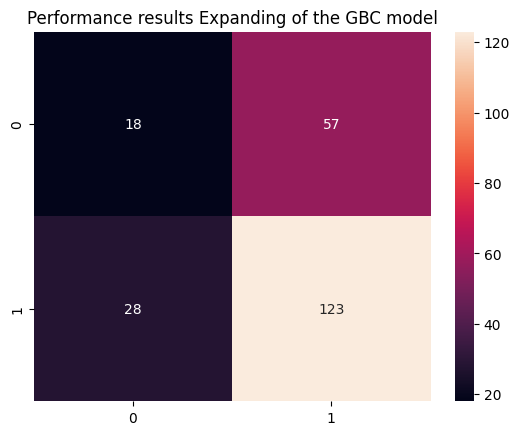


Feature Importance of the model



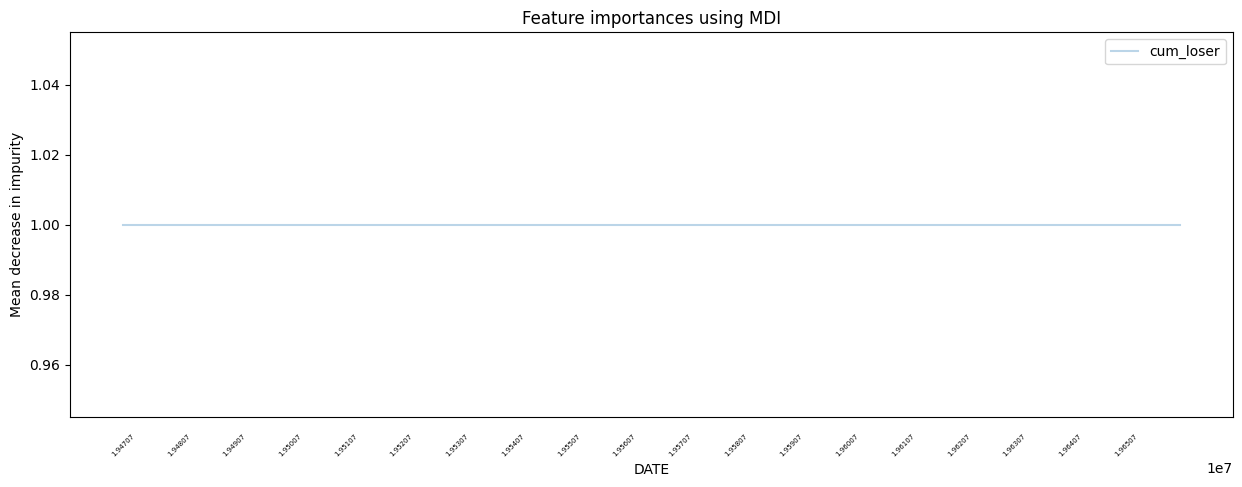

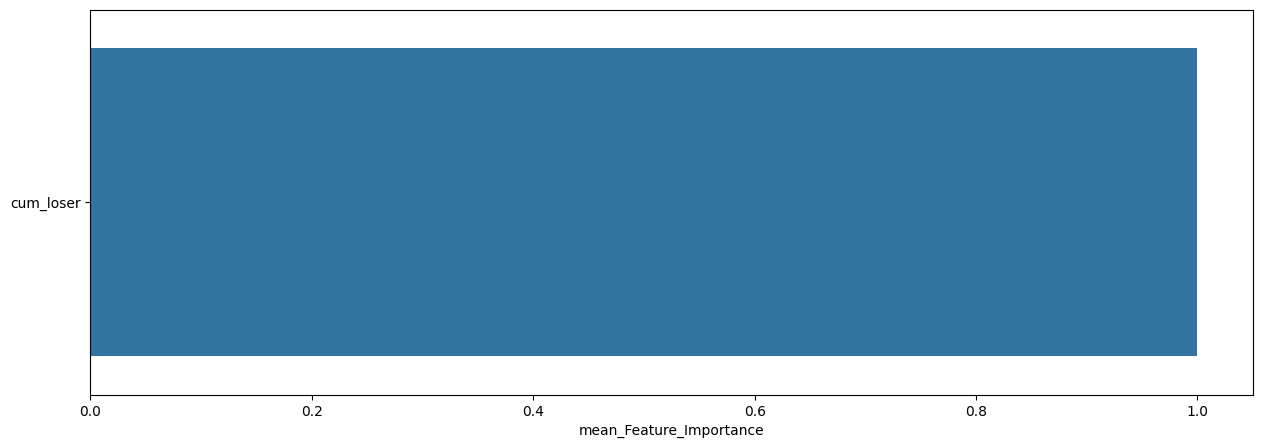

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.13      0.19        75
         1.0       0.66      0.85      0.74       151

    accuracy                           0.61       226
   macro avg       0.48      0.49      0.46       226
weighted avg       0.54      0.61      0.56       226


accuracy : 0.6106194690265486

precision : 0.6632124352331606

recall : 0.847682119205298

F1-Score : 0.7441860465116279



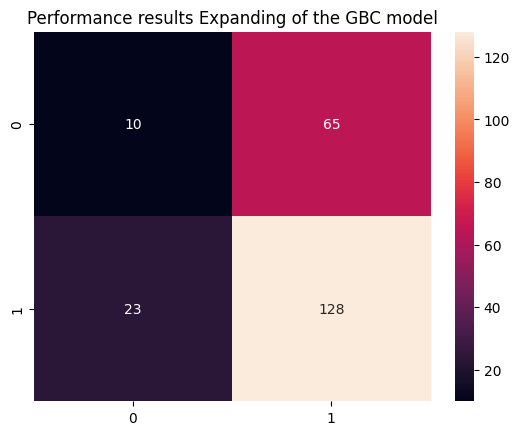


Feature Importance of the model



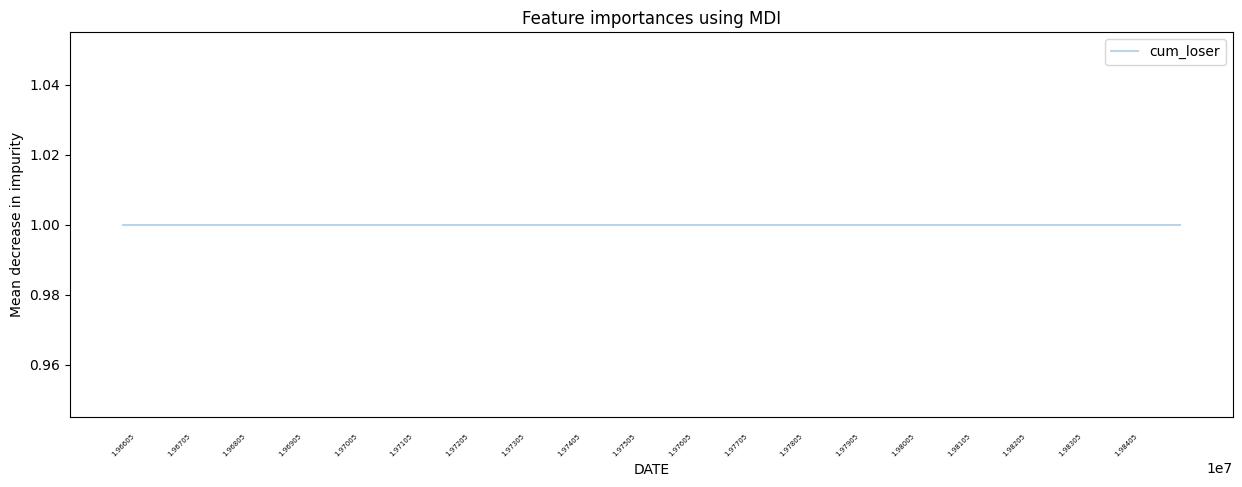

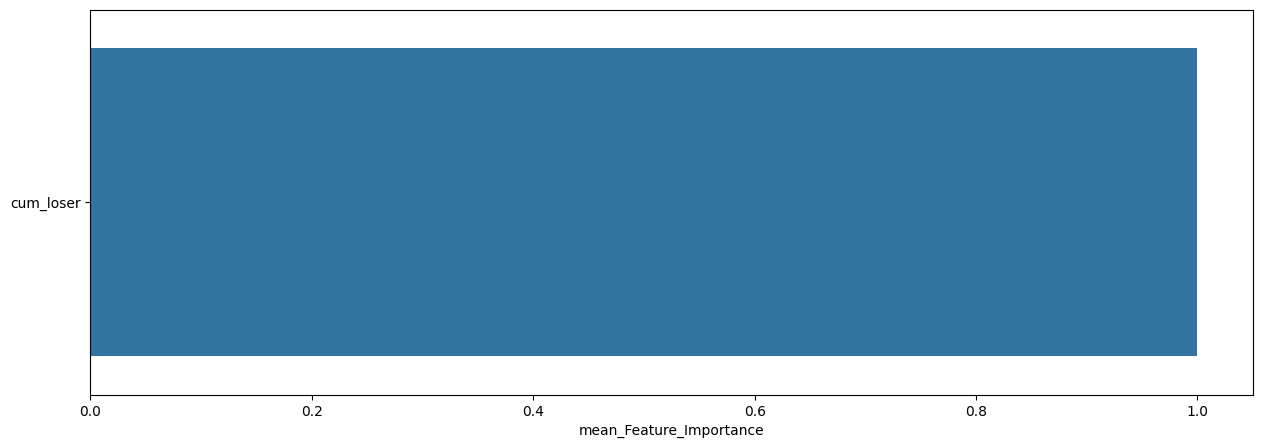

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.20      0.27        70
         1.0       0.71      0.87      0.78       156

    accuracy                           0.66       226
   macro avg       0.56      0.54      0.53       226
weighted avg       0.62      0.66      0.62       226


accuracy : 0.6637168141592921

precision : 0.7083333333333334

recall : 0.8717948717948718

F1-Score : 0.7816091954022988



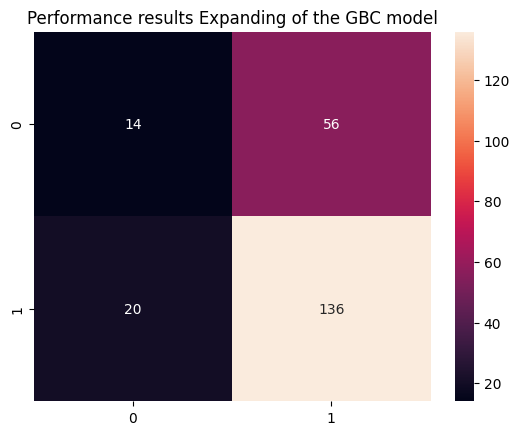


Feature Importance of the model



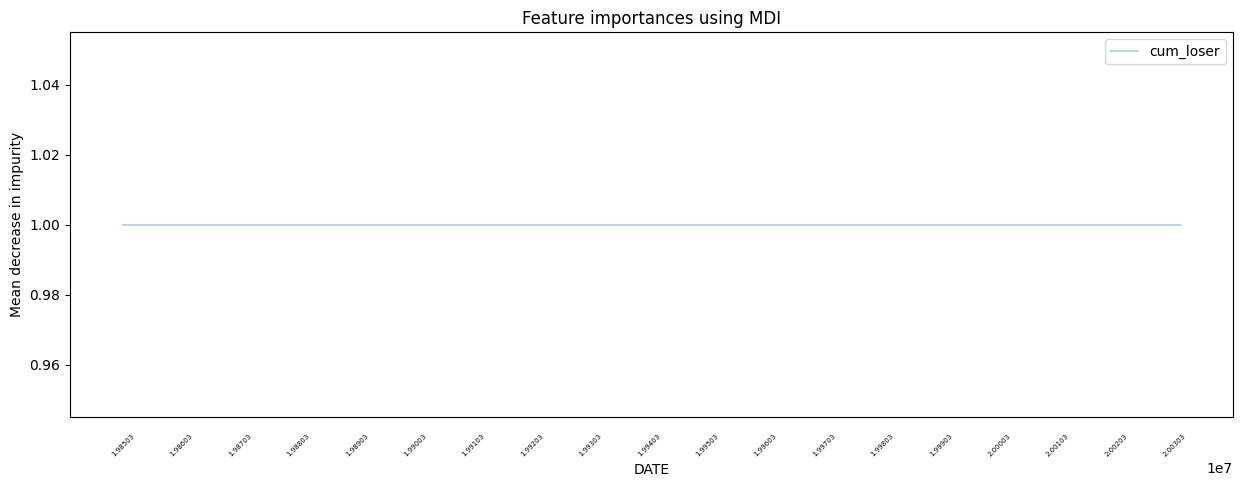

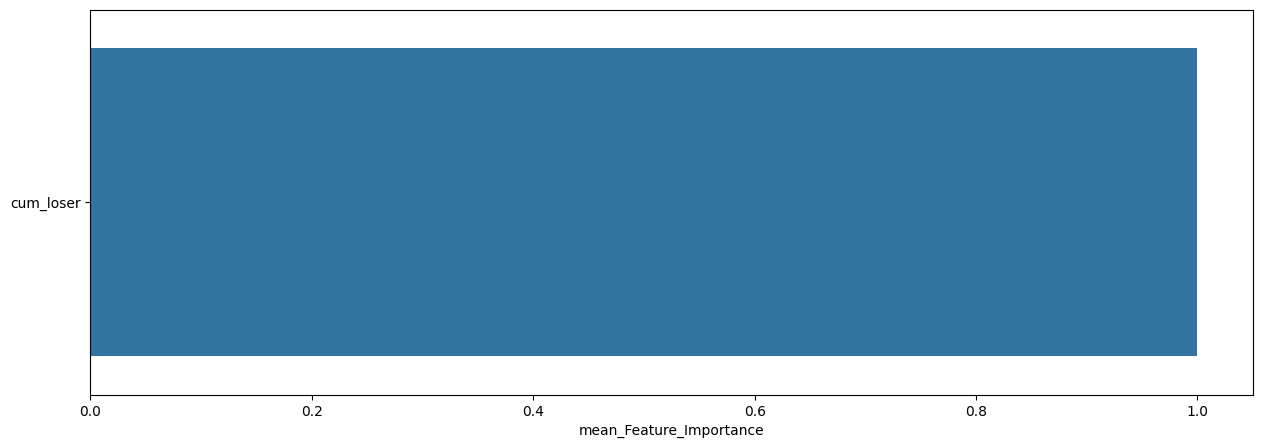

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.12      0.02      0.04        96
         1.0       0.56      0.89      0.69       132

    accuracy                           0.53       228
   macro avg       0.34      0.46      0.36       228
weighted avg       0.37      0.53      0.41       228


accuracy : 0.5263157894736842

precision : 0.5566037735849056

recall : 0.8939393939393939

F1-Score : 0.686046511627907



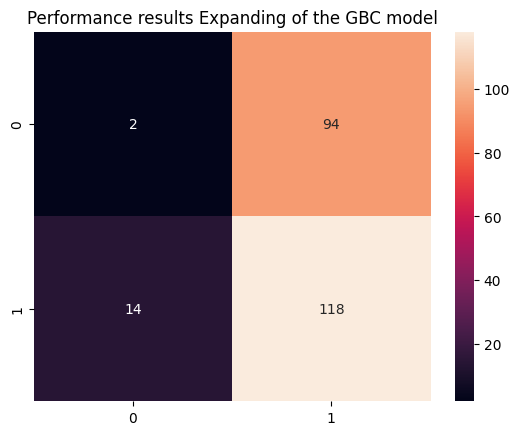


Feature Importance of the model



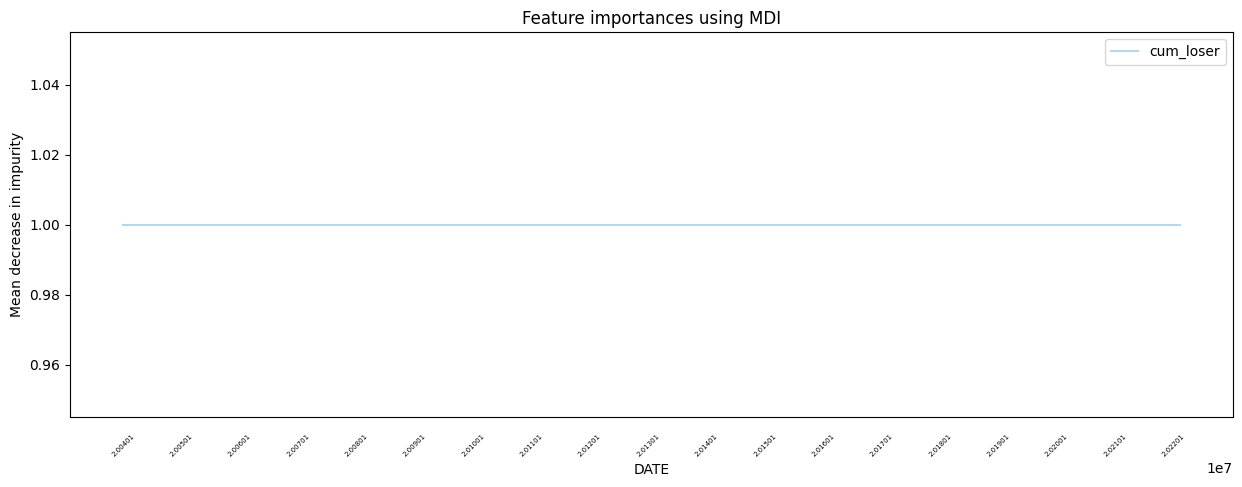

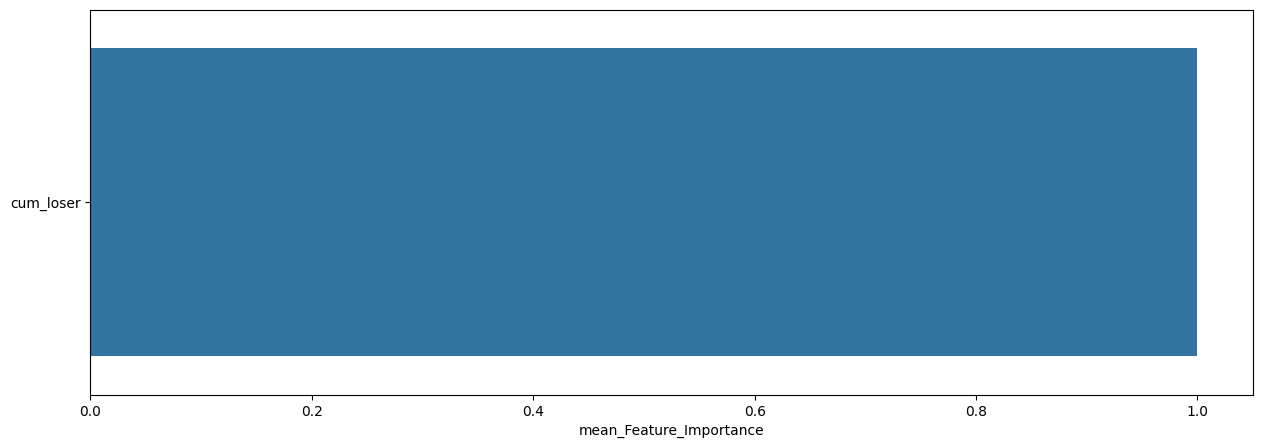

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [121]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



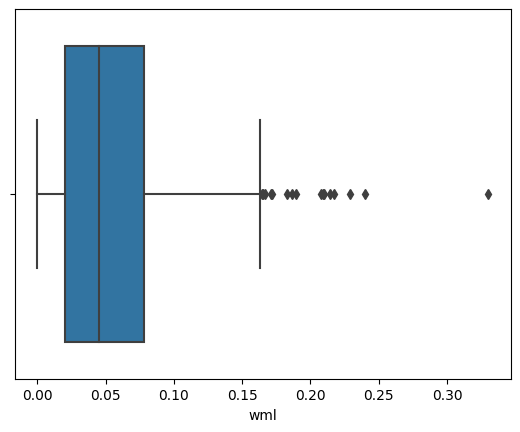

count     mean       std       min       25%       50%       75%  \
wml  505.0  0.05486  0.045876  0.000128  0.020483  0.045201  0.077913   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



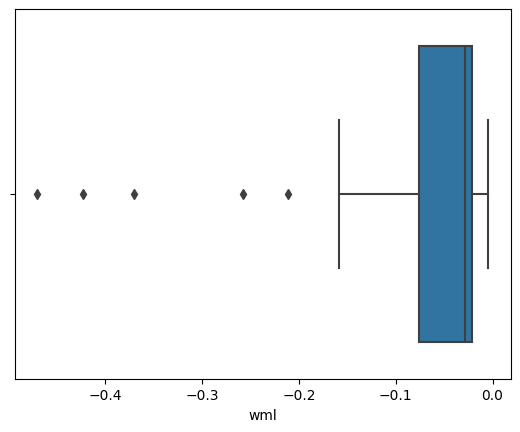

count      mean       std       min       25%     50%       75%       max
wml   44.0 -0.078428  0.109068 -0.469903 -0.076281 -0.0288 -0.020748 -0.004375


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



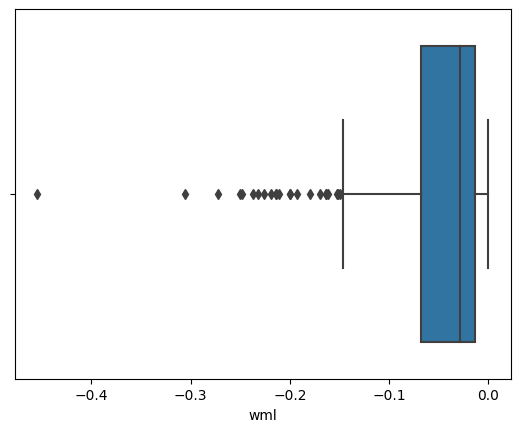

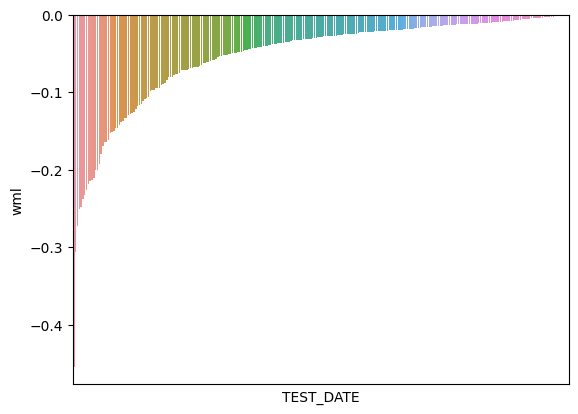

count      mean       std       min       25%       50%      75%  \
wml  272.0 -0.052733  0.062598 -0.454349 -0.067487 -0.028415 -0.01352   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



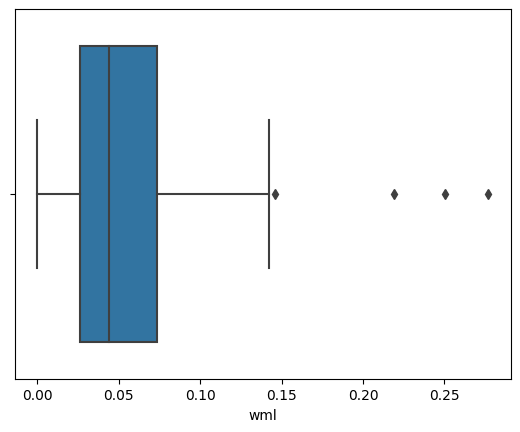

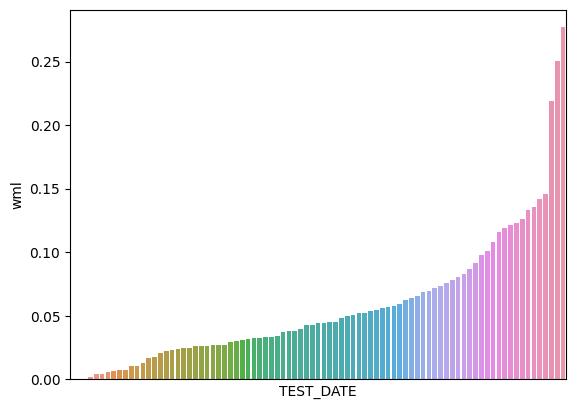

count      mean       std       min       25%       50%       75%  \
wml   85.0  0.057568  0.052262  0.000007  0.026238  0.044267  0.073302   

          max  
wml  0.276912

In [122]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.68323

최근 누적 수익률

  2022년-12월 -> 66435.82
  2022년-11월 -> 59857.41
  2022년-10월 -> 56936.99
  2022년-09월 -> 50416.86
  2022년-08월 -> 45836.34

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-06월 -> 81479.40
  2등 : 2007년-12월 -> 74661.87
  3등 : 2008년-11월 -> 73537.57
  4등 : 2009년-02월 -> 71796.98
  5등 : 2008년-12월 -> 71796.98
  6등 : 2009년-01월 -> 71796.98
  7등 : 2009년-03월 -> 71796.98
  8등 : 2008년-05월 -> 69962.93
  9등 : 2008년-04월 -> 69962.93
  10등 : 2007년-11월 -> 69317.60



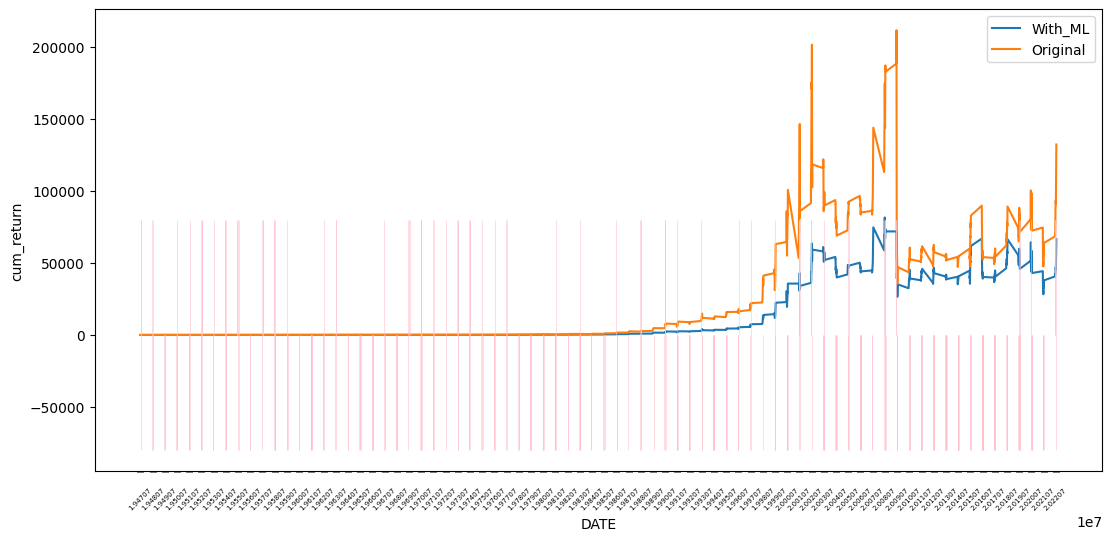

In [123]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73634

최근 누적 수익률

  2022년-12월 -> 4837.30
  2022년-11월 -> 4429.25
  2022년-10월 -> 4275.93
  2022년-09월 -> 3874.59
  2022년-08월 -> 3594.07

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 5007.35
  2등 : 2008년-11월 -> 4899.07
  3등 : 2009년-01월 -> 4859.62
  4등 : 2022년-12월 -> 4837.30
  5등 : 2008년-12월 -> 4833.01
  6등 : 2008년-06월 -> 4708.53
  7등 : 2008년-10월 -> 4554.95
  8등 : 2008년-09월 -> 4468.04
  9등 : 2022년-11월 -> 4429.25
  10등 : 2002년-09월 -> 4382.21



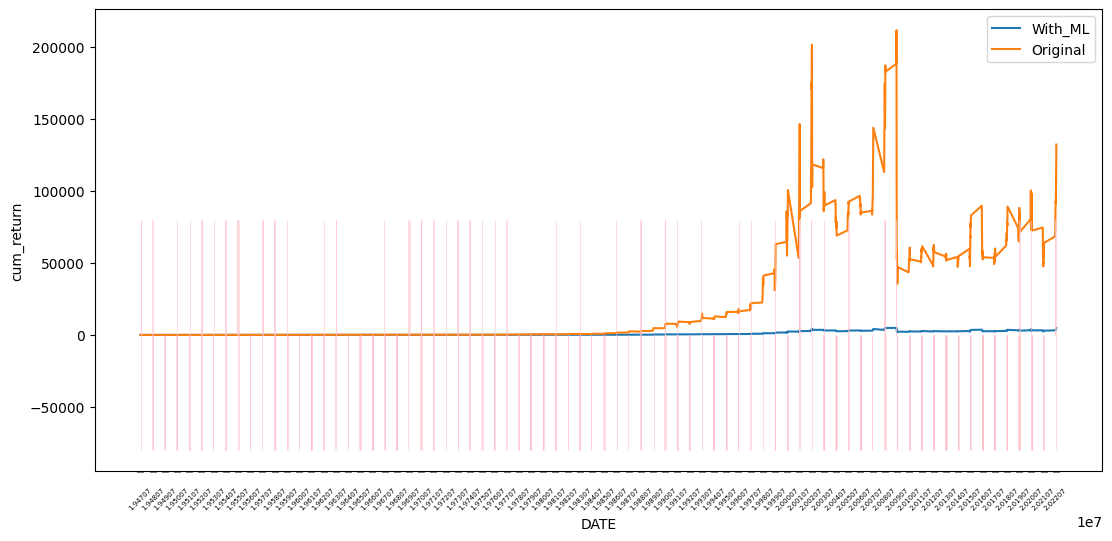

In [124]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [125]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.25      0.28       316
         1.0       0.64      0.71      0.67       590

    accuracy                           0.55       906
   macro avg       0.48      0.48      0.48       906
weighted avg       0.53      0.55      0.54       906


accuracy : 0.5507726269315674

precision : 0.639269406392694

recall : 0.711864406779661

F1-Score : 0.6736166800320769



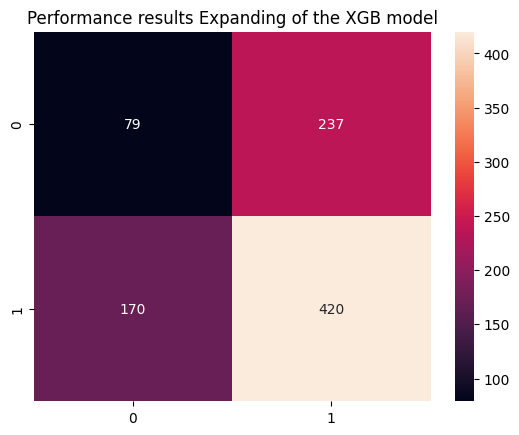


Feature Importance of the model



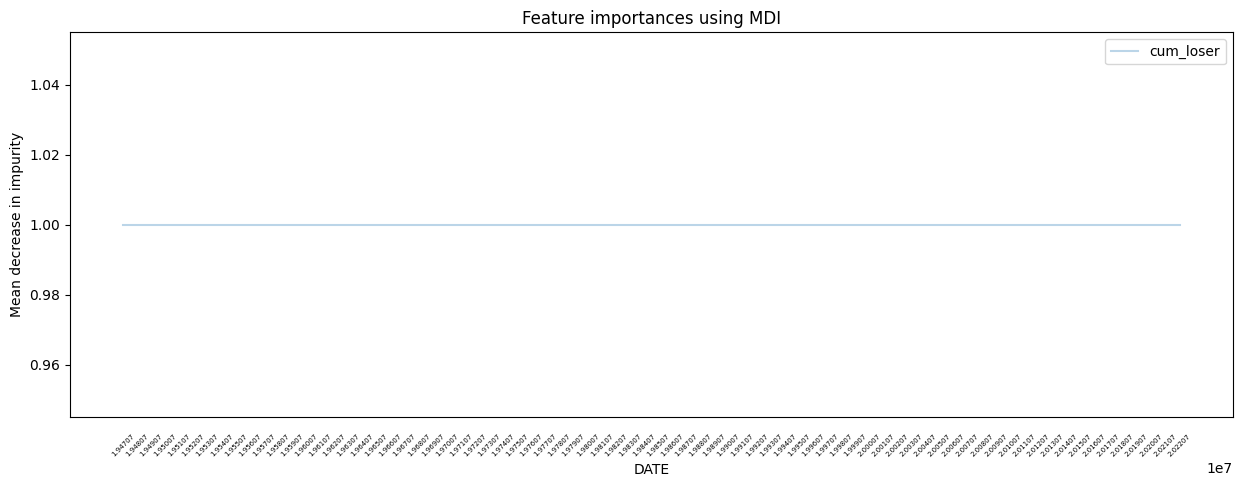

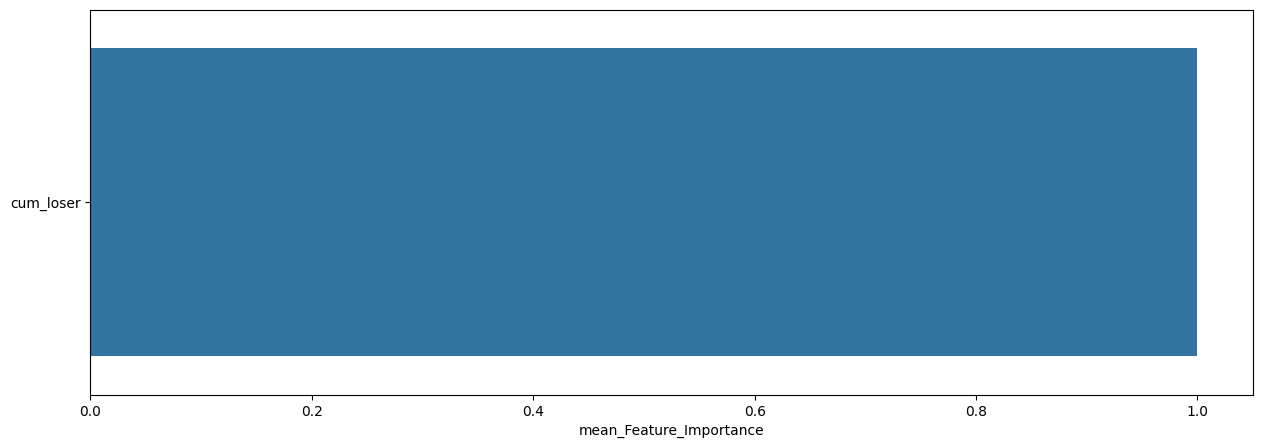

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [126]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.32      0.33        75
         1.0       0.67      0.68      0.68       151

    accuracy                           0.56       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.56      0.56      0.56       226


accuracy : 0.5619469026548672

precision : 0.6688311688311688

recall : 0.6821192052980133

F1-Score : 0.6754098360655738



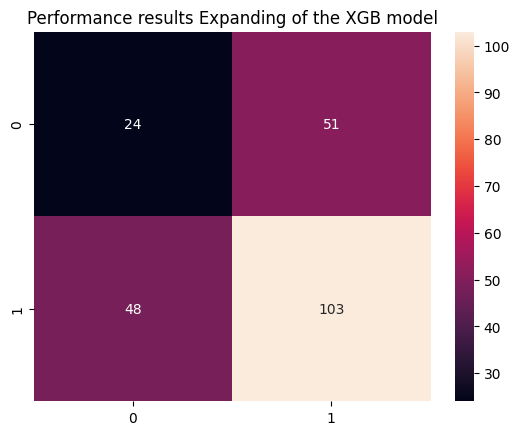


Feature Importance of the model



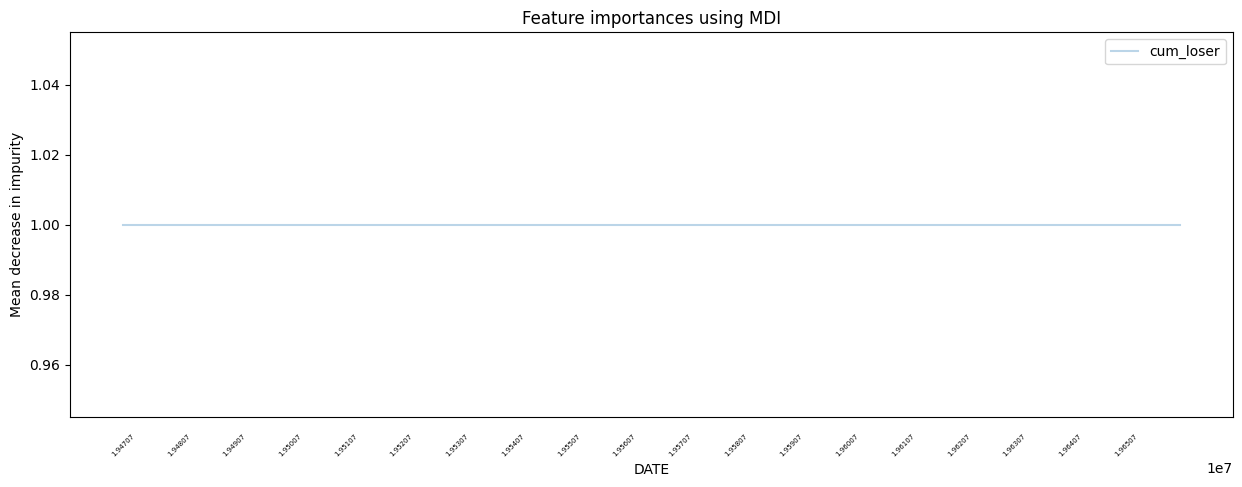

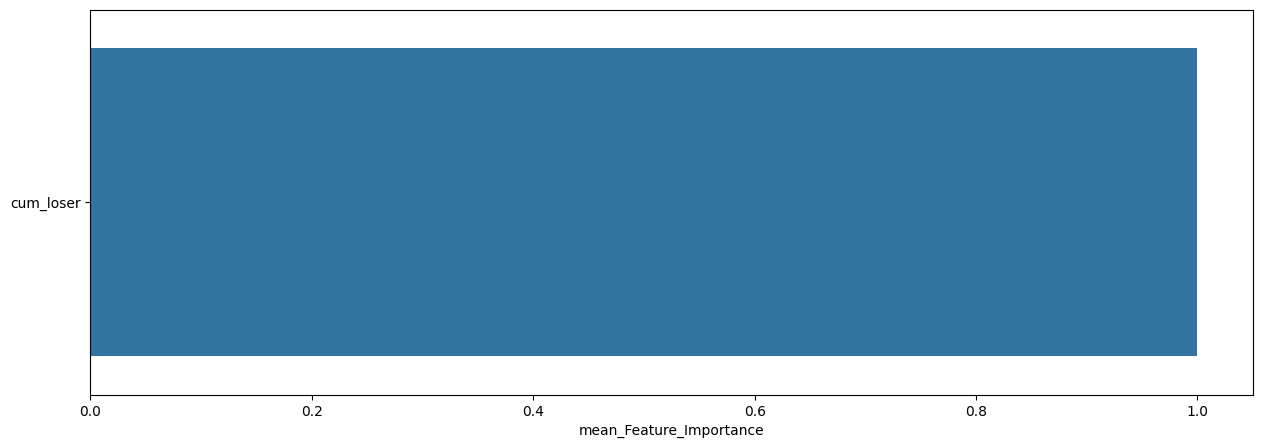

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.29      0.31        75
         1.0       0.66      0.69      0.68       151

    accuracy                           0.56       226
   macro avg       0.49      0.49      0.49       226
weighted avg       0.55      0.56      0.55       226


accuracy : 0.5575221238938053

precision : 0.6624203821656051

recall : 0.6887417218543046

F1-Score : 0.6753246753246753



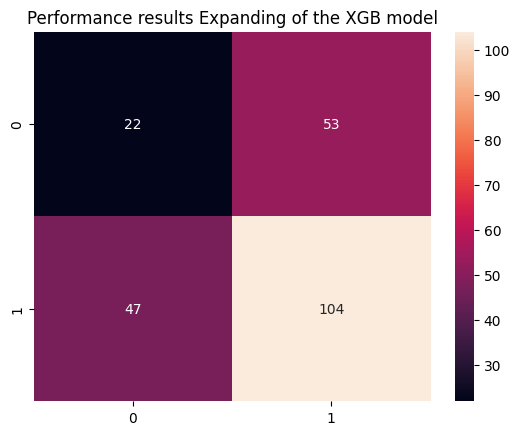


Feature Importance of the model



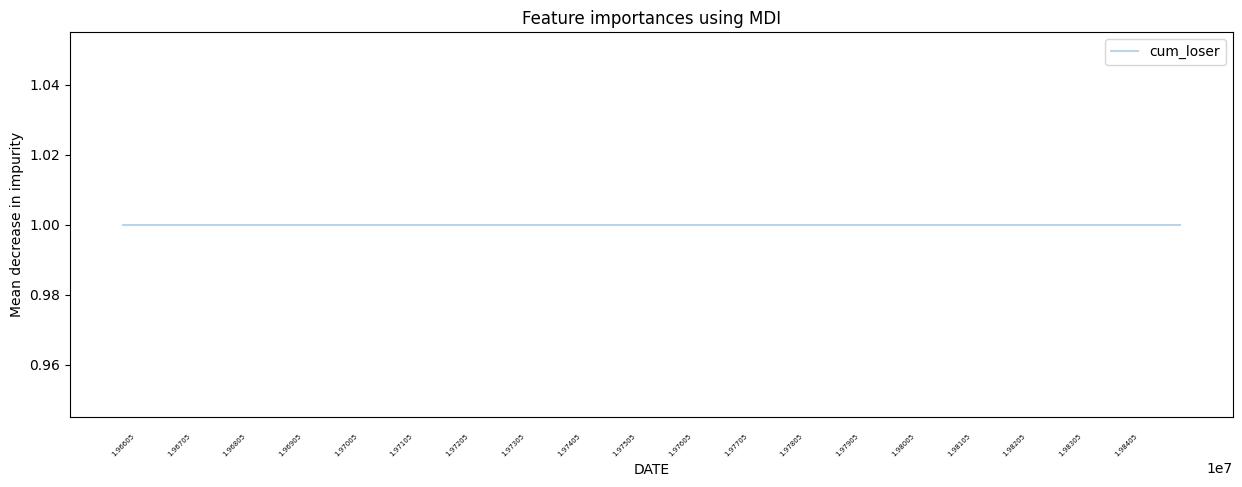

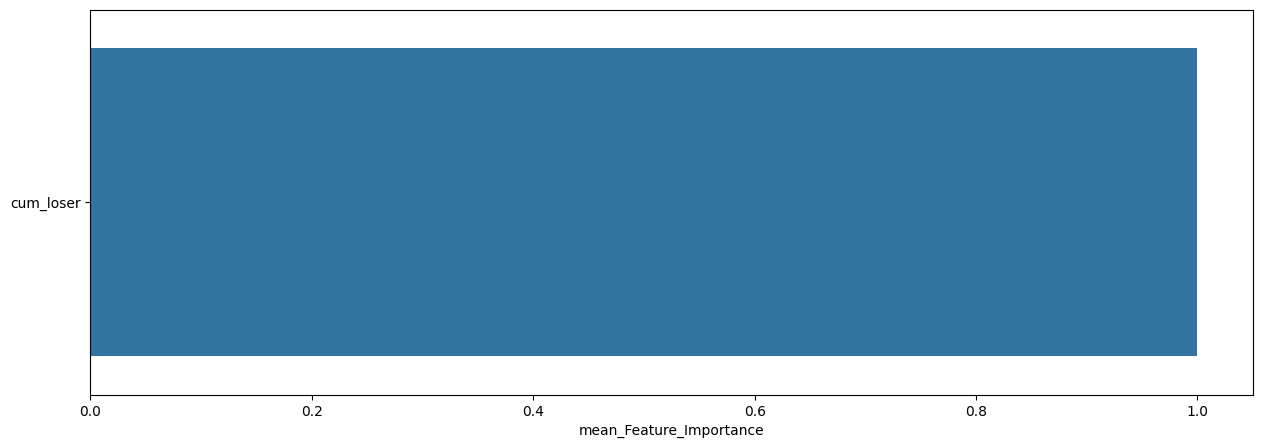

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.29      0.30        70
         1.0       0.69      0.72      0.71       156

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.58      0.59      0.58       226


accuracy : 0.588495575221239

precision : 0.6932515337423313

recall : 0.7243589743589743

F1-Score : 0.7084639498432602



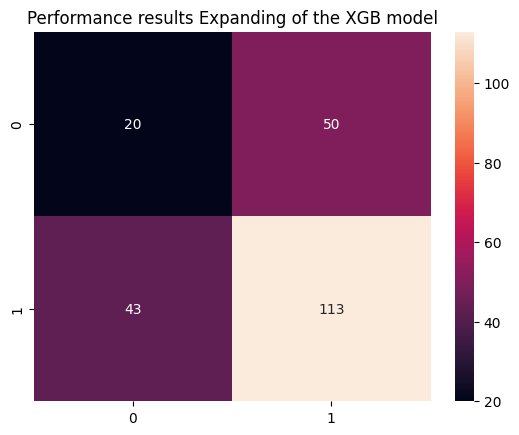


Feature Importance of the model



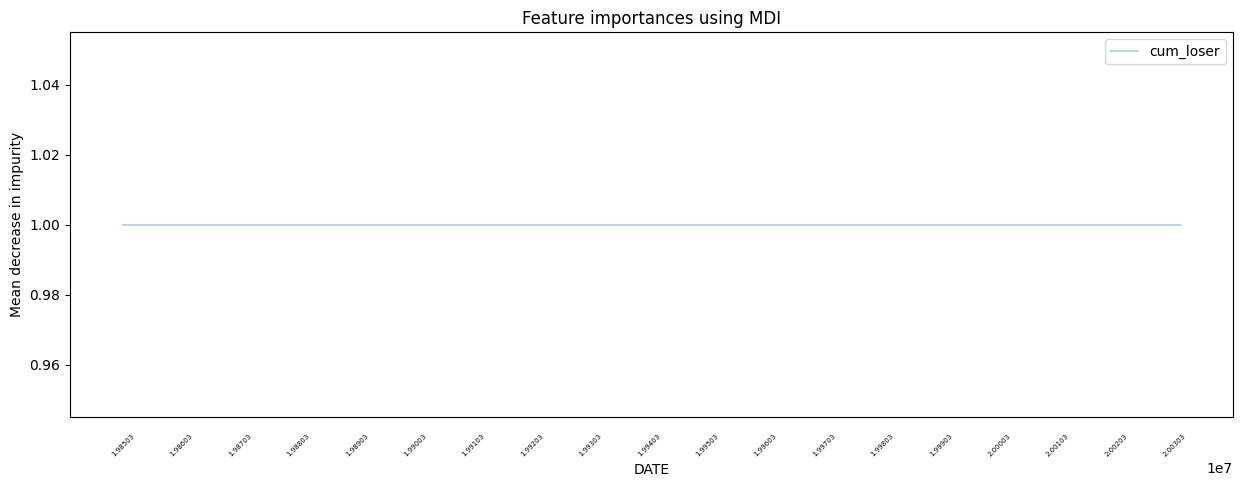

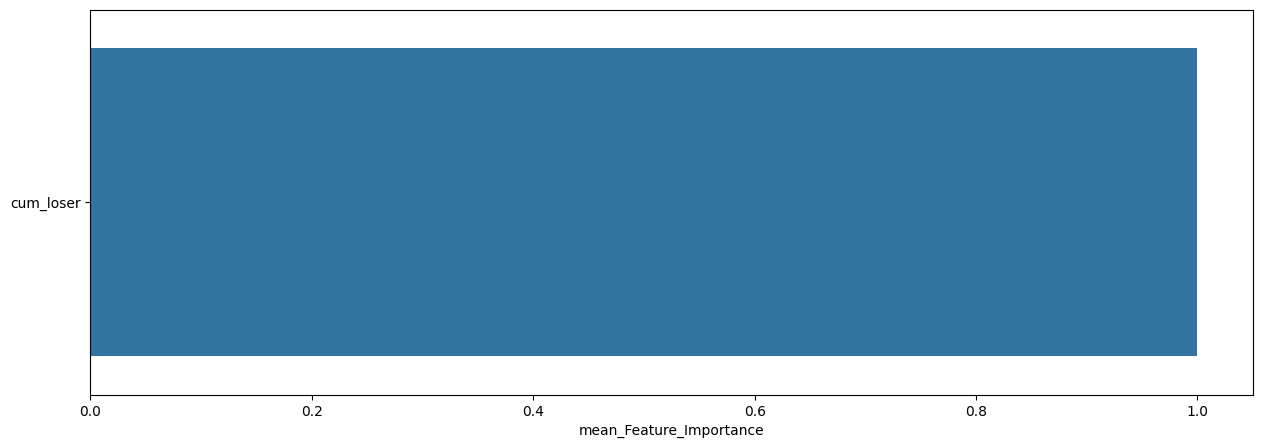

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.18        96
         1.0       0.55      0.76      0.63       132

    accuracy                           0.50       228
   macro avg       0.42      0.45      0.41       228
weighted avg       0.44      0.50      0.45       228


accuracy : 0.4956140350877193

precision : 0.546448087431694

recall : 0.7575757575757576

F1-Score : 0.634920634920635



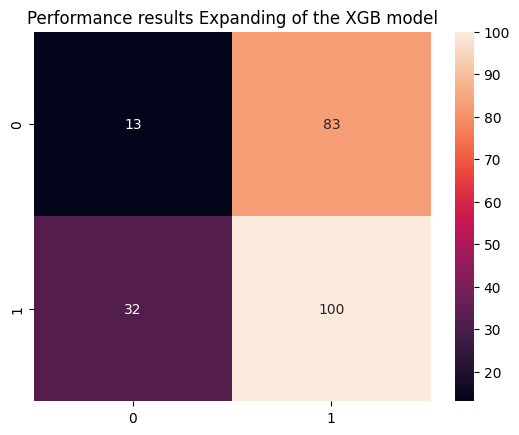


Feature Importance of the model



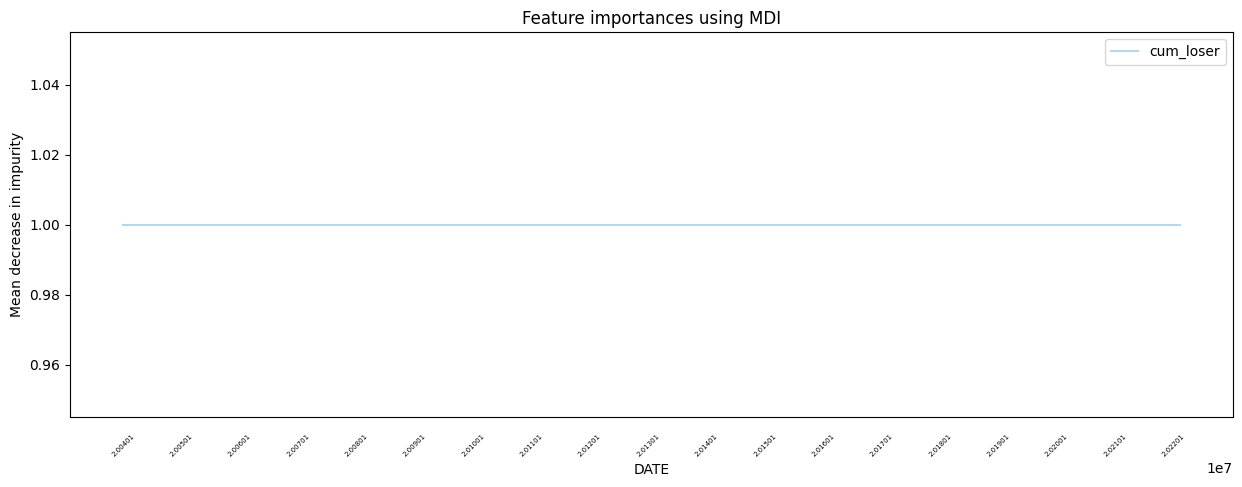

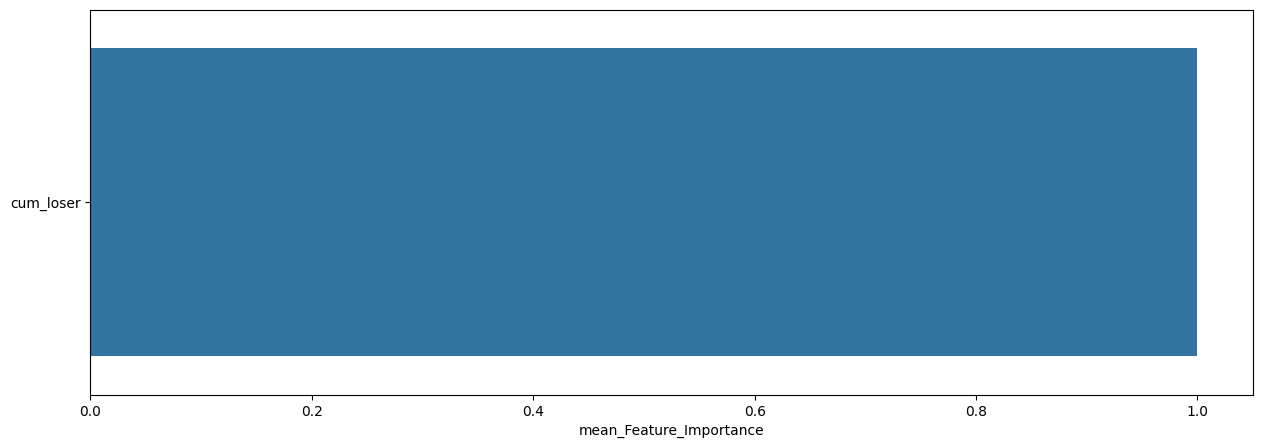

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                      1.0                     1.0   

           min_Feature_Importance  
cum_loser                     1.0

In [127]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



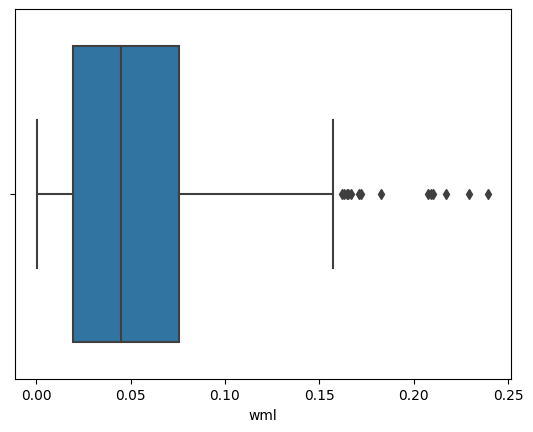

count      mean       std       min       25%      50%       75%  \
wml  420.0  0.053602  0.043814  0.000577  0.019242  0.04509  0.075441   

          max  
wml  0.239571


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



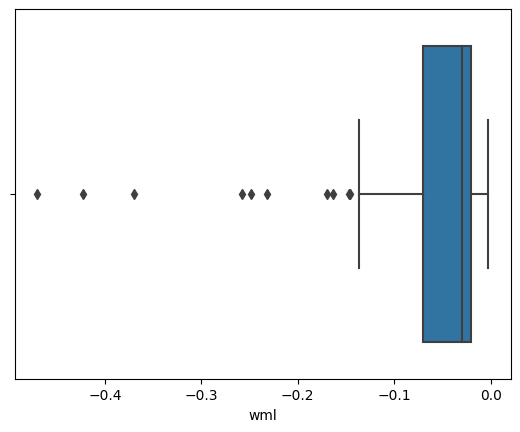

count      mean       std       min       25%       50%       75%  \
wml   79.0 -0.066735  0.090099 -0.469903 -0.070223 -0.030127 -0.019897   

         max  
wml -0.00241


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



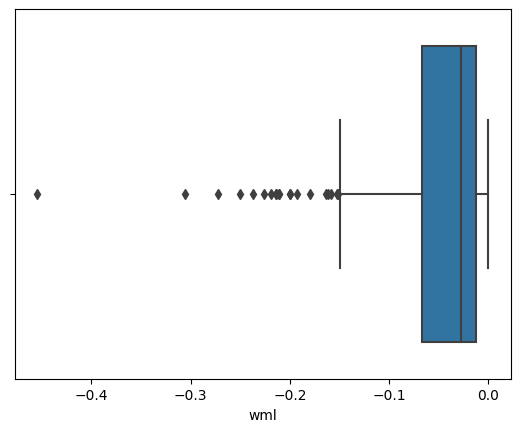

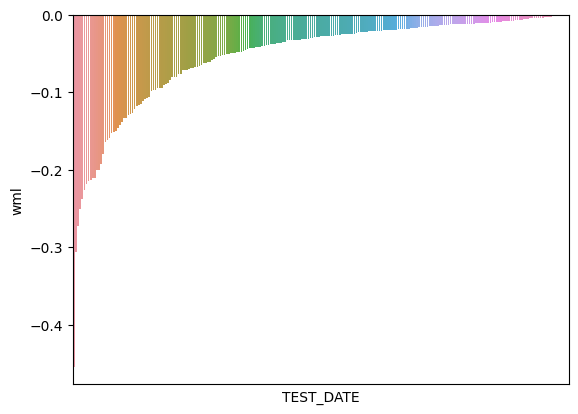

count      mean       std       min       25%       50%       75%  \
wml  237.0 -0.052836  0.063573 -0.454349 -0.067433 -0.027746 -0.012642   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



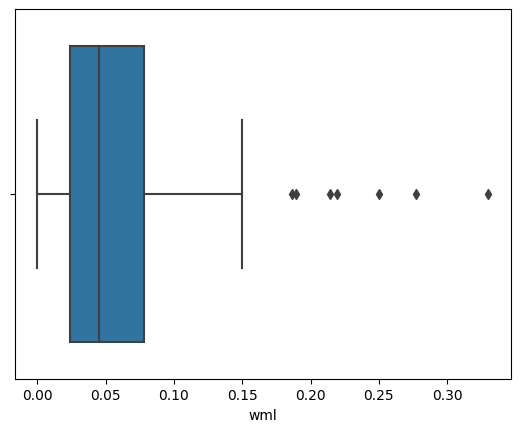

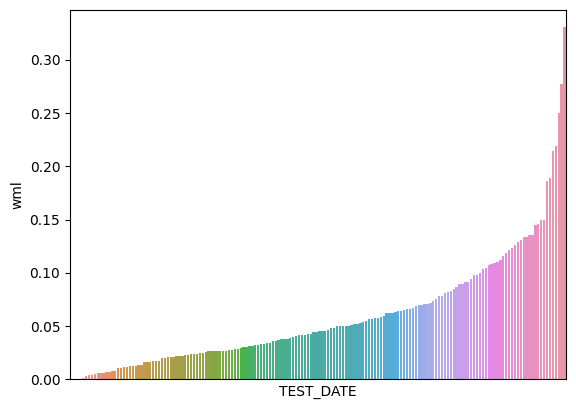

count      mean       std       min       25%       50%      75%  \
wml  170.0  0.059321  0.053426  0.000007  0.023919  0.044834  0.07819   

          max  
wml  0.330163

In [128]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.72965

최근 누적 수익률

  2022년-12월 -> 3315.44
  2022년-11월 -> 2987.06
  2022년-10월 -> 2841.27
  2022년-09월 -> 2515.80
  2022년-08월 -> 2287.14

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 4389.42
  2등 : 2003년-02월 -> 4215.97
  3등 : 2003년-03월 -> 4156.08
  4등 : 2002년-12월 -> 4094.72
  5등 : 2003년-01월 -> 4005.07
  6등 : 2008년-12월 -> 3923.68
  7등 : 2009년-01월 -> 3923.68
  8등 : 2009년-03월 -> 3923.68
  9등 : 2008년-11월 -> 3923.68
  10등 : 2009년-02월 -> 3923.68



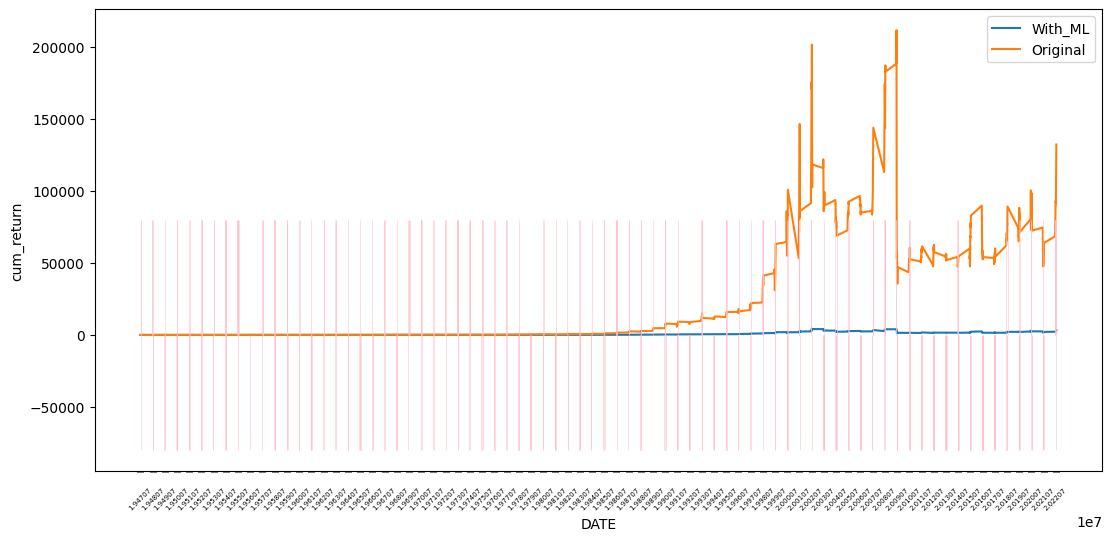

In [129]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73580

최근 누적 수익률

  2022년-12월 -> 4608.85
  2022년-11월 -> 4174.76
  2022년-10월 -> 4070.29
  2022년-09월 -> 3625.63
  2022년-08월 -> 3317.69

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 4608.85
  2등 : 2022년-11월 -> 4174.76
  3등 : 2022년-10월 -> 4070.29
  4등 : 2009년-02월 -> 3901.38
  5등 : 2008년-11월 -> 3744.98
  6등 : 2009년-01월 -> 3732.26
  7등 : 2008년-12월 -> 3702.69
  8등 : 2022년-09월 -> 3625.63
  9등 : 2020년-03월 -> 3560.47
  10등 : 2008년-06월 -> 3547.57



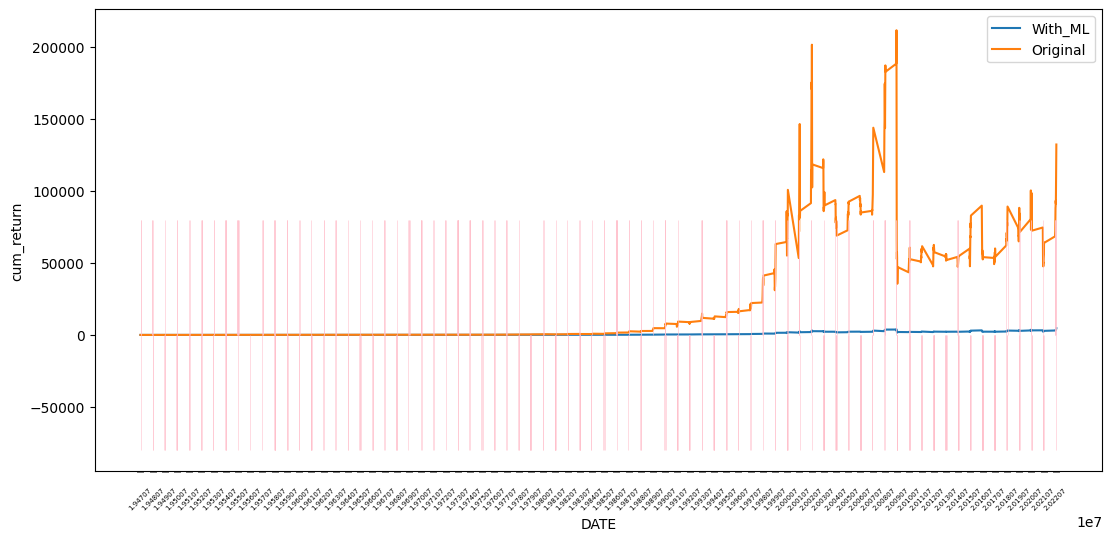

In [130]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [131]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.18      0.23       316
         1.0       0.64      0.80      0.71       590

    accuracy                           0.58       906
   macro avg       0.48      0.49      0.47       906
weighted avg       0.53      0.58      0.54       906


accuracy : 0.5805739514348786

precision : 0.6438356164383562

recall : 0.7966101694915254

F1-Score : 0.712121212121212



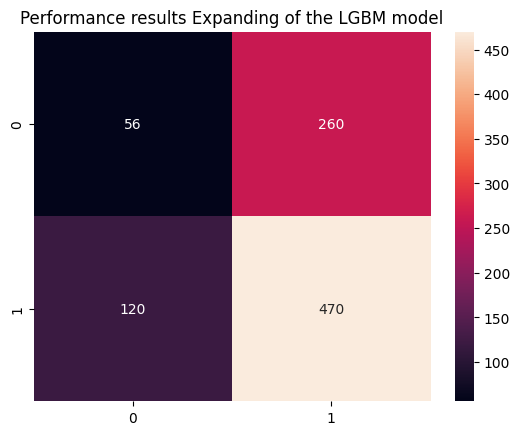


Feature Importance of the model



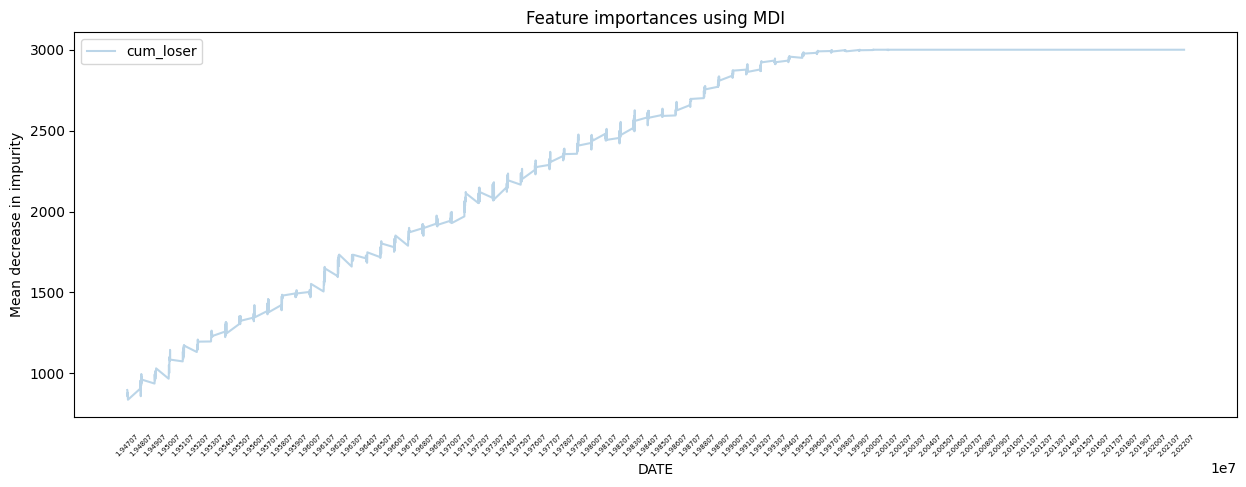

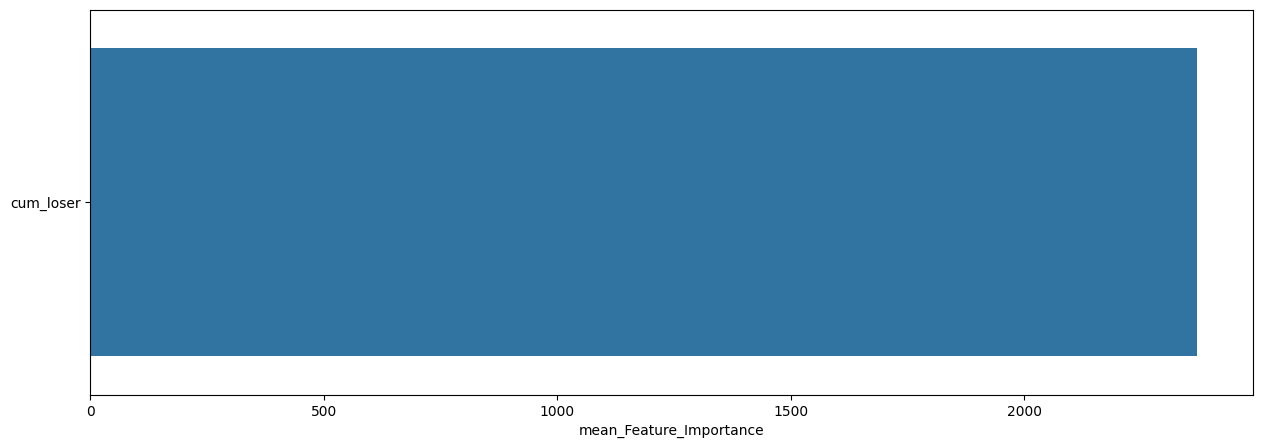

mean_Feature_Importance  max_Feature_Importance  \
cum_loser              2371.381898                    3000   

           min_Feature_Importance  
cum_loser                     837

In [132]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.20      0.24        75
         1.0       0.66      0.78      0.72       151

    accuracy                           0.59       226
   macro avg       0.49      0.49      0.48       226
weighted avg       0.55      0.59      0.56       226


accuracy : 0.588495575221239

precision : 0.6629213483146067

recall : 0.7814569536423841

F1-Score : 0.7173252279635258



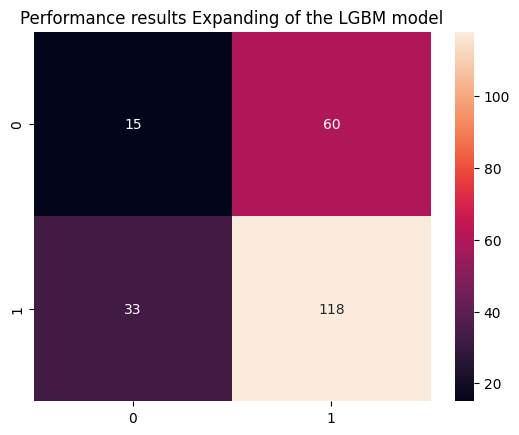


Feature Importance of the model



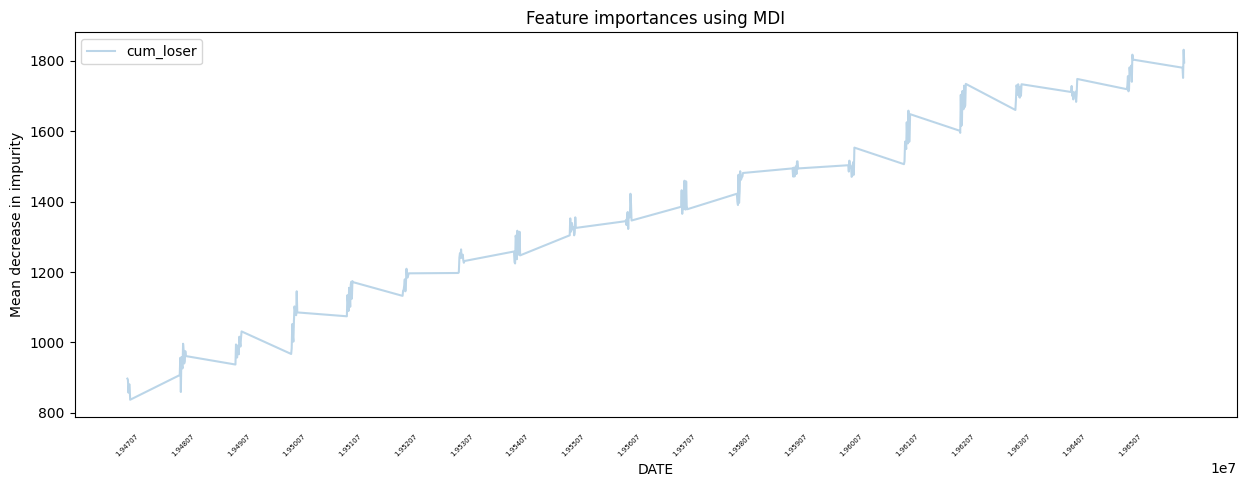

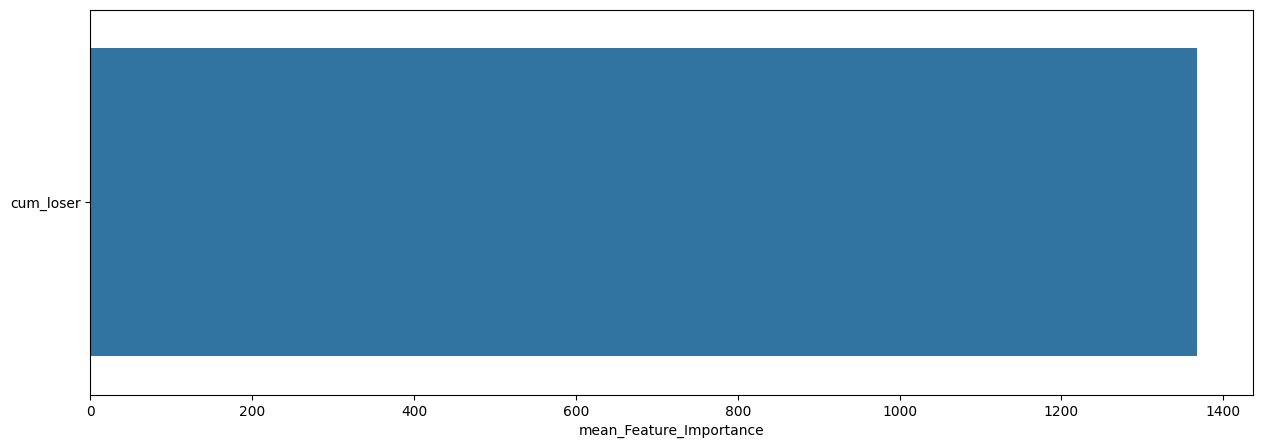

mean_Feature_Importance  max_Feature_Importance  \
cum_loser              1368.132743                    1831   

           min_Feature_Importance  
cum_loser                     837


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.17      0.21        75
         1.0       0.65      0.77      0.71       151

    accuracy                           0.57       226
   macro avg       0.46      0.47      0.46       226
weighted avg       0.53      0.57      0.54       226


accuracy : 0.5707964601769911

precision : 0.651685393258427

recall : 0.7682119205298014

F1-Score : 0.7051671732522796



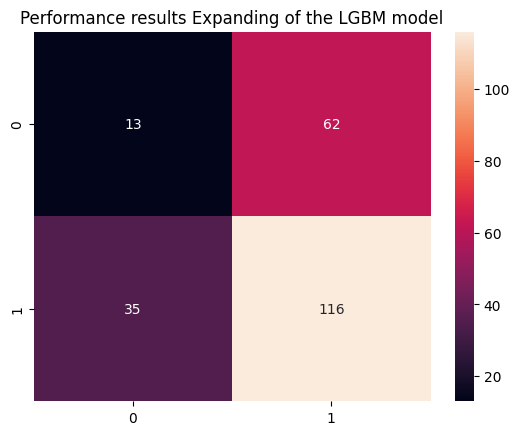


Feature Importance of the model



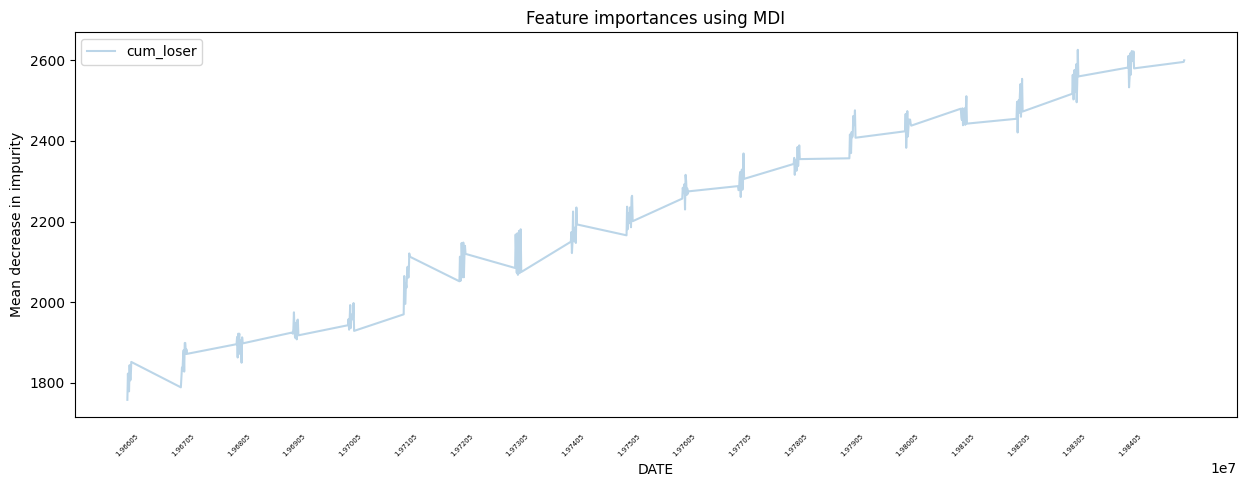

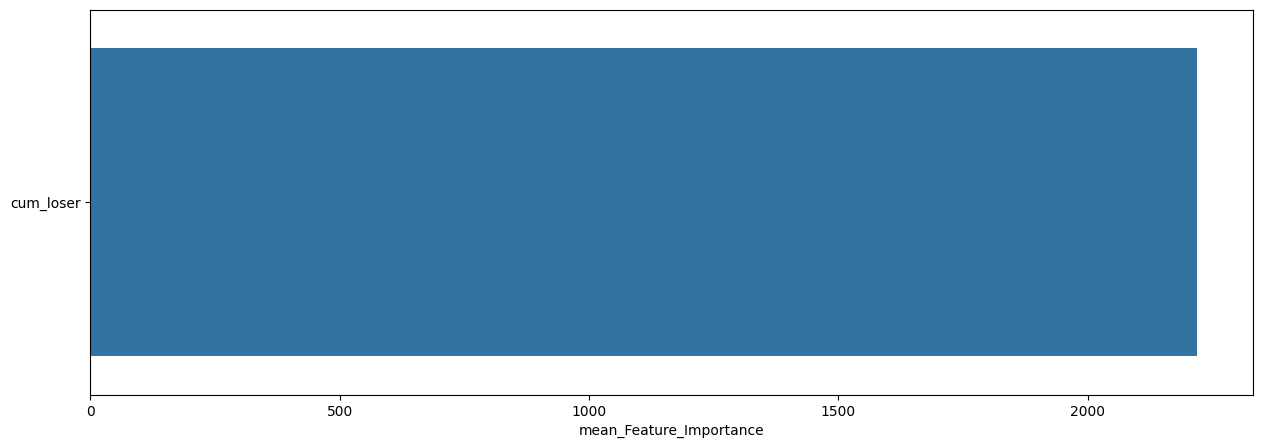

mean_Feature_Importance  max_Feature_Importance  \
cum_loser              2220.185841                    2626   

           min_Feature_Importance  
cum_loser                    1758


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.27      0.32        70
         1.0       0.71      0.81      0.76       156

    accuracy                           0.65       226
   macro avg       0.55      0.54      0.54       226
weighted avg       0.62      0.65      0.62       226


accuracy : 0.6460176991150443

precision : 0.7134831460674157

recall : 0.8141025641025641

F1-Score : 0.7604790419161676



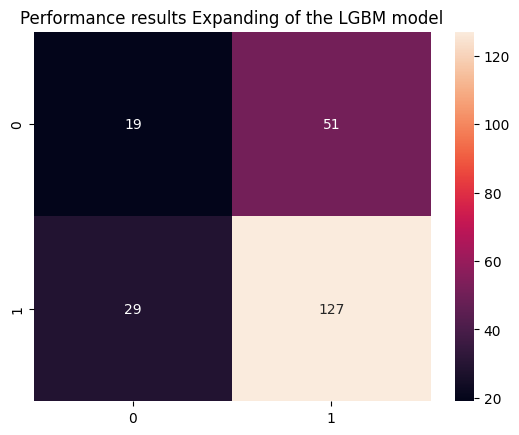


Feature Importance of the model



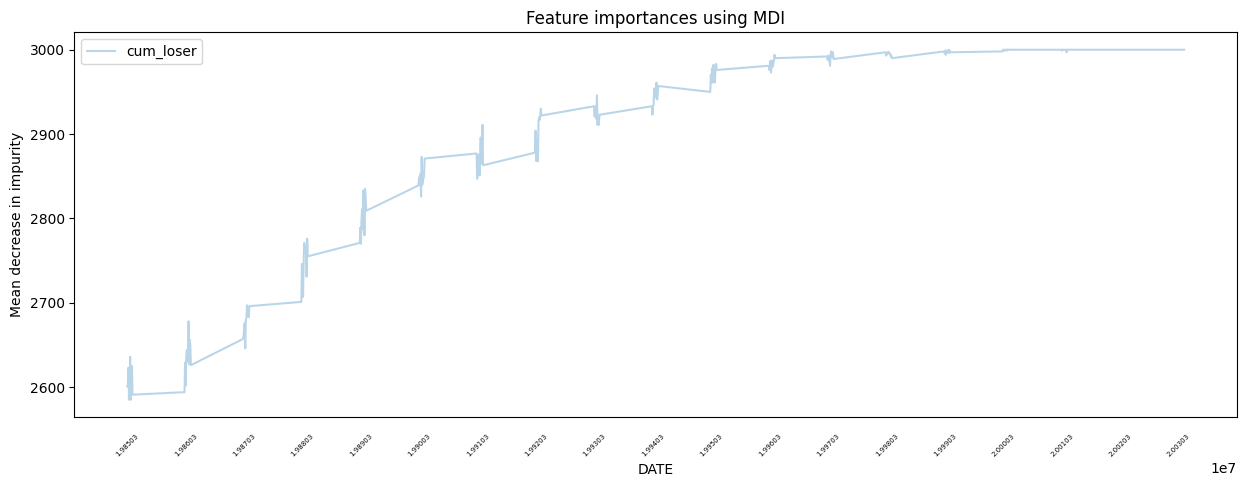

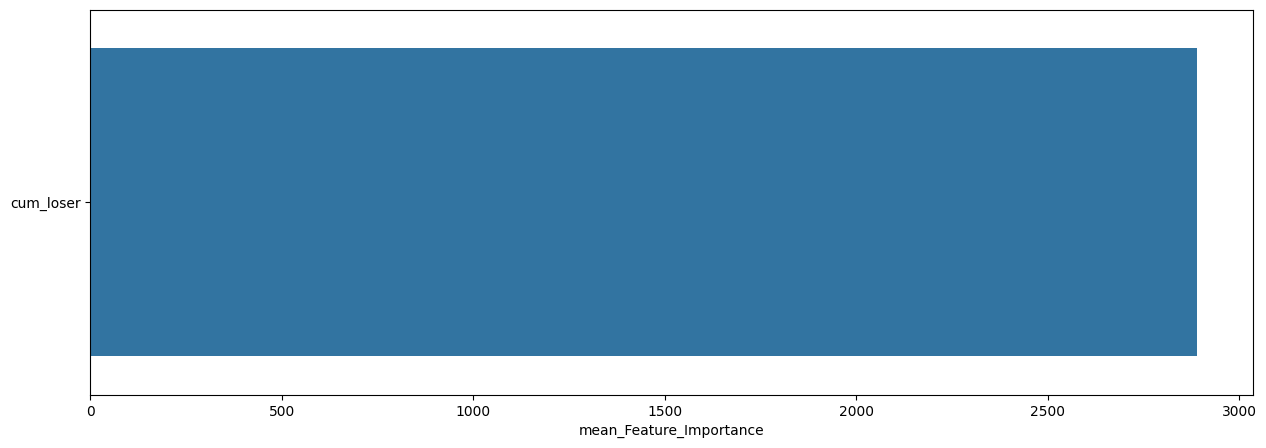

mean_Feature_Importance  max_Feature_Importance  \
cum_loser              2891.646018                    3000   

           min_Feature_Importance  
cum_loser                    2585


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.09      0.14        96
         1.0       0.56      0.83      0.66       132

    accuracy                           0.52       228
   macro avg       0.42      0.46      0.40       228
weighted avg       0.44      0.52      0.44       228


accuracy : 0.5175438596491229

precision : 0.5561224489795918

recall : 0.8257575757575758

F1-Score : 0.6646341463414634



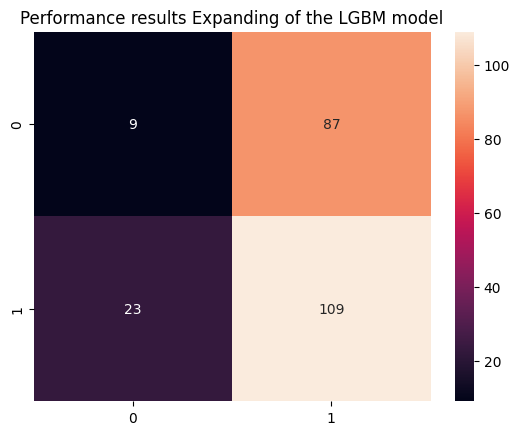


Feature Importance of the model



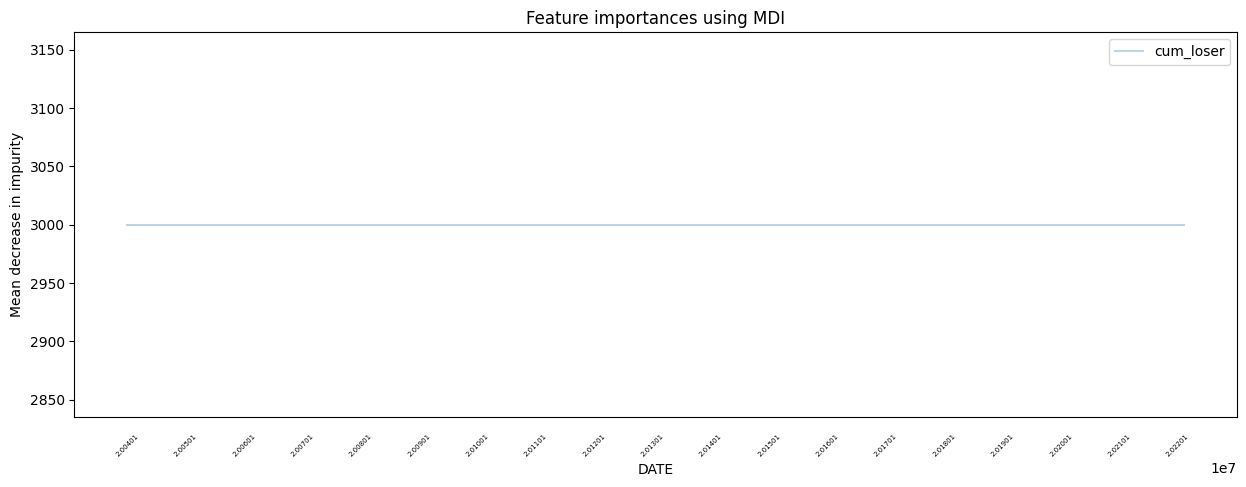

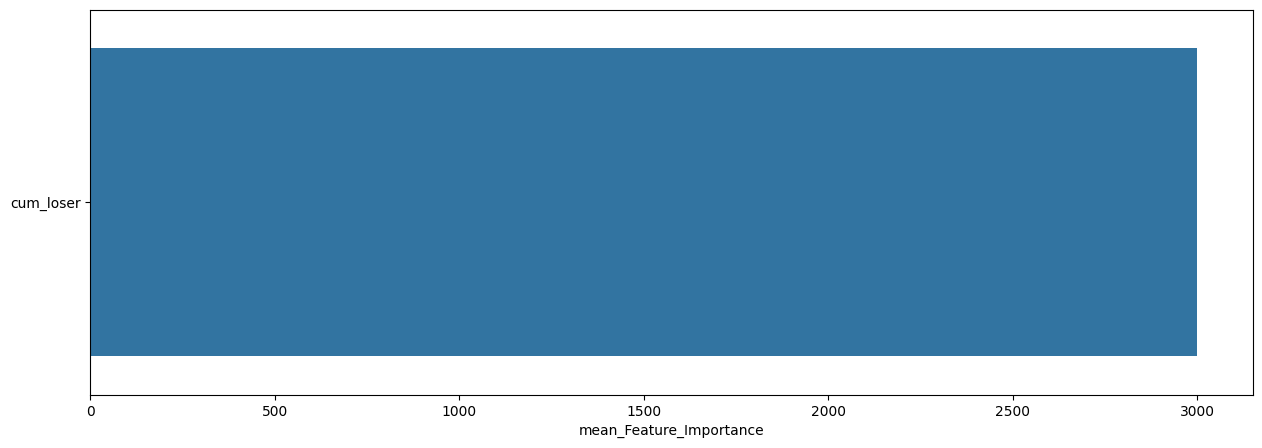

mean_Feature_Importance  max_Feature_Importance  \
cum_loser                   3000.0                    3000   

           min_Feature_Importance  
cum_loser                    3000

In [133]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



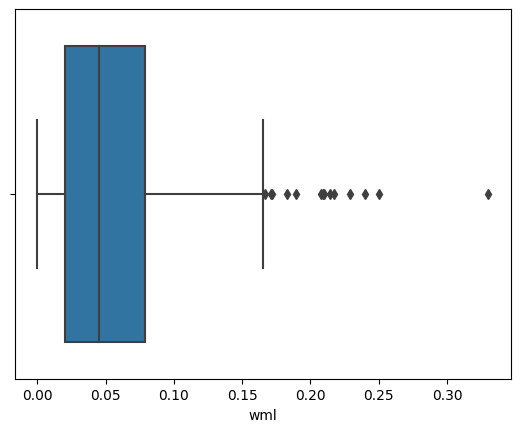

count      mean       std       min       25%       50%       75%  \
wml  470.0  0.055252  0.047218  0.000128  0.020074  0.045061  0.078529   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



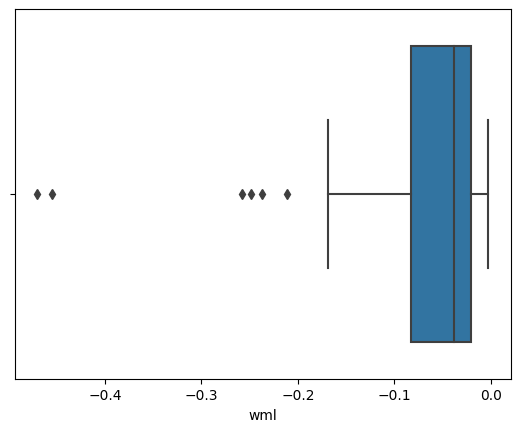

count      mean       std       min       25%       50%      75%  \
wml   56.0 -0.076873  0.097952 -0.469903 -0.083147 -0.037789 -0.02084   

          max  
wml -0.002661


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



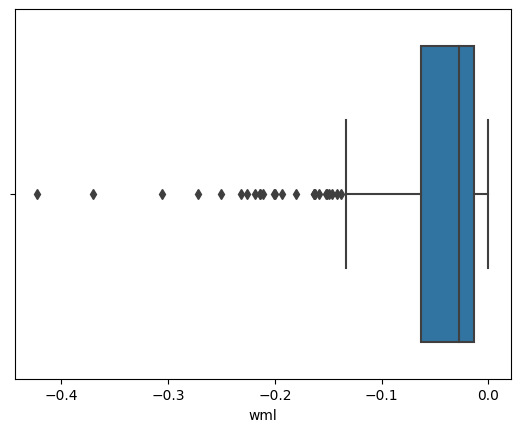

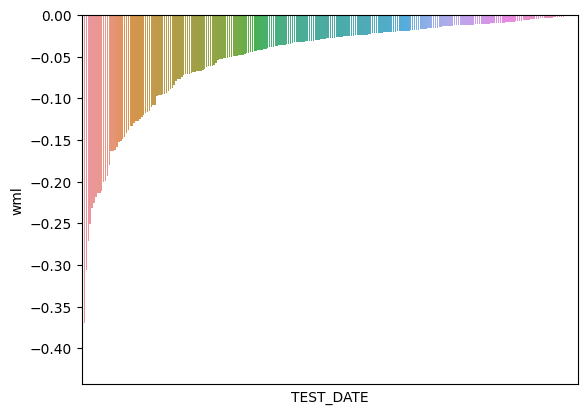

count      mean       std     min       25%       50%       75%       max
wml  260.0 -0.051882  0.063428 -0.4224 -0.063039 -0.027518 -0.013108 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



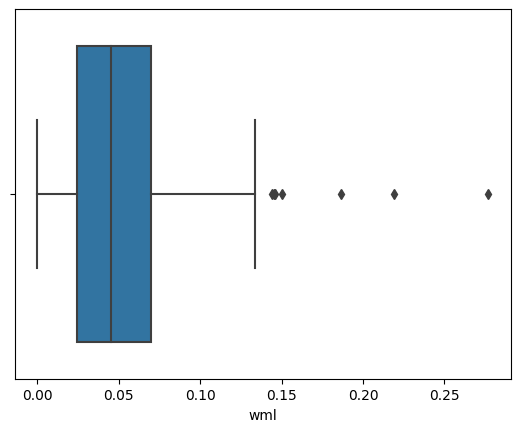

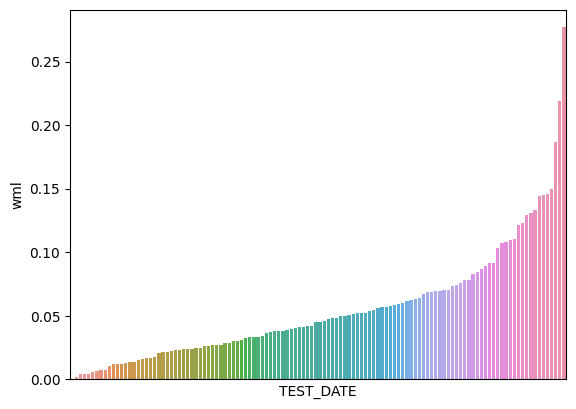

count      mean       std       min       25%       50%       75%  \
wml  120.0  0.055241  0.045374  0.000007  0.024363  0.045156  0.069754   

          max  
wml  0.276912

In [134]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.67375

최근 누적 수익률

  2022년-12월 -> 30077.69
  2022년-11월 -> 27099.38
  2022년-10월 -> 25777.18
  2022년-09월 -> 22825.25
  2022년-08월 -> 20751.46

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 43905.24
  2등 : 2002년-08월 -> 37124.40
  3등 : 2002년-07월 -> 37124.40
  4등 : 2002년-10월 -> 35424.90
  5등 : 2002년-06월 -> 35198.85
  6등 : 2002년-04월 -> 30266.77
  7등 : 2002년-05월 -> 30266.77
  8등 : 2022년-12월 -> 30077.69
  9등 : 2022년-11월 -> 27099.38
  10등 : 2003년-02월 -> 26565.48



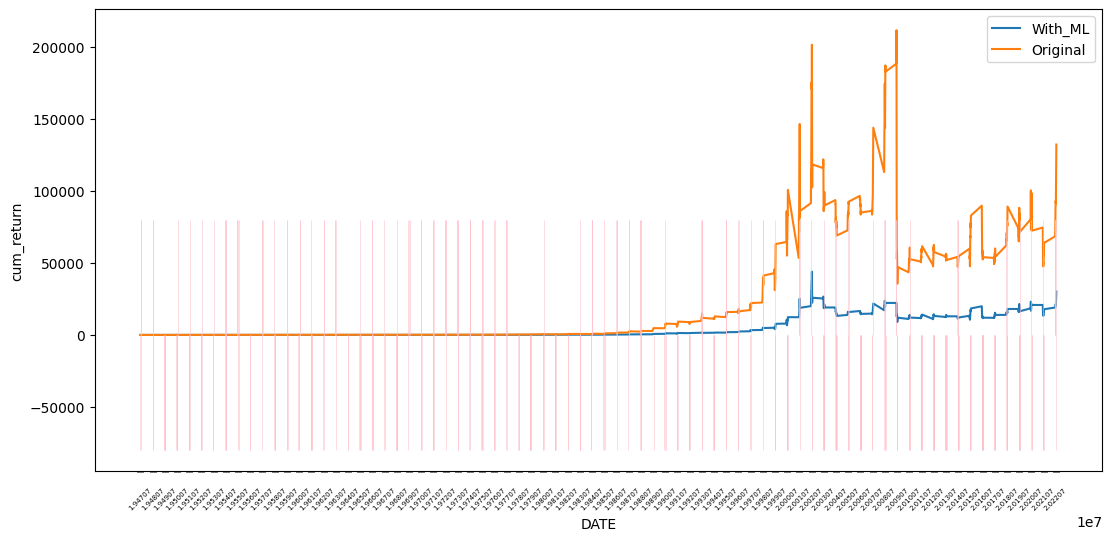

In [135]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.72921

최근 누적 수익률

  2022년-12월 -> 6452.37
  2022년-11월 -> 5866.81
  2022년-10월 -> 5701.34
  2022년-09월 -> 5171.55
  2022년-08월 -> 4855.79

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 6452.37
  2등 : 2022년-11월 -> 5866.81
  3등 : 2022년-10월 -> 5701.34
  4등 : 2022년-09월 -> 5171.55
  5등 : 2022년-07월 -> 4920.97
  6등 : 2009년-02월 -> 4912.52
  7등 : 2022년-08월 -> 4855.79
  8등 : 2022년-06월 -> 4766.49
  9등 : 2022년-05월 -> 4737.10
  10등 : 2020년-03월 -> 4666.42



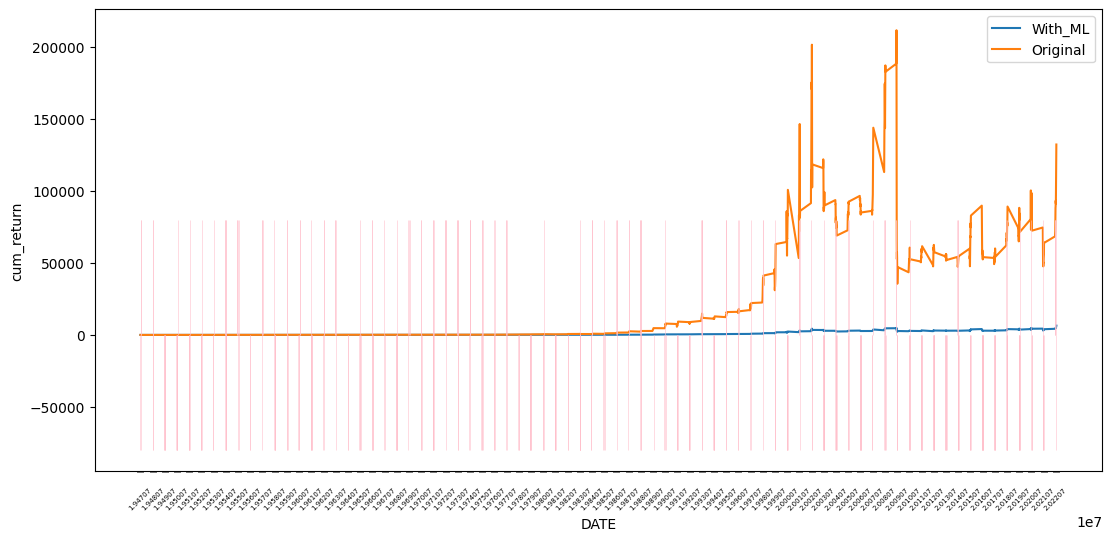

In [136]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.6513213981244672
GBC의 F1-Score : 0.7090196078431371
XGB의 F1-Score : 0.6769983686786297
LGBM의 F1-Score : 0.7342709104367136



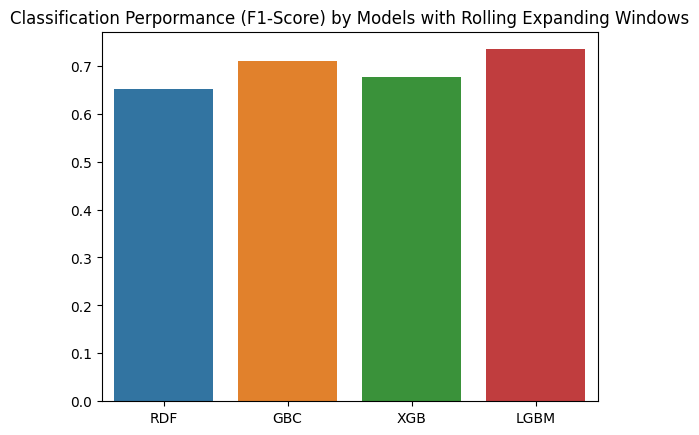

In [137]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.6255430060816681
GBC의 F1-Score : 0.7388441843452817
XGB의 F1-Score : 0.6736166800320769
LGBM의 F1-Score : 0.712121212121212



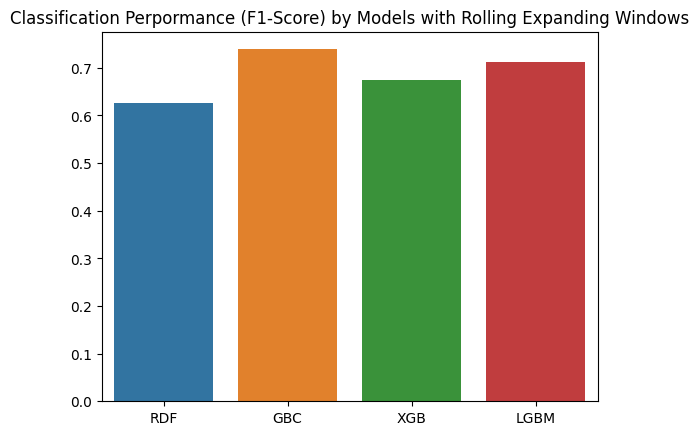

In [138]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [139]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [140]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6564  최종 누적 수익률 : 5900.598023191738
GBC Sharpe Ratio : 0.6960  최종 누적 수익률 : 21464.161444290825
XGB Sharpe Ratio : 0.5720  최종 누적 수익률 : 2399.029158762627
LGBM Sharpe Ratio : 0.6737  최종 누적 수익률 : 24275.647734377057


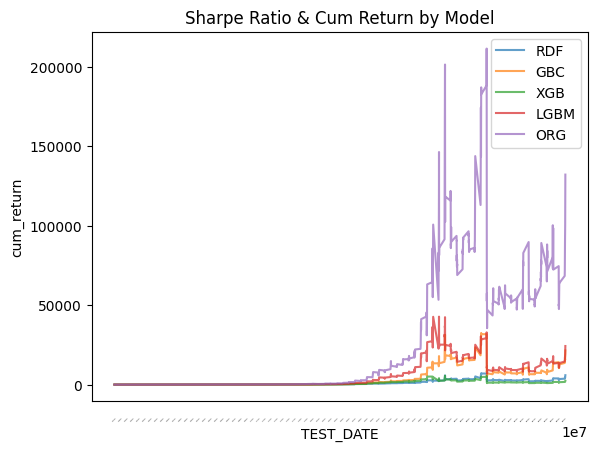

In [141]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7107  최종 누적 수익률 : 6946.510249211324
GBC Sharpe Ratio : 0.7079  최종 누적 수익률 : 5329.633315625839
XGB Sharpe Ratio : 0.7448  최종 누적 수익률 : 9042.749018701119
LGBM Sharpe Ratio : 0.7709  최종 누적 수익률 : 9089.404549897507


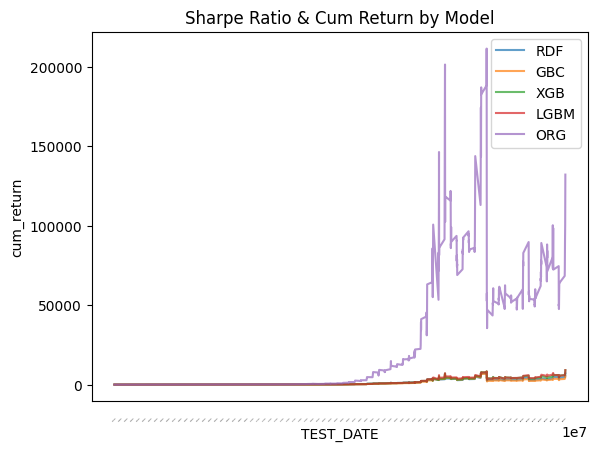

In [142]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.5573  최종 누적 수익률 : 934.1338875146707
GBC Sharpe Ratio : 0.7497  최종 누적 수익률 : 66435.81657674773
XGB Sharpe Ratio : 0.6128  최종 누적 수익률 : 3315.4439232506734
LGBM Sharpe Ratio : 0.7132  최종 누적 수익률 : 30077.694624618944


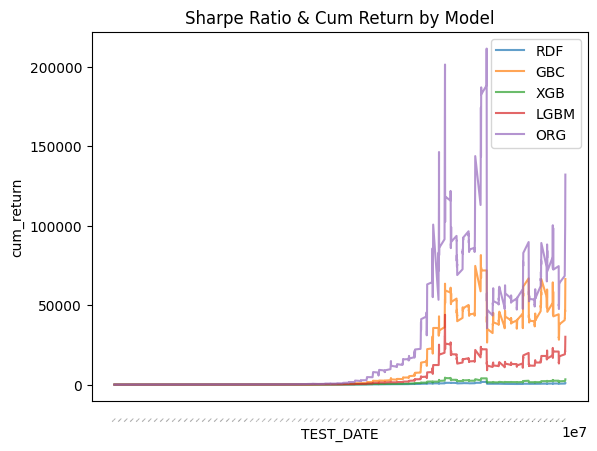

In [143]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6546  최종 누적 수익률 : 1867.051110440029
GBC Sharpe Ratio : 0.7569  최종 누적 수익률 : 4837.30084639524
XGB Sharpe Ratio : 0.7551  최종 누적 수익률 : 4608.846749832341
LGBM Sharpe Ratio : 0.7844  최종 누적 수익률 : 6452.3741876459


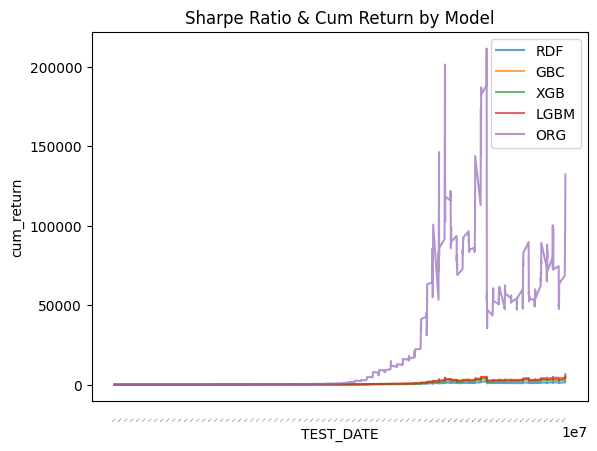

In [144]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)